## KGB Model LN Auto V2

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= Train[var].astype(str)
    Test[var]= Test[var].astype(str)
    Oot[var]= Oot[var].astype(str)
    TTD[var]= TTD[var].astype(str)

In [17]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [18]:
for var in var_to_cat:
    display(TTD[var].value_counts(dropna= False).reset_index())

,shorttermloanrequest24month,count
0,0,684741
1,1,474


,proflictypecategory,count
0,[-1],638472
1,2,13528
2,3,11890
3,1,8998
4,0,6503
5,4,3426
6,5,2398


,addrinputsubjectowned,count
0,0,281760
1,1,257681
2,[-1],145774


,addrprevioussubjectowned,count
0,1,386644
1,[-1],242275
2,3,48292
3,2,8004


,addronfilecorrectional,count
0,0,685185
1,1,30


,shorttermloanrequest12month,count
0,0,684991
1,1,224


,sourcevoterregistration,count
0,0,477652
1,1,207563


,addronfilehighrisk,count
0,0,685068
1,1,147


,educationattendance,count
0,0,598194
1,1,87021


,inquiryauto12month,count
0,0,562020
1,1,123195


,assetpersonal,count
0,0,638628
1,1,46587


,educationprogramattended,count
0,0,605206
1,2,59905
2,1,20061
3,3,43


,inquirybanking12month,count
0,0,548796
1,1,136419


,assetpropnewestmortgagetype,count
0,[-1],410554
1,0,261226
2,2,8590
3,1,4845


,inquirytelcom12month,count
0,0,668923
1,1,16292


,addrinputproblems,count
0,0,650663
1,2,28442
2,1,3105
3,[-1],2147
4,4,459
5,3,399


,assetprop,count
0,1,352389
1,0,332826


,businessassociation,count
0,0,613259
1,1,71956


,addrlastmoveecontrajectory,count
0,1,306534
1,10,61914
2,4,52182
3,11,51032
4,9,43630
5,8,43557
6,0,34343
7,3,32634
8,12,31812
9,2,19599


,addronfilecollege,count
0,0,676357
1,1,8858


,educationevidence,count
0,0,577557
1,1,107658


,inquirynonshortterm12month,count
0,0,457800
1,1,227415


,addrcurrentdeedmailing,count
0,0,431307
1,[-1],131635
2,1,122273


,shorttermloanrequest,count
0,0,682745
1,1,2470


,addrcurrentsubjectowned,count
0,0,294416
1,1,259164
2,[-1],131635


,businesstitleleadership,count
0,[-1],613259
1,2,42292
2,1,15789
3,0,13875


,assetownership,count
0,1,360916
1,0,324299


,addrinputdeedmailing,count
0,0,428330
1,[-1],145774
2,1,111111


,subjectnewestrecord12month,count
0,1,676467
1,0,8748


,addrcurrentphoneservice,count
0,0,591099
1,1,94116


,bankruptcychapter,count
0,0,648409
1,1,28211
2,2,8572
3,[-1],23


,alertregulatorycondition,count
0,1,648370
1,2,36845


,bankruptcystatus,count
0,0,648409
1,1,33203
2,2,3175
3,[-1],428


,addrinputphoneservice,count
0,0,588952
1,1,94116
2,[-1],2147


,inquirycollections12month,count
0,0,681146
1,1,4069


,inquiryshortterm12month,count
0,0,654816
1,1,30399


,educationinstitutionrating,count
0,0,618312
1,4,19348
2,3,18299
3,5,14131
4,6,7982
5,2,6108
6,1,1035


In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [22]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [23]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [24]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm0dgqv7m
  JVM stdout: /tmp/tmpm0dgqv7m/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm0dgqv7m/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_pgtp2q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [25]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [26]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [27]:
for col in var_to_cat:
    train_h2o[col] = train_h2o[col].asfactor()
    test_h2o[col] = test_h2o[col].asfactor()
    oot_h2o[col] = oot_h2o[col].asfactor()
    ttd_h2o[col] = ttd_h2o[col].asfactor()

In [29]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

0 (141943, 145)
1 (3731, 145)
2 (1178, 145)
[-1] (0, 145)


In [30]:
train_h2o.head(rows= 5)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [31]:
train_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",0,1,0,"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",0,1,0,1,1,0,0,0,"[0.0, inf)",1,"[247.0, inf)",1,1,0,"[-inf, 0.203)",1,[-1],"[-inf, 0.0742)",[-1],"[-inf, 0.145)",[-1],"

### Baseline

In [32]:
# config= pd.read_csv('/home/pradeep/000_LDA_March2024/configfile.csv')
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
# req_cols = config.dropna().Feature_Name.to_list()
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()

### Run the Code

In [33]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_wt_lda_model",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [ ]:
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_wt_lda_model


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.01976592225135847
RMSE: 0.14059133064082746
LogLoss: 0.08806544752722786
Mean Per-Class Error: 0.3900097332260824
AUC: 0.8105991827625406
AUCPR: 0.12986620462395224
Gini: 0.6211983655250812

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0816766734588651
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      232538  7398  0.0308   (7398.0/239936.0)
1      3922    1313  0.7492   (3922.0/5235.0)
Total  236460  8711  0.0462   (11320.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0816767    0.188294  141
max f2                       0.0428851    0.257951  218
max f0point5                 0.149021     0.202059  71
max accuracy                 0.39029      0.978936  7
max precision                0.613625     1         0
max recall                   0.00131932   1         396
max specificity              0.613625     1         0
max absolute_mcc             0.0811043    0.171806  142
max min_per_class_accuracy   0.0249355    0.727877  277
max mean_per_class_accuracy  0.0249355    0.730427  277
max tns                      0.613625     239937    0
max fns                      0.613625     5217      0
max fps                      0.000734932  239937    399
max tps                      0.00131932   5235.24   396
max tnr                      0.613625     1         0
max fnr                      0.613625     0.996515  0
max fpr                      0.000734932  1         399
max tpr                      0.00131932   1         396

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0115828                   0.13532            10.3694    10.3694            0.236138         0.216476    0.236138                    0.216476            0.120107        0.120107                   936.945   936.945            0.111053
2        0.0235753                   0.101864           5.43334    7.8585             0.12373          0.134037    0.178957                    0.17454             0.0651593       0.185266                   443.334   685.85             0.165459
3        0.035158                    0.0869124          5.10076    6.94997            0.116157         0.109738    0.158268                    0.153191            0.059081        0.244347                   410.076   594.997            0.214064
4        0.0465803                   0.0782555          3.95917    6.21657            0.09016          0.0975705   0.141567                    0.139552            0.0452225       0.28957                    295.917   521.657            0.248652
5        0.0578973                   0.0718451          3.20107    5.62714            0.0728963        0.0904352   0.128144                    0.129951            0.0362266       0.325796                   220.107   462.714            0.274142
6        0.113696                    0.0495088          2.71023    4.1956             0.0617186        0.0733945   0.0955442                   0.102195            0.151228        0.477024                   171.023   319.56             0.371795
7        0.168903                    0.0359194          2.

##### Train Predictions

In [35]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [38]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [39]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030440,0.613708,0.054923,49036.622016,45727.923516,3308.698500,6.75,20.0,19.06,63.20,44.14
1,0.017477,0.030439,0.023506,49034.114737,47953.494977,1080.619760,2.20,40.0,39.04,83.84,44.80
2,0.008528,0.017475,0.012296,49033.401979,48479.470209,553.931769,1.13,60.0,59.25,94.42,35.17
3,0.004462,0.008528,0.006276,49034.722905,48813.340743,221.382162,0.45,80.0,79.59,98.65,19.06
4,0.000401,0.004462,0.002846,49033.793016,48963.183153,70.609863,0.14,100.0,100.00,100.00,0.00


{'Gini': 57.269999999999996, 'KS': 44.8}


In [40]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030636,0.474383,0.055161,21026.753931,19711.441929,1315.312001,6.26,20.0,19.15,59.27,40.12
1,0.017503,0.030628,0.023589,21026.279915,20547.349239,478.930676,2.28,40.0,39.12,80.85,41.73
2,0.008572,0.017502,0.012355,21026.118025,20774.932421,251.185604,1.19,60.0,59.31,92.17,32.86
3,0.004422,0.008572,0.006259,21026.010869,20898.237275,127.773593,0.61,80.0,79.61,97.93,18.32
4,0.000393,0.004422,0.002827,21025.469586,20979.430880,46.038706,0.22,100.0,100.00,100.00,0.00


{'Gini': 53.21, 'KS': 41.73}


#### Non-weighted

In [41]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024138,0.613708,0.044428,29372,27967.0,1405.0,4.78,20.0,19.34,63.09,43.75
1,0.011951,0.024138,0.017570,29370,28902.0,468.0,1.59,40.0,39.32,84.10,44.78
2,0.006543,0.011951,0.008818,29372,29135.0,237.0,0.81,60.0,59.47,94.75,35.28
3,0.003737,0.006543,0.005052,29371,29283.0,88.0,0.30,80.0,79.71,98.70,18.99
4,0.000401,0.003737,0.002477,29370,29341.0,29.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 57.120000000000005, 'KS': 44.78}


In [42]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024210,0.474383,0.044571,12588,12011.0,577.0,4.58,20.0,19.38,60.17,40.79
1,0.011999,0.024210,0.017599,12588,12377.0,211.0,1.68,40.0,39.35,82.17,42.82
2,0.006514,0.011997,0.008839,12587,12486.0,101.0,0.80,60.0,59.49,92.70,33.21
3,0.003698,0.006513,0.005014,12588,12544.0,44.0,0.35,80.0,79.73,97.29,17.56
4,0.000393,0.003698,0.002461,12587,12561.0,26.0,0.21,100.0,100.00,100.00,0.00


{'Gini': 53.75, 'KS': 42.82}


In [43]:
Oot['wt2']= 1
TTD['wt2']= 1

In [44]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024202,0.438129,0.044417,7425,7112.0,313.0,4.22,20.0,19.44,57.43,37.99
1,0.012129,0.024201,0.017642,7424,7298.0,126.0,1.70,40.0,39.40,80.55,41.15
2,0.006578,0.012123,0.008905,7424,7365.0,59.0,0.79,60.0,59.53,91.38,31.85
3,0.003734,0.006578,0.005042,7424,7391.0,33.0,0.44,80.0,79.74,97.43,17.69
4,0.000450,0.003734,0.002496,7424,7410.0,14.0,0.19,100.0,100.00,100.00,0.00


{'Gini': 51.470000000000006, 'KS': 41.15}


In [45]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurre

In [46]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.0,64516.292969,1.000000,0.179497,assetownership
1,inquiryauto12month.0,63395.773438,0.982632,0.176379,inquiryauto12month
2,inquiryshortterm12month.0,26077.197266,0.404196,0.072552,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",21805.404297,0.337983,0.060667,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16299.140625,0.252636,0.045347,assetpropevercount
5,inquirytelcom12month.0,14574.346680,0.225902,0.040549,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",7310.495605,0.113312,0.020339,sourcenonderogcount
7,"addrlastmovetaxratiodiff.[-inf, 0.166)",6170.375977,0.095641,0.017167,addrlastmovetaxratiodiff
8,"sourcenonderogcount.[5.0, inf)",5824.618164,0.090281,0.016205,sourcenonderogcount
9,inquirynonshortterm12month.0,5755.111328,0.089204,0.016012,inquirynonshortterm12month


## HyperOpt

In [47]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
len(col_list)
# 86
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']

91

In [48]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [49]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [80]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [67]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 0.55)",[-1],"[-inf, 510.0)","[-inf, 97283.0)",[-1],[-1],"[-inf, 4900.0)","[176.0, 253.0)","[-inf, 0.436)","[324300.0, inf)","[-inf, 90271.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[43.0, 94.0)","[0.11, 0.72)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[-inf, 0.33)","[22.0, 45.0)","[-inf, 1.0)",[-1],[-1],"[0.11, 0.71)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)",[-1],"[-inf, 0.55)",[-1],"[253.0, 351.0)","[-inf, 4.755)",[-1],[-1],"[683.805, inf)",[-1],"[-inf, 2.581)",[-1],"[-inf, 0.0352)",[-1],"[115.0, 163.0)",[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],"[0.0, inf)",1,0,0,"[99.0, 165.0)",[-1],[-1],1,0,0,0,1,0,0,0,"[0.0, inf)",3,"[89.0, 136.0)",1,1,1,"[0.203, inf)",1,[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)",[-1],"[-inf, 0.028)",0,"[-inf, 0.00494)","[-inf, 0.000184)",0,[-1],0,"[-

In [85]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_v2_1",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
#     loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [86]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [94]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [95]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/200 [01:38<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022328,0.024307,0.003183,0.00626,0.013248,0.028137,0.176924


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61068, 'approved_control': 339887}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51964, 'approved_control': 250873}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28649, 'approved_control': 250873}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23315, 'approved_control': 250873}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148624, 'approved_control': 229870}
{'AIR ttd age_cuts': [1.4486], 'AIR ttd Race': [0.6896], 'AIR ttd Raceblack': [0.7236], 'AIR ttd Racehispanic': [0.652], 'AIR ttd Gender': [0.9289]}
{'loss': 0.5799999999999983, 'status': 'ok', 'KS_diff': 0.5799999999999983, 'train_ks': 39.52, 'test_ks': 40.1, 'gini_diff': 0.850000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022324,0.023558,0.003359,0.007011,0.014263,0.02612,0.167851


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60896, 'approved_control': 340050}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54949, 'approved_control': 247763}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29300, 'approved_control': 247763}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25649, 'approved_control': 247763}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147811, 'approved_control': 230255}
{'AIR ttd age_cuts': [1.4439], 'AIR ttd Race': [0.7382], 'AIR ttd Raceblack': [0.7491], 'AIR ttd Racehispanic': [0.7262], 'AIR ttd Gender': [0.9222]}
{'loss': 2.190000000000005, 'status': 'ok', 'KS_diff': 2.190000000000005, 'train_ks': 37.16, 'test_ks': 39.35, 'gini_diff': 1.689999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022049,0.027094,0.001384,0.00587,0.012643,0.027111,0.369004


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60774, 'approved_control': 340283}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50812, 'approved_control': 251989}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28370, 'approved_control': 251989}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22442, 'approved_control': 251989}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149090, 'approved_control': 229059}
{'AIR ttd age_cuts': [1.4401], 'AIR ttd Race': [0.6714], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6248], 'AIR ttd Gender': [0.935]}
{'loss': 0.10999999999999943, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 41.93, 'test_ks': 42.04, 'gini_diff': 1.609999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022175,0.02535,0.002304,0.006255,0.012475,0.027507,0.224223


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60329, 'approved_control': 340572}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50761, 'approved_control': 252295}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28164, 'approved_control': 252295}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22597, 'approved_control': 252295}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148509, 'approved_control': 230104}
{'AIR ttd age_cuts': [1.4283], 'AIR ttd Race': [0.6698], 'AIR ttd Raceblack': [0.7073], 'AIR ttd Racehispanic': [0.6283], 'AIR ttd Gender': [0.9272]}
{'loss': 0.0800000000000054, 'status': 'ok', 'KS_diff': 0.0800000000000054, 'train_ks': 39.87, 'test_ks': 39.95, 'gini_diff': 0.1000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022006,0.027043,0.001428,0.006125,0.012598,0.026519,0.399673


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60607, 'approved_control': 340481}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50498, 'approved_control': 252160}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28065, 'approved_control': 252160}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22433, 'approved_control': 252160}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149774, 'approved_control': 228353}
{'AIR ttd age_cuts': [1.4351], 'AIR ttd Race': [0.6667], 'AIR ttd Raceblack': [0.7051], 'AIR ttd Racehispanic': [0.6242], 'AIR ttd Gender': [0.9424]}
{'loss': 0.8299999999999983, 'status': 'ok', 'KS_diff': 0.8299999999999983, 'train_ks': 42.61, 'test_ks': 41.78, 'gini_diff': 2.0100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022029,0.027702,0.000901,0.005721,0.012389,0.026858,0.443954


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60099, 'approved_control': 340944}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50125, 'approved_control': 251915}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28070, 'approved_control': 251915}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22055, 'approved_control': 251915}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150420, 'approved_control': 227540}
{'AIR ttd age_cuts': [1.4214], 'AIR ttd Race': [0.6624], 'AIR ttd Raceblack': [0.7061], 'AIR ttd Racehispanic': [0.6143], 'AIR ttd Gender': [0.9499]}
{'loss': 0.7899999999999991, 'status': 'ok', 'KS_diff': 0.7899999999999991, 'train_ks': 42.87, 'test_ks': 42.08, 'gini_diff': 2.7800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022192,0.030533,0.000341,0.004822,0.011993,0.026983,0.635389


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60639, 'approved_control': 340360}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49300, 'approved_control': 252504}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27816, 'approved_control': 252504}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21484, 'approved_control': 252504}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150443, 'approved_control': 227584}
{'AIR ttd age_cuts': [1.4364], 'AIR ttd Race': [0.6499], 'AIR ttd Raceblack': [0.6979], 'AIR ttd Racehispanic': [0.5969], 'AIR ttd Gender': [0.9496]}
{'loss': 2.1700000000000017, 'status': 'ok', 'KS_diff': 2.1700000000000017, 'train_ks': 44.38, 'test_ks': 42.21, 'gini_diff': 3.8300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022169,0.027877,0.001361,0.005821,0.012446,0.02675,0.359015


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60624, 'approved_control': 340399}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50825, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28342, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22483, 'approved_control': 252036}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149220, 'approved_control': 228804}
{'AIR ttd age_cuts': [1.436], 'AIR ttd Race': [0.6713], 'AIR ttd Raceblack': [0.7124], 'AIR ttd Racehispanic': [0.6258], 'AIR ttd Gender': [0.9369]}
{'loss': 1.0499999999999972, 'status': 'ok', 'KS_diff': 1.0499999999999972, 'train_ks': 42.61, 'test_ks': 41.56, 'gini_diff': 2.03999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022226,0.027514,0.001712,0.006384,0.01307,0.026853,0.494564


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61188, 'approved_control': 339852}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50817, 'approved_control': 251948}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28139, 'approved_control': 251948}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22678, 'approved_control': 251948}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149488, 'approved_control': 228769}
{'AIR ttd age_cuts': [1.4517], 'AIR ttd Race': [0.6715], 'AIR ttd Raceblack': [0.7076], 'AIR ttd Racehispanic': [0.6315], 'AIR ttd Gender': [0.9389]}
{'loss': 0.39000000000000057, 'status': 'ok', 'KS_diff': 0.39000000000000057, 'train_ks': 42.25, 'test_ks': 41.86, 'gini_diff': 1.93999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022356,0.030398,0.000434,0.005299,0.012118,0.027004,0.635689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61132, 'approved_control': 339850}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49700, 'approved_control': 252110}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28083, 'approved_control': 252110}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21617, 'approved_control': 252110}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150733, 'approved_control': 227271}
{'AIR ttd age_cuts': [1.4505], 'AIR ttd Race': [0.6563], 'AIR ttd Raceblack': [0.7057], 'AIR ttd Racehispanic': [0.6014], 'AIR ttd Gender': [0.9529]}
{'loss': 2.4200000000000017, 'status': 'ok', 'KS_diff': 2.4200000000000017, 'train_ks': 44.04, 'test_ks': 41.62, 'gini_diff': 3.5399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022077,0.028647,0.001405,0.006027,0.012531,0.026334,0.578754


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60793, 'approved_control': 340255}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50098, 'approved_control': 252335}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27868, 'approved_control': 252335}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22230, 'approved_control': 252335}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149701, 'approved_control': 228472}
{'AIR ttd age_cuts': [1.4406], 'AIR ttd Race': [0.661], 'AIR ttd Raceblack': [0.6997], 'AIR ttd Racehispanic': [0.6181], 'AIR ttd Gender': [0.9414]}
{'loss': 0.5200000000000031, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 42.71, 'test_ks': 42.19, 'gini_diff': 1.79000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021754,0.026393,0.001705,0.005824,0.012646,0.02688,0.333154


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60261, 'approved_control': 340784}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50884, 'approved_control': 251695}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27949, 'approved_control': 251695}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22935, 'approved_control': 251695}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149470, 'approved_control': 228599}
{'AIR ttd age_cuts': [1.4256], 'AIR ttd Race': [0.673], 'AIR ttd Raceblack': [0.7035], 'AIR ttd Racehispanic': [0.6393], 'AIR ttd Gender': [0.9393]}
{'loss': 0.0899999999999963, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 42.15, 'test_ks': 42.06, 'gini_diff': 1.39000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022006,0.02659,0.001356,0.006288,0.012687,0.026703,0.3581


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60937, 'approved_control': 340096}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50423, 'approved_control': 252283}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28051, 'approved_control': 252283}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22372, 'approved_control': 252283}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149775, 'approved_control': 228399}
{'AIR ttd age_cuts': [1.4448], 'AIR ttd Race': [0.6653], 'AIR ttd Raceblack': [0.7045], 'AIR ttd Racehispanic': [0.622], 'AIR ttd Gender': [0.9422]}
{'loss': 0.13000000000000256, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 42.21, 'test_ks': 42.34, 'gini_diff': 1.929999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02197,0.026535,0.00214,0.005951,0.012875,0.026773,0.350465


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61375, 'approved_control': 339668}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51382, 'approved_control': 251669}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28421, 'approved_control': 251669}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22961, 'approved_control': 251669}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148620, 'approved_control': 229538}
{'AIR ttd age_cuts': [1.457], 'AIR ttd Race': [0.6797], 'AIR ttd Raceblack': [0.7154], 'AIR ttd Racehispanic': [0.6401], 'AIR ttd Gender': [0.9301]}
{'loss': 0.28999999999999915, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 41.33, 'test_ks': 41.04, 'gini_diff': 1.200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022077,0.027032,0.001332,0.00604,0.012664,0.027027,0.388506


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61043, 'approved_control': 340008}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50553, 'approved_control': 251795}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28232, 'approved_control': 251795}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22321, 'approved_control': 251795}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149918, 'approved_control': 228189}
{'AIR ttd age_cuts': [1.4475], 'AIR ttd Race': [0.6684], 'AIR ttd Raceblack': [0.7104], 'AIR ttd Racehispanic': [0.6219], 'AIR ttd Gender': [0.9438]}
{'loss': 0.17999999999999972, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 42.62, 'test_ks': 42.44, 'gini_diff': 1.85999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02199,0.028155,0.001585,0.006012,0.012415,0.025978,0.488388


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61108, 'approved_control': 339932}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50527, 'approved_control': 252225}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27950, 'approved_control': 252225}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22577, 'approved_control': 252225}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149955, 'approved_control': 228217}
{'AIR ttd age_cuts': [1.4494], 'AIR ttd Race': [0.6668], 'AIR ttd Raceblack': [0.702], 'AIR ttd Racehispanic': [0.6279], 'AIR ttd Gender': [0.9441]}
{'loss': 0.14999999999999858, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 42.65, 'test_ks': 42.5, 'gini_diff': 2.1000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022683,0.031614,0.00017,0.004379,0.011811,0.027456,0.552908


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59894, 'approved_control': 341084}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49575, 'approved_control': 252274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27688, 'approved_control': 252274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21887, 'approved_control': 252274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150274, 'approved_control': 227648}
{'AIR ttd age_cuts': [1.4158], 'AIR ttd Race': [0.6542], 'AIR ttd Raceblack': [0.6953], 'AIR ttd Racehispanic': [0.6086], 'AIR ttd Gender': [0.9484]}
{'loss': 4.210000000000001, 'status': 'ok', 'KS_diff': 4.210000000000001, 'train_ks': 44.99, 'test_ks': 40.78, 'gini_diff': 5.700000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022449,0.030051,0.000682,0.005376,0.012368,0.027014,0.564712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60650, 'approved_control': 340426}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49602, 'approved_control': 252451}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27817, 'approved_control': 252451}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21785, 'approved_control': 252451}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150416, 'approved_control': 227699}
{'AIR ttd age_cuts': [1.4365], 'AIR ttd Race': [0.6541], 'AIR ttd Raceblack': [0.6981], 'AIR ttd Racehispanic': [0.6054], 'AIR ttd Gender': [0.9489]}
{'loss': 1.3100000000000023, 'status': 'ok', 'KS_diff': 1.3100000000000023, 'train_ks': 43.49, 'test_ks': 42.18, 'gini_diff': 2.9399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022202,0.027597,0.001532,0.006278,0.012887,0.026355,0.393301


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60870, 'approved_control': 340141}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50583, 'approved_control': 251823}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28134, 'approved_control': 251823}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22449, 'approved_control': 251823}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149870, 'approved_control': 228244}
{'AIR ttd age_cuts': [1.4429], 'AIR ttd Race': [0.6687], 'AIR ttd Raceblack': [0.7078], 'AIR ttd Racehispanic': [0.6253], 'AIR ttd Gender': [0.9433]}
{'loss': 0.14000000000000057, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 42.1, 'test_ks': 41.96, 'gini_diff': 2.119999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022337,0.02366,0.004296,0.007231,0.013746,0.026569,0.172031


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61302, 'approved_control': 339694}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52261, 'approved_control': 250813}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28707, 'approved_control': 250813}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23554, 'approved_control': 250813}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148430, 'approved_control': 230136}
{'AIR ttd age_cuts': [1.4549], 'AIR ttd Race': [0.6937], 'AIR ttd Raceblack': [0.7251], 'AIR ttd Racehispanic': [0.6588], 'AIR ttd Gender': [0.9266]}
{'loss': 0.10999999999999943, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 39.58, 'test_ks': 39.47, 'gini_diff': 0.54999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021688,0.010806,0.010976,0.012317,0.020381,0.02638,0.052283


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60441, 'approved_control': 340496}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53691, 'approved_control': 249567}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28072, 'approved_control': 249567}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25619, 'approved_control': 249567}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146775, 'approved_control': 231397}
{'AIR ttd age_cuts': [1.4312], 'AIR ttd Race': [0.7162], 'AIR ttd Raceblack': [0.7126], 'AIR ttd Racehispanic': [0.7202], 'AIR ttd Gender': [0.9113]}
{'loss': 0.18999999999999773, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 36.22, 'test_ks': 36.41, 'gini_diff': 0.38999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022165,0.023093,0.003336,0.007076,0.014322,0.026462,0.173005


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59864, 'approved_control': 341008}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53703, 'approved_control': 248862}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28705, 'approved_control': 248862}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24998, 'approved_control': 248862}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147360, 'approved_control': 230764}
{'AIR ttd age_cuts': [1.4156], 'AIR ttd Race': [0.7184], 'AIR ttd Raceblack': [0.7308], 'AIR ttd Racehispanic': [0.7048], 'AIR ttd Gender': [0.9174]}
{'loss': 0.259999999999998, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 38.96, 'test_ks': 39.22, 'gini_diff': 0.949999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022094,0.025241,0.002795,0.006524,0.012752,0.02702,0.292777


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60803, 'approved_control': 340258}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51335, 'approved_control': 251771}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28352, 'approved_control': 251771}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22983, 'approved_control': 251771}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148813, 'approved_control': 229428}
{'AIR ttd age_cuts': [1.4408], 'AIR ttd Race': [0.6788], 'AIR ttd Raceblack': [0.7134], 'AIR ttd Racehispanic': [0.6404], 'AIR ttd Gender': [0.9319]}
{'loss': 0.3400000000000034, 'status': 'ok', 'KS_diff': 0.3400000000000034, 'train_ks': 41.02, 'test_ks': 40.68, 'gini_diff': 1.5, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02223,0.022305,0.005257,0.008128,0.014924,0.025204,0.135324


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61101, 'approved_control': 339770}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53830, 'approved_control': 248918}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28799, 'approved_control': 248918}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25031, 'approved_control': 248918}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147353, 'approved_control': 230917}
{'AIR ttd age_cuts': [1.45], 'AIR ttd Race': [0.7199], 'AIR ttd Raceblack': [0.7329], 'AIR ttd Racehispanic': [0.7055], 'AIR ttd Gender': [0.9168]}
{'loss': 1.240000000000002, 'status': 'ok', 'KS_diff': 1.240000000000002, 'train_ks': 38.26, 'test_ks': 39.5, 'gini_diff': 1.800000000000004

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022624,0.027386,0.001485,0.005547,0.012774,0.028436,0.331211


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59635, 'approved_control': 341333}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50811, 'approved_control': 251527}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28123, 'approved_control': 251527}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22688, 'approved_control': 251527}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149457, 'approved_control': 228708}
{'AIR ttd age_cuts': [1.4086], 'AIR ttd Race': [0.6726], 'AIR ttd Raceblack': [0.7084], 'AIR ttd Racehispanic': [0.6328], 'AIR ttd Gender': [0.9389]}
{'loss': 0.7199999999999989, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 41.18, 'test_ks': 40.46, 'gini_diff': 1.3900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022311,0.023389,0.004266,0.007472,0.013741,0.027096,0.223779


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61489, 'approved_control': 339603}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52231, 'approved_control': 250781}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28569, 'approved_control': 250781}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23662, 'approved_control': 250781}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148745, 'approved_control': 229575}
{'AIR ttd age_cuts': [1.4599], 'AIR ttd Race': [0.6933], 'AIR ttd Raceblack': [0.7218], 'AIR ttd Racehispanic': [0.6619], 'AIR ttd Gender': [0.9308]}
{'loss': 0.05000000000000426, 'status': 'ok', 'KS_diff': 0.05000000000000426, 'train_ks': 40.48, 'test_ks': 40.53, 'gini_diff': 0.33000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021948,0.025234,0.001979,0.006329,0.012711,0.027156,0.267388


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60433, 'approved_control': 340552}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51208, 'approved_control': 251298}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28563, 'approved_control': 251298}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22645, 'approved_control': 251298}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149335, 'approved_control': 228915}
{'AIR ttd age_cuts': [1.4308], 'AIR ttd Race': [0.6783], 'AIR ttd Raceblack': [0.7201], 'AIR ttd Racehispanic': [0.6321], 'AIR ttd Gender': [0.9373]}
{'loss': 0.35999999999999943, 'status': 'ok', 'KS_diff': 0.35999999999999943, 'train_ks': 40.8, 'test_ks': 40.44, 'gini_diff': 1.399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022382,0.026303,0.002817,0.006688,0.013241,0.026875,0.30734


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60404, 'approved_control': 340648}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50655, 'approved_control': 252600}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28194, 'approved_control': 252600}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22461, 'approved_control': 252600}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148428, 'approved_control': 229857}
{'AIR ttd age_cuts': [1.4298], 'AIR ttd Race': [0.6676], 'AIR ttd Raceblack': [0.7072], 'AIR ttd Racehispanic': [0.6239], 'AIR ttd Gender': [0.9278]}
{'loss': 0.5499999999999972, 'status': 'ok', 'KS_diff': 0.5499999999999972, 'train_ks': 40.85, 'test_ks': 41.4, 'gini_diff': 0.82000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022054,0.029643,0.00121,0.005873,0.012464,0.025776,0.651836


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60928, 'approved_control': 340081}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50295, 'approved_control': 252045}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27998, 'approved_control': 252045}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22297, 'approved_control': 252045}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150230, 'approved_control': 227922}
{'AIR ttd age_cuts': [1.4446], 'AIR ttd Race': [0.6643], 'AIR ttd Raceblack': [0.7038], 'AIR ttd Racehispanic': [0.6206], 'AIR ttd Gender': [0.9469]}
{'loss': 1.2899999999999991, 'status': 'ok', 'KS_diff': 1.2899999999999991, 'train_ks': 42.81, 'test_ks': 41.52, 'gini_diff': 2.0100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022161,0.025865,0.002777,0.006583,0.01296,0.02662,0.315371


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61396, 'approved_control': 339675}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51546, 'approved_control': 251481}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28436, 'approved_control': 251481}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23110, 'approved_control': 251481}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148811, 'approved_control': 229386}
{'AIR ttd age_cuts': [1.4575], 'AIR ttd Race': [0.6824], 'AIR ttd Raceblack': [0.7165], 'AIR ttd Racehispanic': [0.6448], 'AIR ttd Gender': [0.932]}
{'loss': 0.21999999999999886, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 40.83, 'test_ks': 41.05, 'gini_diff': 1.199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022197,0.020549,0.003901,0.007968,0.015442,0.026108,0.145953


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58870, 'approved_control': 341871}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54179, 'approved_control': 249006}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28341, 'approved_control': 249006}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25838, 'approved_control': 249006}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145804, 'approved_control': 232156}
{'AIR ttd age_cuts': [1.3886], 'AIR ttd Race': [0.7243], 'AIR ttd Raceblack': [0.7211], 'AIR ttd Racehispanic': [0.7279], 'AIR ttd Gender': [0.9022]}
{'loss': 1.3599999999999994, 'status': 'ok', 'KS_diff': 1.3599999999999994, 'train_ks': 36.08, 'test_ks': 37.44, 'gini_diff': 1.2300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022346,0.025521,0.002894,0.006452,0.012777,0.027709,0.261111


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60935, 'approved_control': 340139}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51344, 'approved_control': 251792}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28306, 'approved_control': 251792}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23038, 'approved_control': 251792}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148439, 'approved_control': 229749}
{'AIR ttd age_cuts': [1.4445], 'AIR ttd Race': [0.6789], 'AIR ttd Raceblack': [0.7122], 'AIR ttd Racehispanic': [0.642], 'AIR ttd Gender': [0.9282]}
{'loss': 0.23000000000000398, 'status': 'ok', 'KS_diff': 0.23000000000000398, 'train_ks': 41.1, 'test_ks': 40.87, 'gini_diff': 1.3999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022049,0.027629,0.001568,0.006103,0.012844,0.026505,0.505783


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60840, 'approved_control': 340142}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50162, 'approved_control': 252349}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27998, 'approved_control': 252349}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22164, 'approved_control': 252349}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149873, 'approved_control': 228380}
{'AIR ttd age_cuts': [1.4422], 'AIR ttd Race': [0.6618], 'AIR ttd Raceblack': [0.7029], 'AIR ttd Racehispanic': [0.6162], 'AIR ttd Gender': [0.9429]}
{'loss': 1.1300000000000026, 'status': 'ok', 'KS_diff': 1.1300000000000026, 'train_ks': 42.81, 'test_ks': 41.68, 'gini_diff': 1.6900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022006,0.024855,0.002544,0.006938,0.013472,0.026734,0.305634


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60639, 'approved_control': 340422}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51244, 'approved_control': 251504}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28264, 'approved_control': 251504}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22980, 'approved_control': 251504}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149075, 'approved_control': 229125}
{'AIR ttd age_cuts': [1.4361], 'AIR ttd Race': [0.6783], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.641], 'AIR ttd Gender': [0.9347]}
{'loss': 0.00999999999999801, 'status': 'ok', 'KS_diff': 0.00999999999999801, 'train_ks': 41.78, 'test_ks': 41.79, 'gini_diff': 0.859999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022067,0.025638,0.002326,0.006898,0.013424,0.026559,0.414081


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60958, 'approved_control': 340077}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50868, 'approved_control': 251881}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28081, 'approved_control': 251881}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22787, 'approved_control': 251881}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149186, 'approved_control': 229051}
{'AIR ttd age_cuts': [1.4453], 'AIR ttd Race': [0.6723], 'AIR ttd Raceblack': [0.7062], 'AIR ttd Racehispanic': [0.6346], 'AIR ttd Gender': [0.9357]}
{'loss': 0.21999999999999886, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 41.67, 'test_ks': 41.89, 'gini_diff': 1.47000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021988,0.025021,0.002504,0.006767,0.013304,0.026871,0.298699


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60807, 'approved_control': 340240}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51131, 'approved_control': 251541}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28192, 'approved_control': 251541}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22939, 'approved_control': 251541}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149098, 'approved_control': 229122}
{'AIR ttd age_cuts': [1.441], 'AIR ttd Race': [0.6766], 'AIR ttd Raceblack': [0.7101], 'AIR ttd Racehispanic': [0.6398], 'AIR ttd Gender': [0.9349]}
{'loss': 0.1700000000000017, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 41.64, 'test_ks': 41.81, 'gini_diff': 0.91999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021979,0.026737,0.001938,0.00638,0.012854,0.026611,0.448351


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60803, 'approved_control': 340271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50682, 'approved_control': 252116}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27987, 'approved_control': 252116}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22695, 'approved_control': 252116}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149196, 'approved_control': 229026}
{'AIR ttd age_cuts': [1.4408], 'AIR ttd Race': [0.6693], 'AIR ttd Raceblack': [0.7033], 'AIR ttd Racehispanic': [0.6315], 'AIR ttd Gender': [0.936]}
{'loss': 0.13000000000000256, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 42.45, 'test_ks': 42.32, 'gini_diff': 1.639999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021932,0.026918,0.001872,0.006017,0.012436,0.02664,0.347364


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61091, 'approved_control': 339944}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51296, 'approved_control': 251599}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28490, 'approved_control': 251599}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22806, 'approved_control': 251599}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148844, 'approved_control': 229349}
{'AIR ttd age_cuts': [1.4489], 'AIR ttd Race': [0.6787], 'AIR ttd Raceblack': [0.7175], 'AIR ttd Racehispanic': [0.6359], 'AIR ttd Gender': [0.9323]}
{'loss': 0.4399999999999977, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 41.68, 'test_ks': 41.24, 'gini_diff': 1.7599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021934,0.026814,0.001513,0.006013,0.012551,0.026826,0.366271


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60899, 'approved_control': 340166}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50696, 'approved_control': 251856}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28169, 'approved_control': 251856}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22527, 'approved_control': 251856}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149655, 'approved_control': 228503}
{'AIR ttd age_cuts': [1.4436], 'AIR ttd Race': [0.6701], 'AIR ttd Raceblack': [0.7086], 'AIR ttd Racehispanic': [0.6275], 'AIR ttd Gender': [0.9409]}
{'loss': 0.29999999999999716, 'status': 'ok', 'KS_diff': 0.29999999999999716, 'train_ks': 41.92, 'test_ks': 42.22, 'gini_diff': 1.50999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022183,0.025812,0.002834,0.006714,0.013156,0.026955,0.31703


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61069, 'approved_control': 340023}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51498, 'approved_control': 251397}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28438, 'approved_control': 251397}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23060, 'approved_control': 251397}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148735, 'approved_control': 229506}
{'AIR ttd age_cuts': [1.4481], 'AIR ttd Race': [0.682], 'AIR ttd Raceblack': [0.7167], 'AIR ttd Racehispanic': [0.6436], 'AIR ttd Gender': [0.9311]}
{'loss': 0.509999999999998, 'status': 'ok', 'KS_diff': 0.509999999999998, 'train_ks': 41.1, 'test_ks': 41.61, 'gini_diff': 0.88000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022215,0.026272,0.002717,0.006616,0.012891,0.026637,0.320643


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60971, 'approved_control': 340162}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51578, 'approved_control': 251255}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28388, 'approved_control': 251255}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23190, 'approved_control': 251255}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149313, 'approved_control': 228831}
{'AIR ttd age_cuts': [1.4452], 'AIR ttd Race': [0.6835], 'AIR ttd Raceblack': [0.7159], 'AIR ttd Racehispanic': [0.6475], 'AIR ttd Gender': [0.9374]}
{'loss': 0.28999999999999915, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 41.11, 'test_ks': 41.4, 'gini_diff': 1.049999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022126,0.02821,0.00163,0.006042,0.012606,0.02646,0.517658


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61272, 'approved_control': 339783}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50429, 'approved_control': 252285}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27985, 'approved_control': 252285}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22444, 'approved_control': 252285}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149620, 'approved_control': 228646}
{'AIR ttd age_cuts': [1.4539], 'AIR ttd Race': [0.6655], 'AIR ttd Raceblack': [0.7028], 'AIR ttd Racehispanic': [0.6242], 'AIR ttd Gender': [0.9401]}
{'loss': 0.1699999999999946, 'status': 'ok', 'KS_diff': 0.1699999999999946, 'train_ks': 42.37, 'test_ks': 42.2, 'gini_diff': 1.74999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022019,0.024139,0.003004,0.007037,0.013742,0.026925,0.273584


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60816, 'approved_control': 340215}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51503, 'approved_control': 251130}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28455, 'approved_control': 251130}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23048, 'approved_control': 251130}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149041, 'approved_control': 229154}
{'AIR ttd age_cuts': [1.4414], 'AIR ttd Race': [0.6827], 'AIR ttd Raceblack': [0.7179], 'AIR ttd Racehispanic': [0.6438], 'AIR ttd Gender': [0.9344]}
{'loss': 0.0799999999999983, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 41.16, 'test_ks': 41.08, 'gini_diff': 1.2999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021584,0.008691,0.012743,0.013464,0.020994,0.025043,0.041654


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62595, 'approved_control': 338309}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52399, 'approved_control': 250860}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28433, 'approved_control': 250860}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23966, 'approved_control': 250860}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146533, 'approved_control': 232053}
{'AIR ttd age_cuts': [1.4918], 'AIR ttd Race': [0.6954], 'AIR ttd Raceblack': [0.7181], 'AIR ttd Racehispanic': [0.6702], 'AIR ttd Gender': [0.9072]}
{'loss': 0.8699999999999974, 'status': 'ok', 'KS_diff': 0.8699999999999974, 'train_ks': 35.61, 'test_ks': 36.48, 'gini_diff': 0.4399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021846,0.023832,0.003479,0.006731,0.012923,0.026906,0.236516


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60611, 'approved_control': 340453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51253, 'approved_control': 251852}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28201, 'approved_control': 251852}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23052, 'approved_control': 251852}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148618, 'approved_control': 229645}
{'AIR ttd age_cuts': [1.4356], 'AIR ttd Race': [0.6775], 'AIR ttd Raceblack': [0.7094], 'AIR ttd Racehispanic': [0.6421], 'AIR ttd Gender': [0.9297]}
{'loss': 0.5600000000000023, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 40.33, 'test_ks': 40.89, 'gini_diff': 0.6200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02205,0.023985,0.003656,0.007013,0.013316,0.026847,0.240168


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60827, 'approved_control': 340243}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51444, 'approved_control': 251647}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28212, 'approved_control': 251647}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23232, 'approved_control': 251647}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148770, 'approved_control': 229458}
{'AIR ttd age_cuts': [1.4413], 'AIR ttd Race': [0.6805], 'AIR ttd Raceblack': [0.7102], 'AIR ttd Racehispanic': [0.6476], 'AIR ttd Gender': [0.9314]}
{'loss': 0.240000000000002, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 40.9, 'test_ks': 40.66, 'gini_diff': 1.1599999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02214,0.027697,0.001064,0.005749,0.012502,0.027236,0.432539


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60536, 'approved_control': 340561}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50635, 'approved_control': 251933}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28321, 'approved_control': 251933}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22314, 'approved_control': 251933}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150110, 'approved_control': 228016}
{'AIR ttd age_cuts': [1.4333], 'AIR ttd Race': [0.669], 'AIR ttd Raceblack': [0.7122], 'AIR ttd Racehispanic': [0.6214], 'AIR ttd Gender': [0.9459]}
{'loss': 0.9499999999999957, 'status': 'ok', 'KS_diff': 0.9499999999999957, 'train_ks': 42.24, 'test_ks': 43.19, 'gini_diff': 1.46999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022448,0.02891,0.000679,0.00555,0.012452,0.027342,0.552327


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61435, 'approved_control': 339626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49948, 'approved_control': 252130}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28222, 'approved_control': 252130}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21726, 'approved_control': 252130}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150615, 'approved_control': 227542}
{'AIR ttd age_cuts': [1.4584], 'AIR ttd Race': [0.6595], 'AIR ttd Raceblack': [0.7092], 'AIR ttd Racehispanic': [0.6045], 'AIR ttd Gender': [0.951]}
{'loss': 1.1899999999999977, 'status': 'ok', 'KS_diff': 1.1899999999999977, 'train_ks': 43.14, 'test_ks': 41.95, 'gini_diff': 2.71999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022146,0.022165,0.00519,0.00766,0.014332,0.026341,0.134029


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61258, 'approved_control': 339681}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52057, 'approved_control': 251307}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28456, 'approved_control': 251307}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23601, 'approved_control': 251307}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147933, 'approved_control': 230736}
{'AIR ttd age_cuts': [1.4543], 'AIR ttd Race': [0.6896], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6588], 'AIR ttd Gender': [0.9211]}
{'loss': 0.13000000000000256, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 39.41, 'test_ks': 39.54, 'gini_diff': 0.42000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021957,0.026775,0.002116,0.006293,0.01236,0.026464,0.323542


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61066, 'approved_control': 339995}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51165, 'approved_control': 251579}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28258, 'approved_control': 251579}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22907, 'approved_control': 251579}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149310, 'approved_control': 228973}
{'AIR ttd age_cuts': [1.4481], 'AIR ttd Race': [0.677], 'AIR ttd Raceblack': [0.7115], 'AIR ttd Racehispanic': [0.6388], 'AIR ttd Gender': [0.9368]}
{'loss': 0.0, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 41.9, 'test_ks': 41.9, 'gini_diff': 1.3000000000000043, 'train_gini': 53.53, 'tes

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02199,0.027291,0.001792,0.006414,0.012563,0.025935,0.346177


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60514, 'approved_control': 340533}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50873, 'approved_control': 251822}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28229, 'approved_control': 251822}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22644, 'approved_control': 251822}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149198, 'approved_control': 229065}
{'AIR ttd age_cuts': [1.433], 'AIR ttd Race': [0.6725], 'AIR ttd Raceblack': [0.7103], 'AIR ttd Racehispanic': [0.6308], 'AIR ttd Gender': [0.9358]}
{'loss': 0.5600000000000023, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 41.61, 'test_ks': 42.17, 'gini_diff': 1.07000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022123,0.025612,0.002023,0.006713,0.01326,0.026874,0.335287


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60596, 'approved_control': 340422}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50568, 'approved_control': 251887}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27984, 'approved_control': 251887}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22584, 'approved_control': 251887}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149506, 'approved_control': 228616}
{'AIR ttd age_cuts': [1.4352], 'AIR ttd Race': [0.6684], 'AIR ttd Raceblack': [0.7039], 'AIR ttd Racehispanic': [0.629], 'AIR ttd Gender': [0.9395]}
{'loss': 0.10000000000000142, 'status': 'ok', 'KS_diff': 0.10000000000000142, 'train_ks': 42.25, 'test_ks': 42.15, 'gini_diff': 1.520000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021942,0.027547,0.001774,0.006152,0.012414,0.026254,0.373862


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60560, 'approved_control': 340538}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50845, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28095, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22750, 'approved_control': 252036}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149098, 'approved_control': 229049}
{'AIR ttd age_cuts': [1.4338], 'AIR ttd Race': [0.6716], 'AIR ttd Raceblack': [0.7062], 'AIR ttd Racehispanic': [0.6332], 'AIR ttd Gender': [0.9352]}
{'loss': 0.5800000000000054, 'status': 'ok', 'KS_diff': 0.5800000000000054, 'train_ks': 41.48, 'test_ks': 42.06, 'gini_diff': 0.9499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021947,0.026837,0.001726,0.006273,0.012419,0.026476,0.348735


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60872, 'approved_control': 340193}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50795, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28216, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22579, 'approved_control': 251843}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149727, 'approved_control': 228541}
{'AIR ttd age_cuts': [1.4427], 'AIR ttd Race': [0.6714], 'AIR ttd Raceblack': [0.7098], 'AIR ttd Racehispanic': [0.6289], 'AIR ttd Gender': [0.9413]}
{'loss': 0.37000000000000455, 'status': 'ok', 'KS_diff': 0.37000000000000455, 'train_ks': 41.97, 'test_ks': 42.34, 'gini_diff': 1.42999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021831,0.026915,0.001743,0.006044,0.012414,0.026344,0.344717


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60876, 'approved_control': 340147}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50748, 'approved_control': 251970}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28018, 'approved_control': 251970}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22730, 'approved_control': 251970}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149505, 'approved_control': 228765}
{'AIR ttd age_cuts': [1.4431], 'AIR ttd Race': [0.6704], 'AIR ttd Raceblack': [0.7045], 'AIR ttd Racehispanic': [0.6329], 'AIR ttd Gender': [0.9389]}
{'loss': 0.240000000000002, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 41.93, 'test_ks': 42.17, 'gini_diff': 0.900000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022329,0.027176,0.002161,0.00634,0.012818,0.027051,0.351828


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60918, 'approved_control': 340125}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51146, 'approved_control': 251722}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28493, 'approved_control': 251722}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22653, 'approved_control': 251722}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148907, 'approved_control': 229327}
{'AIR ttd age_cuts': [1.444], 'AIR ttd Race': [0.6765], 'AIR ttd Raceblack': [0.7172], 'AIR ttd Racehispanic': [0.6314], 'AIR ttd Gender': [0.9328]}
{'loss': 0.020000000000003126, 'status': 'ok', 'KS_diff': 0.020000000000003126, 'train_ks': 41.42, 'test_ks': 41.4, 'gini_diff': 1.41000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02235,0.027365,0.00194,0.006233,0.012771,0.026893,0.361095


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60600, 'approved_control': 340444}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50837, 'approved_control': 251893}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28050, 'approved_control': 251893}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22787, 'approved_control': 251893}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149329, 'approved_control': 228825}
{'AIR ttd age_cuts': [1.4352], 'AIR ttd Race': [0.6719], 'AIR ttd Raceblack': [0.7054], 'AIR ttd Racehispanic': [0.6346], 'AIR ttd Gender': [0.9376]}
{'loss': 0.21999999999999886, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 41.8, 'test_ks': 41.58, 'gini_diff': 1.880000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022314,0.026236,0.002347,0.006327,0.012632,0.027359,0.300227


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61027, 'approved_control': 340035}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51061, 'approved_control': 251952}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28469, 'approved_control': 251952}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22592, 'approved_control': 251952}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148504, 'approved_control': 229732}
{'AIR ttd age_cuts': [1.4472], 'AIR ttd Race': [0.6747], 'AIR ttd Raceblack': [0.7159], 'AIR ttd Racehispanic': [0.629], 'AIR ttd Gender': [0.9287]}
{'loss': 0.05999999999999517, 'status': 'ok', 'KS_diff': 0.05999999999999517, 'train_ks': 41.19, 'test_ks': 41.13, 'gini_diff': 1.199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022191,0.027435,0.001197,0.005833,0.012775,0.027419,0.379114


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60551, 'approved_control': 340487}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50376, 'approved_control': 252057}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28153, 'approved_control': 252057}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22223, 'approved_control': 252057}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149642, 'approved_control': 228548}
{'AIR ttd age_cuts': [1.4339], 'AIR ttd Race': [0.6653], 'AIR ttd Raceblack': [0.7076], 'AIR ttd Racehispanic': [0.6185], 'AIR ttd Gender': [0.9408]}
{'loss': 0.30999999999999517, 'status': 'ok', 'KS_diff': 0.30999999999999517, 'train_ks': 42.09, 'test_ks': 42.4, 'gini_diff': 1.839999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022283,0.028081,0.000937,0.0056,0.012421,0.027255,0.46576


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60444, 'approved_control': 340561}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50064, 'approved_control': 252428}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28018, 'approved_control': 252428}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22046, 'approved_control': 252428}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149688, 'approved_control': 228404}
{'AIR ttd age_cuts': [1.4311], 'AIR ttd Race': [0.6602], 'AIR ttd Raceblack': [0.7032], 'AIR ttd Racehispanic': [0.6126], 'AIR ttd Gender': [0.9416]}
{'loss': 0.8500000000000014, 'status': 'ok', 'KS_diff': 0.8500000000000014, 'train_ks': 42.71, 'test_ks': 41.86, 'gini_diff': 2.5599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022163,0.026211,0.001826,0.006192,0.01258,0.027366,0.294564


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60845, 'approved_control': 340121}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50586, 'approved_control': 252195}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28351, 'approved_control': 252195}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22235, 'approved_control': 252195}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148619, 'approved_control': 229595}
{'AIR ttd age_cuts': [1.4424], 'AIR ttd Race': [0.6677], 'AIR ttd Raceblack': [0.7122], 'AIR ttd Racehispanic': [0.6186], 'AIR ttd Gender': [0.93]}
{'loss': 0.4100000000000037, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 41.56, 'test_ks': 41.15, 'gini_diff': 1.5, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022044,0.028044,0.001326,0.005808,0.012286,0.026801,0.39008


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60612, 'approved_control': 340398}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50808, 'approved_control': 251980}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28556, 'approved_control': 251980}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22252, 'approved_control': 251980}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149165, 'approved_control': 228987}
{'AIR ttd age_cuts': [1.4358], 'AIR ttd Race': [0.6712], 'AIR ttd Raceblack': [0.7179], 'AIR ttd Racehispanic': [0.6196], 'AIR ttd Gender': [0.9358]}
{'loss': 0.5399999999999991, 'status': 'ok', 'KS_diff': 0.5399999999999991, 'train_ks': 42.39, 'test_ks': 41.85, 'gini_diff': 2.0200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022305,0.027243,0.002161,0.006407,0.012887,0.026833,0.348918


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61019, 'approved_control': 340029}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51056, 'approved_control': 251767}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28077, 'approved_control': 251767}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22979, 'approved_control': 251767}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149174, 'approved_control': 229086}
{'AIR ttd age_cuts': [1.447], 'AIR ttd Race': [0.6751], 'AIR ttd Raceblack': [0.7065], 'AIR ttd Racehispanic': [0.6403], 'AIR ttd Gender': [0.9355]}
{'loss': 0.519999999999996, 'status': 'ok', 'KS_diff': 0.519999999999996, 'train_ks': 41.46, 'test_ks': 41.98, 'gini_diff': 1.0599999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021862,0.025639,0.00226,0.006661,0.012847,0.026435,0.308559


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60351, 'approved_control': 340682}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51016, 'approved_control': 251500}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28319, 'approved_control': 251500}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22697, 'approved_control': 251500}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149214, 'approved_control': 228952}
{'AIR ttd age_cuts': [1.4283], 'AIR ttd Race': [0.6752], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6332], 'AIR ttd Gender': [0.9363]}
{'loss': 0.0899999999999963, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 41.72, 'test_ks': 41.63, 'gini_diff': 1.8100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02176,0.026915,0.001388,0.0059,0.01245,0.02661,0.355033


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61305, 'approved_control': 339734}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50777, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28532, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22245, 'approved_control': 251943}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149091, 'approved_control': 229106}
{'AIR ttd age_cuts': [1.4551], 'AIR ttd Race': [0.671], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6194], 'AIR ttd Gender': [0.935]}
{'loss': 0.05000000000000426, 'status': 'ok', 'KS_diff': 0.05000000000000426, 'train_ks': 41.59, 'test_ks': 41.54, 'gini_diff': 1.3899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021939,0.027196,0.001222,0.005916,0.012381,0.026632,0.377946


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60636, 'approved_control': 340380}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50720, 'approved_control': 251549}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28367, 'approved_control': 251549}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22353, 'approved_control': 251549}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150265, 'approved_control': 227820}
{'AIR ttd age_cuts': [1.4364], 'AIR ttd Race': [0.6713], 'AIR ttd Raceblack': [0.7144], 'AIR ttd Racehispanic': [0.6234], 'AIR ttd Gender': [0.9476]}
{'loss': 0.07000000000000028, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 41.92, 'test_ks': 41.99, 'gini_diff': 1.39000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021941,0.025808,0.001476,0.006333,0.013062,0.026784,0.339693


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60366, 'approved_control': 340636}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50440, 'approved_control': 251896}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27976, 'approved_control': 251896}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22464, 'approved_control': 251896}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149543, 'approved_control': 228637}
{'AIR ttd age_cuts': [1.4289], 'AIR ttd Race': [0.6667], 'AIR ttd Raceblack': [0.7036], 'AIR ttd Racehispanic': [0.6256], 'AIR ttd Gender': [0.9397]}
{'loss': 0.25, 'status': 'ok', 'KS_diff': 0.25, 'train_ks': 42.12, 'test_ks': 42.37, 'gini_diff': 1.4599999999999937, 'train_gini': 54.44,

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022346,0.026386,0.002265,0.006448,0.012732,0.026944,0.293032


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60911, 'approved_control': 340134}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51117, 'approved_control': 252008}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28286, 'approved_control': 252008}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22831, 'approved_control': 252008}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148467, 'approved_control': 229777}
{'AIR ttd age_cuts': [1.4438], 'AIR ttd Race': [0.6752], 'AIR ttd Raceblack': [0.7111], 'AIR ttd Racehispanic': [0.6356], 'AIR ttd Gender': [0.9284]}
{'loss': 0.19000000000000483, 'status': 'ok', 'KS_diff': 0.19000000000000483, 'train_ks': 41.09, 'test_ks': 40.9, 'gini_diff': 1.009999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021899,0.02696,0.001595,0.00601,0.012685,0.026559,0.355875


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60837, 'approved_control': 340205}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50727, 'approved_control': 251888}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28026, 'approved_control': 251888}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22701, 'approved_control': 251888}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149420, 'approved_control': 228854}
{'AIR ttd age_cuts': [1.4419], 'AIR ttd Race': [0.6703], 'AIR ttd Raceblack': [0.7048], 'AIR ttd Racehispanic': [0.6322], 'AIR ttd Gender': [0.9379]}
{'loss': 0.1600000000000037, 'status': 'ok', 'KS_diff': 0.1600000000000037, 'train_ks': 41.96, 'test_ks': 41.8, 'gini_diff': 1.74999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021941,0.026749,0.001701,0.006178,0.012403,0.026388,0.34587


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60479, 'approved_control': 340598}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50751, 'approved_control': 252275}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28022, 'approved_control': 252275}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22729, 'approved_control': 252275}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148765, 'approved_control': 229466}
{'AIR ttd age_cuts': [1.4316], 'AIR ttd Race': [0.6696], 'AIR ttd Raceblack': [0.7037], 'AIR ttd Racehispanic': [0.632], 'AIR ttd Gender': [0.9314]}
{'loss': 0.3999999999999986, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 41.88, 'test_ks': 42.28, 'gini_diff': 1.08999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021942,0.025474,0.00223,0.006611,0.012926,0.026733,0.319732


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61172, 'approved_control': 339880}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50995, 'approved_control': 251900}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28155, 'approved_control': 251900}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22840, 'approved_control': 251900}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149066, 'approved_control': 229249}
{'AIR ttd age_cuts': [1.4511], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7082], 'AIR ttd Racehispanic': [0.6362], 'AIR ttd Gender': [0.9343]}
{'loss': 0.740000000000002, 'status': 'ok', 'KS_diff': 0.740000000000002, 'train_ks': 41.91, 'test_ks': 42.65, 'gini_diff': 1.1800000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022037,0.026143,0.001833,0.006552,0.01303,0.026556,0.344168


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60953, 'approved_control': 340080}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50881, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28188, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22693, 'approved_control': 251843}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149331, 'approved_control': 228889}
{'AIR ttd age_cuts': [1.4451], 'AIR ttd Race': [0.6726], 'AIR ttd Raceblack': [0.7091], 'AIR ttd Racehispanic': [0.6321], 'AIR ttd Gender': [0.9374]}
{'loss': 0.17999999999999972, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 42.02, 'test_ks': 41.84, 'gini_diff': 1.53000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022548,0.031511,0.000328,0.004758,0.012133,0.027204,0.676948


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59911, 'approved_control': 341115}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49073, 'approved_control': 252723}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27303, 'approved_control': 252723}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21770, 'approved_control': 252723}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150297, 'approved_control': 227656}
{'AIR ttd age_cuts': [1.4162], 'AIR ttd Race': [0.6465], 'AIR ttd Raceblack': [0.6845], 'AIR ttd Racehispanic': [0.6043], 'AIR ttd Gender': [0.9486]}
{'loss': 3.740000000000002, 'status': 'ok', 'KS_diff': 3.740000000000002, 'train_ks': 46.02, 'test_ks': 42.28, 'gini_diff': 5.479999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022281,0.028009,0.001169,0.0059,0.012666,0.027208,0.389366


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60557, 'approved_control': 340469}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50379, 'approved_control': 252128}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28130, 'approved_control': 252128}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22249, 'approved_control': 252128}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149702, 'approved_control': 228440}
{'AIR ttd age_cuts': [1.4343], 'AIR ttd Race': [0.6651], 'AIR ttd Raceblack': [0.7068], 'AIR ttd Racehispanic': [0.619], 'AIR ttd Gender': [0.9416]}
{'loss': 0.6599999999999966, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 42.46, 'test_ks': 43.12, 'gini_diff': 1.30999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021949,0.024546,0.003093,0.006638,0.012955,0.027077,0.260054


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61175, 'approved_control': 339913}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51516, 'approved_control': 251558}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28426, 'approved_control': 251558}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23090, 'approved_control': 251558}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148683, 'approved_control': 229599}
{'AIR ttd age_cuts': [1.4513], 'AIR ttd Race': [0.6817], 'AIR ttd Raceblack': [0.7159], 'AIR ttd Racehispanic': [0.644], 'AIR ttd Gender': [0.9305]}
{'loss': 0.3100000000000023, 'status': 'ok', 'KS_diff': 0.3100000000000023, 'train_ks': 40.55, 'test_ks': 40.86, 'gini_diff': 0.85000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022266,0.025748,0.002432,0.006596,0.013103,0.027329,0.301825


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60853, 'approved_control': 340222}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51168, 'approved_control': 251798}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28231, 'approved_control': 251798}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22937, 'approved_control': 251798}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149265, 'approved_control': 229029}
{'AIR ttd age_cuts': [1.4423], 'AIR ttd Race': [0.6765], 'AIR ttd Raceblack': [0.7104], 'AIR ttd Racehispanic': [0.6391], 'AIR ttd Gender': [0.9363]}
{'loss': 0.11999999999999744, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 41.64, 'test_ks': 41.76, 'gini_diff': 1.08000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022046,0.0265,0.00115,0.005693,0.012542,0.027655,0.304977


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60396, 'approved_control': 340599}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50274, 'approved_control': 252632}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28358, 'approved_control': 252632}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21916, 'approved_control': 252632}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149280, 'approved_control': 228886}
{'AIR ttd age_cuts': [1.4296], 'AIR ttd Race': [0.6624], 'AIR ttd Raceblack': [0.7112], 'AIR ttd Racehispanic': [0.6086], 'AIR ttd Gender': [0.9371]}
{'loss': 0.4099999999999966, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 42.26, 'test_ks': 41.85, 'gini_diff': 2.7899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022001,0.025744,0.002345,0.006751,0.013194,0.026406,0.326239


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60815, 'approved_control': 340166}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51050, 'approved_control': 251466}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28237, 'approved_control': 251466}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22813, 'approved_control': 251466}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149101, 'approved_control': 229103}
{'AIR ttd age_cuts': [1.4417], 'AIR ttd Race': [0.6758], 'AIR ttd Raceblack': [0.7114], 'AIR ttd Racehispanic': [0.6365], 'AIR ttd Gender': [0.935]}
{'loss': 0.5, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 41.74, 'test_ks': 41.24, 'gini_diff': 1.5, 'train_gini': 53.54, 'test_gini': 52.0

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021937,0.02697,0.001433,0.005994,0.012538,0.026751,0.365715


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61093, 'approved_control': 339954}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50711, 'approved_control': 251922}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28219, 'approved_control': 251922}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22492, 'approved_control': 251922}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149701, 'approved_control': 228447}
{'AIR ttd age_cuts': [1.4491], 'AIR ttd Race': [0.6701], 'AIR ttd Raceblack': [0.7096], 'AIR ttd Racehispanic': [0.6263], 'AIR ttd Gender': [0.9414]}
{'loss': 0.07000000000000028, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 42.5, 'test_ks': 42.43, 'gini_diff': 1.760000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022164,0.027726,0.001533,0.006257,0.012377,0.026522,0.377726


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61329, 'approved_control': 339709}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50624, 'approved_control': 252221}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28432, 'approved_control': 252221}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22192, 'approved_control': 252221}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149132, 'approved_control': 229123}
{'AIR ttd age_cuts': [1.4556], 'AIR ttd Race': [0.6683], 'AIR ttd Raceblack': [0.7142], 'AIR ttd Racehispanic': [0.6173], 'AIR ttd Gender': [0.9351]}
{'loss': 0.4099999999999966, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 41.73, 'test_ks': 41.32, 'gini_diff': 2.2300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021898,0.026486,0.001808,0.006448,0.012593,0.026276,0.338487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60180, 'approved_control': 340868}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50715, 'approved_control': 251731}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28155, 'approved_control': 251731}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22560, 'approved_control': 251731}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149385, 'approved_control': 228765}
{'AIR ttd age_cuts': [1.4236], 'AIR ttd Race': [0.6706], 'AIR ttd Raceblack': [0.7086], 'AIR ttd Racehispanic': [0.6287], 'AIR ttd Gender': [0.9382]}
{'loss': 0.060000000000002274, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 41.99, 'test_ks': 41.93, 'gini_diff': 1.310000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022404,0.028527,0.001188,0.005797,0.012461,0.026946,0.456154


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60394, 'approved_control': 340692}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50308, 'approved_control': 252339}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27942, 'approved_control': 252339}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22366, 'approved_control': 252339}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149170, 'approved_control': 228948}
{'AIR ttd age_cuts': [1.4294], 'AIR ttd Race': [0.6637], 'AIR ttd Raceblack': [0.7017], 'AIR ttd Racehispanic': [0.6218], 'AIR ttd Gender': [0.9361]}
{'loss': 0.0799999999999983, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 42.35, 'test_ks': 42.43, 'gini_diff': 2.1300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022049,0.027354,0.001429,0.006045,0.012625,0.026891,0.38457


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61068, 'approved_control': 339985}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50649, 'approved_control': 251958}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28163, 'approved_control': 251958}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22486, 'approved_control': 251958}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149802, 'approved_control': 228401}
{'AIR ttd age_cuts': [1.4483], 'AIR ttd Race': [0.6692], 'AIR ttd Raceblack': [0.7081], 'AIR ttd Racehispanic': [0.626], 'AIR ttd Gender': [0.9424]}
{'loss': 0.5300000000000011, 'status': 'ok', 'KS_diff': 0.5300000000000011, 'train_ks': 41.8, 'test_ks': 42.33, 'gini_diff': 1.259999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021849,0.027113,0.001575,0.005998,0.012491,0.026419,0.362403


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60679, 'approved_control': 340375}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51076, 'approved_control': 251477}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28279, 'approved_control': 251477}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22797, 'approved_control': 251477}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149594, 'approved_control': 228521}
{'AIR ttd age_cuts': [1.4374], 'AIR ttd Race': [0.6762], 'AIR ttd Raceblack': [0.7125], 'AIR ttd Racehispanic': [0.636], 'AIR ttd Gender': [0.9404]}
{'loss': 0.03999999999999915, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 42.09, 'test_ks': 42.13, 'gini_diff': 1.580000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02224,0.02741,0.000924,0.005872,0.012657,0.027297,0.408479


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60466, 'approved_control': 340549}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50041, 'approved_control': 252051}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28095, 'approved_control': 252051}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21946, 'approved_control': 252051}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150211, 'approved_control': 227812}
{'AIR ttd age_cuts': [1.4315], 'AIR ttd Race': [0.6609], 'AIR ttd Raceblack': [0.7062], 'AIR ttd Racehispanic': [0.6108], 'AIR ttd Gender': [0.9473]}
{'loss': 0.6099999999999994, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 42.9, 'test_ks': 42.29, 'gini_diff': 2.21000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021945,0.026215,0.001259,0.005743,0.01248,0.02749,0.308263


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60373, 'approved_control': 340610}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50280, 'approved_control': 252443}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28236, 'approved_control': 252443}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22044, 'approved_control': 252443}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148867, 'approved_control': 229195}
{'AIR ttd age_cuts': [1.4291], 'AIR ttd Race': [0.6631], 'AIR ttd Raceblack': [0.7087], 'AIR ttd Racehispanic': [0.6126], 'AIR ttd Gender': [0.9331]}
{'loss': 1.1300000000000026, 'status': 'ok', 'KS_diff': 1.1300000000000026, 'train_ks': 41.39, 'test_ks': 40.26, 'gini_diff': 2.2299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021974,0.02548,0.002675,0.006564,0.013119,0.026673,0.293069


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61331, 'approved_control': 339723}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51429, 'approved_control': 251473}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28490, 'approved_control': 251473}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22939, 'approved_control': 251473}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148956, 'approved_control': 229269}
{'AIR ttd age_cuts': [1.4556], 'AIR ttd Race': [0.6808], 'AIR ttd Raceblack': [0.7178], 'AIR ttd Racehispanic': [0.64], 'AIR ttd Gender': [0.9333]}
{'loss': 0.29999999999999716, 'status': 'ok', 'KS_diff': 0.29999999999999716, 'train_ks': 41.25, 'test_ks': 41.55, 'gini_diff': 1.2599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021959,0.026466,0.002188,0.006275,0.012543,0.026452,0.32282


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60616, 'approved_control': 340439}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51199, 'approved_control': 251656}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28358, 'approved_control': 251656}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22841, 'approved_control': 251656}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148992, 'approved_control': 229212}
{'AIR ttd age_cuts': [1.4356], 'AIR ttd Race': [0.6773], 'AIR ttd Raceblack': [0.7139], 'AIR ttd Racehispanic': [0.6368], 'AIR ttd Gender': [0.9339]}
{'loss': 0.1700000000000017, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 41.39, 'test_ks': 41.56, 'gini_diff': 1.1599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022161,0.027108,0.001628,0.006351,0.012703,0.026504,0.375208


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60366, 'approved_control': 340648}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50232, 'approved_control': 252207}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27914, 'approved_control': 252207}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22318, 'approved_control': 252207}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149519, 'approved_control': 228657}
{'AIR ttd age_cuts': [1.4289], 'AIR ttd Race': [0.6631], 'AIR ttd Raceblack': [0.7012], 'AIR ttd Racehispanic': [0.6208], 'AIR ttd Gender': [0.9395]}
{'loss': 0.03999999999999915, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 42.32, 'test_ks': 42.28, 'gini_diff': 1.47999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021707,0.027179,0.001756,0.006048,0.012387,0.025978,0.371244


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61278, 'approved_control': 339786}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50993, 'approved_control': 251905}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28253, 'approved_control': 251905}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22740, 'approved_control': 251905}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149032, 'approved_control': 229201}
{'AIR ttd age_cuts': [1.4541], 'AIR ttd Race': [0.6739], 'AIR ttd Raceblack': [0.7107], 'AIR ttd Racehispanic': [0.6333], 'AIR ttd Gender': [0.9341]}
{'loss': 0.19999999999999574, 'status': 'ok', 'KS_diff': 0.19999999999999574, 'train_ks': 41.83, 'test_ks': 41.63, 'gini_diff': 1.63000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021947,0.024748,0.002551,0.00681,0.013404,0.026872,0.300086


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60716, 'approved_control': 340265}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51095, 'approved_control': 251483}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28165, 'approved_control': 251483}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22930, 'approved_control': 251483}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149154, 'approved_control': 229124}
{'AIR ttd age_cuts': [1.4388], 'AIR ttd Race': [0.6764], 'AIR ttd Raceblack': [0.7095], 'AIR ttd Racehispanic': [0.6397], 'AIR ttd Gender': [0.9352]}
{'loss': 0.2700000000000031, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 41.58, 'test_ks': 41.85, 'gini_diff': 1.0399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021941,0.024532,0.002542,0.006961,0.013448,0.026893,0.295827


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60895, 'approved_control': 340151}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51182, 'approved_control': 251598}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28212, 'approved_control': 251598}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22970, 'approved_control': 251598}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149227, 'approved_control': 229045}
{'AIR ttd age_cuts': [1.4435], 'AIR ttd Race': [0.6773], 'AIR ttd Raceblack': [0.7104], 'AIR ttd Racehispanic': [0.6405], 'AIR ttd Gender': [0.936]}
{'loss': 0.12000000000000455, 'status': 'ok', 'KS_diff': 0.12000000000000455, 'train_ks': 41.49, 'test_ks': 41.37, 'gini_diff': 1.309999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022182,0.029955,0.000847,0.005649,0.012428,0.026516,0.713508


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60420, 'approved_control': 340600}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49527, 'approved_control': 252608}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27701, 'approved_control': 252608}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21826, 'approved_control': 252608}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150367, 'approved_control': 227820}
{'AIR ttd age_cuts': [1.4302], 'AIR ttd Race': [0.6528], 'AIR ttd Raceblack': [0.6948], 'AIR ttd Racehispanic': [0.6061], 'AIR ttd Gender': [0.9483]}
{'loss': 0.9699999999999989, 'status': 'ok', 'KS_diff': 0.9699999999999989, 'train_ks': 43.01, 'test_ks': 42.04, 'gini_diff': 2.1700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022091,0.027406,0.001467,0.006092,0.012492,0.026837,0.390754


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60539, 'approved_control': 340504}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50846, 'approved_control': 251652}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28333, 'approved_control': 251652}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22513, 'approved_control': 251652}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149711, 'approved_control': 228409}
{'AIR ttd age_cuts': [1.4335], 'AIR ttd Race': [0.6726], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6276], 'AIR ttd Gender': [0.9416]}
{'loss': 0.4299999999999997, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 42.38, 'test_ks': 42.81, 'gini_diff': 1.6500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022172,0.025886,0.001586,0.006637,0.013214,0.026954,0.324391


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60907, 'approved_control': 340102}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50608, 'approved_control': 251814}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28084, 'approved_control': 251814}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22524, 'approved_control': 251814}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149438, 'approved_control': 228759}
{'AIR ttd age_cuts': [1.4441], 'AIR ttd Race': [0.669], 'AIR ttd Raceblack': [0.7066], 'AIR ttd Racehispanic': [0.6275], 'AIR ttd Gender': [0.9385]}
{'loss': 0.35999999999999943, 'status': 'ok', 'KS_diff': 0.35999999999999943, 'train_ks': 42.35, 'test_ks': 41.99, 'gini_diff': 1.660000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021938,0.026594,0.00155,0.006172,0.012874,0.026767,0.368395


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61024, 'approved_control': 340040}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50746, 'approved_control': 251791}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28172, 'approved_control': 251791}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22574, 'approved_control': 251791}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149594, 'approved_control': 228601}
{'AIR ttd age_cuts': [1.447], 'AIR ttd Race': [0.671], 'AIR ttd Raceblack': [0.7088], 'AIR ttd Racehispanic': [0.6289], 'AIR ttd Gender': [0.9401]}
{'loss': 0.6799999999999997, 'status': 'ok', 'KS_diff': 0.6799999999999997, 'train_ks': 42.33, 'test_ks': 41.65, 'gini_diff': 1.669999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021938,0.024678,0.00287,0.007077,0.013256,0.026389,0.294863


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60971, 'approved_control': 340115}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51027, 'approved_control': 252010}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28091, 'approved_control': 252010}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22936, 'approved_control': 252010}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148910, 'approved_control': 229432}
{'AIR ttd age_cuts': [1.4452], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7062], 'AIR ttd Racehispanic': [0.6385], 'AIR ttd Gender': [0.9325]}
{'loss': 0.1700000000000017, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 41.22, 'test_ks': 41.05, 'gini_diff': 1.18999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022396,0.028617,0.001519,0.006355,0.012889,0.026568,0.522752


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60990, 'approved_control': 340033}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50296, 'approved_control': 252209}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27966, 'approved_control': 252209}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22330, 'approved_control': 252209}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149482, 'approved_control': 228691}
{'AIR ttd age_cuts': [1.4463], 'AIR ttd Race': [0.6639], 'AIR ttd Raceblack': [0.7026], 'AIR ttd Racehispanic': [0.6212], 'AIR ttd Gender': [0.9392]}
{'loss': 0.6299999999999955, 'status': 'ok', 'KS_diff': 0.6299999999999955, 'train_ks': 42.76, 'test_ks': 42.13, 'gini_diff': 1.7800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022429,0.029575,0.000369,0.004951,0.012249,0.02745,0.515842


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60535, 'approved_control': 340466}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49943, 'approved_control': 251797}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28059, 'approved_control': 251797}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21884, 'approved_control': 251797}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150635, 'approved_control': 227324}
{'AIR ttd age_cuts': [1.4338], 'AIR ttd Race': [0.6604], 'AIR ttd Raceblack': [0.7061], 'AIR ttd Racehispanic': [0.6098], 'AIR ttd Gender': [0.952]}
{'loss': 2.6199999999999974, 'status': 'ok', 'KS_diff': 2.6199999999999974, 'train_ks': 43.98, 'test_ks': 41.36, 'gini_diff': 3.67999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022004,0.026987,0.001864,0.005863,0.012437,0.026845,0.336645


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60847, 'approved_control': 340198}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51282, 'approved_control': 251685}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28438, 'approved_control': 251685}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22844, 'approved_control': 251685}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148521, 'approved_control': 229589}
{'AIR ttd age_cuts': [1.4421], 'AIR ttd Race': [0.6782], 'AIR ttd Raceblack': [0.7158], 'AIR ttd Racehispanic': [0.6367], 'AIR ttd Gender': [0.9295]}
{'loss': 0.18999999999999773, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 41.46, 'test_ks': 41.27, 'gini_diff': 1.31000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022244,0.026434,0.00167,0.006296,0.013151,0.027408,0.341712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61013, 'approved_control': 339955}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50797, 'approved_control': 251842}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28249, 'approved_control': 251842}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22548, 'approved_control': 251842}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149580, 'approved_control': 228572}
{'AIR ttd age_cuts': [1.4471], 'AIR ttd Race': [0.6714], 'AIR ttd Raceblack': [0.7106], 'AIR ttd Racehispanic': [0.628], 'AIR ttd Gender': [0.9401]}
{'loss': 0.740000000000002, 'status': 'ok', 'KS_diff': 0.740000000000002, 'train_ks': 42.45, 'test_ks': 41.71, 'gini_diff': 1.4900000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022276,0.029444,0.000907,0.005538,0.012534,0.026797,0.55022


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60361, 'approved_control': 340688}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49737, 'approved_control': 252563}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27814, 'approved_control': 252563}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21923, 'approved_control': 252563}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150293, 'approved_control': 227870}
{'AIR ttd age_cuts': [1.4286], 'AIR ttd Race': [0.6556], 'AIR ttd Raceblack': [0.6978], 'AIR ttd Racehispanic': [0.609], 'AIR ttd Gender': [0.9477]}
{'loss': 1.4599999999999937, 'status': 'ok', 'KS_diff': 1.4599999999999937, 'train_ks': 43.73, 'test_ks': 42.27, 'gini_diff': 2.62000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022123,0.02632,0.001868,0.00616,0.012575,0.027086,0.278089


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60784, 'approved_control': 340268}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50951, 'approved_control': 251990}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28437, 'approved_control': 251990}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22514, 'approved_control': 251990}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148838, 'approved_control': 229418}
{'AIR ttd age_cuts': [1.4404], 'AIR ttd Race': [0.6732], 'AIR ttd Raceblack': [0.715], 'AIR ttd Racehispanic': [0.6268], 'AIR ttd Gender': [0.932]}
{'loss': 0.05000000000000426, 'status': 'ok', 'KS_diff': 0.05000000000000426, 'train_ks': 41.29, 'test_ks': 41.34, 'gini_diff': 1.1400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022227,0.025985,0.00299,0.00632,0.012563,0.027134,0.284594


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61132, 'approved_control': 339912}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51312, 'approved_control': 251612}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28213, 'approved_control': 251612}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23099, 'approved_control': 251612}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148256, 'approved_control': 230083}
{'AIR ttd age_cuts': [1.4502], 'AIR ttd Race': [0.6789], 'AIR ttd Raceblack': [0.7103], 'AIR ttd Racehispanic': [0.6441], 'AIR ttd Gender': [0.9257]}
{'loss': 0.5900000000000034, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 40.08, 'test_ks': 40.67, 'gini_diff': 0.6800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021974,0.024637,0.002808,0.006923,0.01345,0.026924,0.285044


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60934, 'approved_control': 340103}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51258, 'approved_control': 251466}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28293, 'approved_control': 251466}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22965, 'approved_control': 251466}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149090, 'approved_control': 229179}
{'AIR ttd age_cuts': [1.4448], 'AIR ttd Race': [0.6785], 'AIR ttd Raceblack': [0.7128], 'AIR ttd Racehispanic': [0.6406], 'AIR ttd Gender': [0.9346]}
{'loss': 0.0799999999999983, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 41.49, 'test_ks': 41.57, 'gini_diff': 1.3200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021918,0.026676,0.00147,0.006131,0.012647,0.026756,0.34531


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60835, 'approved_control': 340207}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50364, 'approved_control': 252189}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28075, 'approved_control': 252189}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22289, 'approved_control': 252189}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149675, 'approved_control': 228569}
{'AIR ttd age_cuts': [1.4418], 'AIR ttd Race': [0.6648], 'AIR ttd Raceblack': [0.7052], 'AIR ttd Racehispanic': [0.6199], 'AIR ttd Gender': [0.9408]}
{'loss': 0.10999999999999943, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 42.36, 'test_ks': 42.25, 'gini_diff': 1.49000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022064,0.029313,0.001353,0.005812,0.01241,0.026283,0.628268


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60617, 'approved_control': 340430}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49859, 'approved_control': 252510}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27876, 'approved_control': 252510}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21983, 'approved_control': 252510}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149900, 'approved_control': 228270}
{'AIR ttd age_cuts': [1.4356], 'AIR ttd Race': [0.6574], 'AIR ttd Raceblack': [0.6994], 'AIR ttd Racehispanic': [0.6108], 'AIR ttd Gender': [0.9435]}
{'loss': 0.9199999999999946, 'status': 'ok', 'KS_diff': 0.9199999999999946, 'train_ks': 43.05, 'test_ks': 42.13, 'gini_diff': 2.2199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021933,0.027174,0.001076,0.005815,0.012465,0.026973,0.424447


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60823, 'approved_control': 340196}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50411, 'approved_control': 251893}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28275, 'approved_control': 251893}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22136, 'approved_control': 251893}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150053, 'approved_control': 228072}
{'AIR ttd age_cuts': [1.4416], 'AIR ttd Race': [0.6662], 'AIR ttd Raceblack': [0.7111], 'AIR ttd Racehispanic': [0.6166], 'AIR ttd Gender': [0.9451]}
{'loss': 0.07000000000000028, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 42.57, 'test_ks': 42.64, 'gini_diff': 1.80000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021921,0.02746,0.001454,0.00589,0.01245,0.02634,0.375225


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61013, 'approved_control': 339946}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50876, 'approved_control': 251569}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28391, 'approved_control': 251569}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22485, 'approved_control': 251569}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150024, 'approved_control': 228186}
{'AIR ttd age_cuts': [1.4471], 'AIR ttd Race': [0.6732], 'AIR ttd Raceblack': [0.7149], 'AIR ttd Racehispanic': [0.627], 'AIR ttd Gender': [0.9445]}
{'loss': 0.6299999999999955, 'status': 'ok', 'KS_diff': 0.6299999999999955, 'train_ks': 42.24, 'test_ks': 42.87, 'gini_diff': 1.12999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022072,0.026212,0.00218,0.006447,0.013055,0.026793,0.31228


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60643, 'approved_control': 340375}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50934, 'approved_control': 251729}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28174, 'approved_control': 251729}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22760, 'approved_control': 251729}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149269, 'approved_control': 229018}
{'AIR ttd age_cuts': [1.4365], 'AIR ttd Race': [0.6735], 'AIR ttd Raceblack': [0.7091], 'AIR ttd Racehispanic': [0.6343], 'AIR ttd Gender': [0.9363]}
{'loss': 0.3300000000000054, 'status': 'ok', 'KS_diff': 0.3300000000000054, 'train_ks': 41.99, 'test_ks': 41.66, 'gini_diff': 1.6799999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022077,0.027858,0.000899,0.005564,0.012153,0.026977,0.412651


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60543, 'approved_control': 340540}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50506, 'approved_control': 251694}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28190, 'approved_control': 251694}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22316, 'approved_control': 251694}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150274, 'approved_control': 227747}
{'AIR ttd age_cuts': [1.4334], 'AIR ttd Race': [0.6679], 'AIR ttd Raceblack': [0.7095], 'AIR ttd Racehispanic': [0.6219], 'AIR ttd Gender': [0.948]}
{'loss': 0.10999999999999943, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 42.74, 'test_ks': 42.63, 'gini_diff': 2.359999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022143,0.023514,0.004137,0.007048,0.013271,0.02714,0.1689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61336, 'approved_control': 339700}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52231, 'approved_control': 250834}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28719, 'approved_control': 250834}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23512, 'approved_control': 250834}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147943, 'approved_control': 230514}
{'AIR ttd age_cuts': [1.4558], 'AIR ttd Race': [0.6932], 'AIR ttd Raceblack': [0.7254], 'AIR ttd Racehispanic': [0.6577], 'AIR ttd Gender': [0.922]}
{'loss': 0.04999999999999716, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 39.44, 'test_ks': 39.39, 'gini_diff': 0.229999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021907,0.02722,0.001854,0.006245,0.012743,0.026224,0.471283


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60677, 'approved_control': 340312}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50437, 'approved_control': 252122}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27961, 'approved_control': 252122}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22476, 'approved_control': 252122}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149652, 'approved_control': 228576}
{'AIR ttd age_cuts': [1.4375], 'AIR ttd Race': [0.6659], 'AIR ttd Raceblack': [0.7026], 'AIR ttd Racehispanic': [0.6253], 'AIR ttd Gender': [0.9406]}
{'loss': 0.4399999999999977, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 42.37, 'test_ks': 41.93, 'gini_diff': 1.9900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022256,0.026084,0.001708,0.00606,0.012746,0.027948,0.296986


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60631, 'approved_control': 340389}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51057, 'approved_control': 251706}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28560, 'approved_control': 251706}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22497, 'approved_control': 251706}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148839, 'approved_control': 229219}
{'AIR ttd age_cuts': [1.4362], 'AIR ttd Race': [0.6753], 'AIR ttd Raceblack': [0.7189], 'AIR ttd Racehispanic': [0.627], 'AIR ttd Gender': [0.933]}
{'loss': 0.2700000000000031, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 41.75, 'test_ks': 41.48, 'gini_diff': 1.290000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021702,0.027023,0.00145,0.005886,0.012399,0.026222,0.357092


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60783, 'approved_control': 340245}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50779, 'approved_control': 251758}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28164, 'approved_control': 251758}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22615, 'approved_control': 251758}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149843, 'approved_control': 228296}
{'AIR ttd age_cuts': [1.4404], 'AIR ttd Race': [0.6715], 'AIR ttd Raceblack': [0.7088], 'AIR ttd Racehispanic': [0.6303], 'AIR ttd Gender': [0.9428]}
{'loss': 0.04999999999999716, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 42.0, 'test_ks': 41.95, 'gini_diff': 1.350000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022263,0.027653,0.002078,0.006298,0.01253,0.026645,0.37224


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60962, 'approved_control': 340087}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51052, 'approved_control': 251693}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28381, 'approved_control': 251693}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22671, 'approved_control': 251693}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149480, 'approved_control': 228755}
{'AIR ttd age_cuts': [1.4453], 'AIR ttd Race': [0.6752], 'AIR ttd Raceblack': [0.7144], 'AIR ttd Racehispanic': [0.6319], 'AIR ttd Gender': [0.9387]}
{'loss': 0.3200000000000003, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 41.77, 'test_ks': 41.45, 'gini_diff': 1.2000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022035,0.026585,0.001548,0.006052,0.012779,0.027142,0.351527


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60914, 'approved_control': 340136}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50571, 'approved_control': 251937}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28052, 'approved_control': 251937}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22519, 'approved_control': 251937}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149817, 'approved_control': 228363}
{'AIR ttd age_cuts': [1.444], 'AIR ttd Race': [0.6683], 'AIR ttd Raceblack': [0.7055], 'AIR ttd Racehispanic': [0.627], 'AIR ttd Gender': [0.9425]}
{'loss': 0.0, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 42.29, 'test_ks': 42.29, 'gini_diff': 1.04999999999999, 'train_gini': 54.179999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022099,0.027524,0.001512,0.006116,0.012926,0.026678,0.484854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61159, 'approved_control': 339875}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50461, 'approved_control': 252124}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27989, 'approved_control': 252124}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22472, 'approved_control': 252124}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149560, 'approved_control': 228679}
{'AIR ttd age_cuts': [1.4507], 'AIR ttd Race': [0.6662], 'AIR ttd Raceblack': [0.7033], 'AIR ttd Racehispanic': [0.6253], 'AIR ttd Gender': [0.9397]}
{'loss': 0.37999999999999545, 'status': 'ok', 'KS_diff': 0.37999999999999545, 'train_ks': 42.66, 'test_ks': 42.28, 'gini_diff': 1.59000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022018,0.027027,0.001635,0.006311,0.013064,0.02648,0.463176


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61252, 'approved_control': 339787}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50485, 'approved_control': 252095}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27918, 'approved_control': 252095}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22567, 'approved_control': 252095}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149365, 'approved_control': 228865}
{'AIR ttd age_cuts': [1.4536], 'AIR ttd Race': [0.6668], 'AIR ttd Raceblack': [0.7017], 'AIR ttd Racehispanic': [0.628], 'AIR ttd Gender': [0.9376]}
{'loss': 0.19000000000000483, 'status': 'ok', 'KS_diff': 0.19000000000000483, 'train_ks': 42.45, 'test_ks': 42.26, 'gini_diff': 1.640000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021938,0.024687,0.00233,0.006862,0.013468,0.026761,0.307751


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60967, 'approved_control': 340052}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51000, 'approved_control': 251671}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28198, 'approved_control': 251671}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22802, 'approved_control': 251671}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149203, 'approved_control': 228993}
{'AIR ttd age_cuts': [1.4455], 'AIR ttd Race': [0.6746], 'AIR ttd Raceblack': [0.7099], 'AIR ttd Racehispanic': [0.6357], 'AIR ttd Gender': [0.9362]}
{'loss': 0.21000000000000085, 'status': 'ok', 'KS_diff': 0.21000000000000085, 'train_ks': 41.89, 'test_ks': 41.68, 'gini_diff': 1.25999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022062,0.026449,0.001403,0.006141,0.01284,0.027145,0.347013


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61308, 'approved_control': 339737}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50459, 'approved_control': 252117}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28047, 'approved_control': 252117}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22412, 'approved_control': 252117}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149660, 'approved_control': 228510}
{'AIR ttd age_cuts': [1.4551], 'AIR ttd Race': [0.6662], 'AIR ttd Raceblack': [0.7048], 'AIR ttd Racehispanic': [0.6236], 'AIR ttd Gender': [0.9409]}
{'loss': 0.490000000000002, 'status': 'ok', 'KS_diff': 0.490000000000002, 'train_ks': 42.49, 'test_ks': 42.0, 'gini_diff': 1.8900000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022094,0.027001,0.001867,0.006409,0.013212,0.026662,0.468252


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60768, 'approved_control': 340285}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50529, 'approved_control': 252251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27932, 'approved_control': 252251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22597, 'approved_control': 252251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149170, 'approved_control': 229109}
{'AIR ttd age_cuts': [1.4401], 'AIR ttd Race': [0.6668], 'AIR ttd Raceblack': [0.7016], 'AIR ttd Racehispanic': [0.6284], 'AIR ttd Gender': [0.9355]}
{'loss': 0.5499999999999972, 'status': 'ok', 'KS_diff': 0.5499999999999972, 'train_ks': 42.65, 'test_ks': 42.1, 'gini_diff': 1.78999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021947,0.025279,0.001894,0.006577,0.013193,0.026955,0.316609


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61044, 'approved_control': 339990}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50750, 'approved_control': 251962}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28133, 'approved_control': 251962}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22617, 'approved_control': 251962}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149438, 'approved_control': 228785}
{'AIR ttd age_cuts': [1.4475], 'AIR ttd Race': [0.6704], 'AIR ttd Raceblack': [0.7074], 'AIR ttd Racehispanic': [0.6297], 'AIR ttd Gender': [0.9384]}
{'loss': 0.17999999999999972, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 42.14, 'test_ks': 41.96, 'gini_diff': 1.35999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022026,0.026001,0.001723,0.006415,0.012952,0.026996,0.341387


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60852, 'approved_control': 340205}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50818, 'approved_control': 251813}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28156, 'approved_control': 251813}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22662, 'approved_control': 251813}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149399, 'approved_control': 228772}
{'AIR ttd age_cuts': [1.4423], 'AIR ttd Race': [0.6718], 'AIR ttd Raceblack': [0.7084], 'AIR ttd Racehispanic': [0.6313], 'AIR ttd Gender': [0.9382]}
{'loss': 0.14000000000000057, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 42.16, 'test_ks': 42.3, 'gini_diff': 1.700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022019,0.026975,0.001283,0.005919,0.012566,0.027091,0.385858


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61111, 'approved_control': 339927}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50339, 'approved_control': 252228}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28035, 'approved_control': 252228}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22304, 'approved_control': 252228}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149972, 'approved_control': 228230}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.6644], 'AIR ttd Raceblack': [0.7042], 'AIR ttd Racehispanic': [0.6203], 'AIR ttd Gender': [0.944]}
{'loss': 0.07000000000000028, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 42.53, 'test_ks': 42.6, 'gini_diff': 1.6599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021912,0.025662,0.001833,0.006444,0.013092,0.026728,0.344989


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61094, 'approved_control': 339931}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50697, 'approved_control': 252005}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28081, 'approved_control': 252005}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22616, 'approved_control': 252005}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149484, 'approved_control': 228750}
{'AIR ttd age_cuts': [1.4491], 'AIR ttd Race': [0.6697], 'AIR ttd Raceblack': [0.7059], 'AIR ttd Racehispanic': [0.6296], 'AIR ttd Gender': [0.9389]}
{'loss': 0.0899999999999963, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 42.14, 'test_ks': 42.23, 'gini_diff': 1.6400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02184,0.022802,0.004439,0.007421,0.013998,0.025357,0.141155


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61192, 'approved_control': 339790}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52212, 'approved_control': 251034}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28439, 'approved_control': 251034}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23773, 'approved_control': 251034}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148840, 'approved_control': 229674}
{'AIR ttd age_cuts': [1.4522], 'AIR ttd Race': [0.6923], 'AIR ttd Raceblack': [0.7177], 'AIR ttd Racehispanic': [0.6643], 'AIR ttd Gender': [0.9311]}
{'loss': 0.46999999999999886, 'status': 'ok', 'KS_diff': 0.46999999999999886, 'train_ks': 39.51, 'test_ks': 39.04, 'gini_diff': 0.43999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021998,0.025851,0.002077,0.00645,0.013108,0.026866,0.323126


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60574, 'approved_control': 340453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51017, 'approved_control': 251538}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28273, 'approved_control': 251538}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22744, 'approved_control': 251538}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149314, 'approved_control': 228844}
{'AIR ttd age_cuts': [1.4347], 'AIR ttd Race': [0.6751], 'AIR ttd Raceblack': [0.7121], 'AIR ttd Racehispanic': [0.6343], 'AIR ttd Gender': [0.9374]}
{'loss': 0.060000000000002274, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 41.86, 'test_ks': 41.92, 'gini_diff': 1.559999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02213,0.028639,0.001226,0.005966,0.01279,0.026412,0.555057


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60741, 'approved_control': 340294}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49923, 'approved_control': 252671}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27857, 'approved_control': 252671}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22066, 'approved_control': 252671}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149795, 'approved_control': 228500}
{'AIR ttd age_cuts': [1.4391], 'AIR ttd Race': [0.6578], 'AIR ttd Raceblack': [0.6985], 'AIR ttd Racehispanic': [0.6127], 'AIR ttd Gender': [0.9419]}
{'loss': 0.6400000000000006, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 43.21, 'test_ks': 42.57, 'gini_diff': 1.9399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022074,0.028463,0.000929,0.005697,0.01253,0.026665,0.535425


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60887, 'approved_control': 340159}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49874, 'approved_control': 252408}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27956, 'approved_control': 252408}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21918, 'approved_control': 252408}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150202, 'approved_control': 227883}
{'AIR ttd age_cuts': [1.4433], 'AIR ttd Race': [0.6578], 'AIR ttd Raceblack': [0.7017], 'AIR ttd Racehispanic': [0.6092], 'AIR ttd Gender': [0.9468]}
{'loss': 0.4100000000000037, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 43.09, 'test_ks': 42.68, 'gini_diff': 2.1000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022048,0.027819,0.001155,0.006008,0.012551,0.026302,0.415343


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60924, 'approved_control': 340118}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50356, 'approved_control': 251900}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28161, 'approved_control': 251900}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22195, 'approved_control': 251900}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149970, 'approved_control': 228055}
{'AIR ttd age_cuts': [1.4442], 'AIR ttd Race': [0.6654], 'AIR ttd Raceblack': [0.7084], 'AIR ttd Racehispanic': [0.6181], 'AIR ttd Gender': [0.9447]}
{'loss': 0.6200000000000045, 'status': 'ok', 'KS_diff': 0.6200000000000045, 'train_ks': 42.78, 'test_ks': 42.16, 'gini_diff': 2.3200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02207,0.026558,0.001599,0.006306,0.012778,0.026972,0.374709


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60895, 'approved_control': 340146}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50584, 'approved_control': 252043}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28115, 'approved_control': 252043}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22469, 'approved_control': 252043}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149587, 'approved_control': 228585}
{'AIR ttd age_cuts': [1.4435], 'AIR ttd Race': [0.6681], 'AIR ttd Raceblack': [0.7067], 'AIR ttd Racehispanic': [0.6254], 'AIR ttd Gender': [0.9403]}
{'loss': 0.730000000000004, 'status': 'ok', 'KS_diff': 0.730000000000004, 'train_ks': 42.63, 'test_ks': 41.9, 'gini_diff': 1.7399999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022107,0.027373,0.001409,0.00599,0.012613,0.027153,0.382221


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61050, 'approved_control': 340017}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50567, 'approved_control': 252195}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28127, 'approved_control': 252195}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22440, 'approved_control': 252195}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149271, 'approved_control': 228924}
{'AIR ttd age_cuts': [1.4477], 'AIR ttd Race': [0.6675], 'AIR ttd Raceblack': [0.7066], 'AIR ttd Racehispanic': [0.6242], 'AIR ttd Gender': [0.9368]}
{'loss': 0.29999999999999716, 'status': 'ok', 'KS_diff': 0.29999999999999716, 'train_ks': 41.75, 'test_ks': 42.05, 'gini_diff': 1.37999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022195,0.027474,0.001292,0.005993,0.012542,0.027134,0.400672


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60804, 'approved_control': 340273}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50225, 'approved_control': 252430}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28086, 'approved_control': 252430}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22139, 'approved_control': 252430}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149485, 'approved_control': 228720}
{'AIR ttd age_cuts': [1.4408], 'AIR ttd Race': [0.6623], 'AIR ttd Raceblack': [0.7048], 'AIR ttd Racehispanic': [0.6152], 'AIR ttd Gender': [0.939]}
{'loss': 0.6900000000000048, 'status': 'ok', 'KS_diff': 0.6900000000000048, 'train_ks': 42.45, 'test_ks': 41.76, 'gini_diff': 1.92999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021979,0.027718,0.001256,0.005748,0.012302,0.02668,0.354166


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60558, 'approved_control': 340444}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50827, 'approved_control': 251878}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28486, 'approved_control': 251878}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22341, 'approved_control': 251878}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149262, 'approved_control': 228847}
{'AIR ttd age_cuts': [1.4343], 'AIR ttd Race': [0.6717], 'AIR ttd Raceblack': [0.7165], 'AIR ttd Racehispanic': [0.6222], 'AIR ttd Gender': [0.9371]}
{'loss': 0.5300000000000011, 'status': 'ok', 'KS_diff': 0.5300000000000011, 'train_ks': 42.43, 'test_ks': 41.9, 'gini_diff': 1.96000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022163,0.027297,0.00165,0.006121,0.01251,0.026997,0.371193


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60820, 'approved_control': 340274}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50733, 'approved_control': 252124}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28070, 'approved_control': 252124}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22663, 'approved_control': 252124}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149251, 'approved_control': 229033}
{'AIR ttd age_cuts': [1.4412], 'AIR ttd Race': [0.6699], 'AIR ttd Raceblack': [0.7054], 'AIR ttd Racehispanic': [0.6305], 'AIR ttd Gender': [0.9363]}
{'loss': 0.3299999999999983, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 41.93, 'test_ks': 41.6, 'gini_diff': 1.39999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021948,0.026906,0.001665,0.006012,0.012634,0.026678,0.367105


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60807, 'approved_control': 340260}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50908, 'approved_control': 251796}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28185, 'approved_control': 251796}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22723, 'approved_control': 251796}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149302, 'approved_control': 228868}
{'AIR ttd age_cuts': [1.441], 'AIR ttd Race': [0.6731], 'AIR ttd Raceblack': [0.7091], 'AIR ttd Racehispanic': [0.6331], 'AIR ttd Gender': [0.9373]}
{'loss': 0.38000000000000256, 'status': 'ok', 'KS_diff': 0.38000000000000256, 'train_ks': 41.89, 'test_ks': 42.27, 'gini_diff': 1.090000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02197,0.026168,0.002017,0.006338,0.012912,0.026718,0.32052


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60815, 'approved_control': 340216}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51102, 'approved_control': 251496}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28305, 'approved_control': 251496}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22797, 'approved_control': 251496}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149459, 'approved_control': 228700}
{'AIR ttd age_cuts': [1.4414], 'AIR ttd Race': [0.6764], 'AIR ttd Raceblack': [0.713], 'AIR ttd Racehispanic': [0.6359], 'AIR ttd Gender': [0.939]}
{'loss': 0.22999999999999687, 'status': 'ok', 'KS_diff': 0.22999999999999687, 'train_ks': 41.7, 'test_ks': 41.93, 'gini_diff': 0.98999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022363,0.027211,0.00176,0.006086,0.012461,0.02711,0.316355


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60921, 'approved_control': 340092}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50948, 'approved_control': 251903}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28571, 'approved_control': 251903}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22377, 'approved_control': 251903}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148728, 'approved_control': 229482}
{'AIR ttd age_cuts': [1.4444], 'AIR ttd Race': [0.6733], 'AIR ttd Raceblack': [0.7186], 'AIR ttd Racehispanic': [0.6231], 'AIR ttd Gender': [0.9312]}
{'loss': 0.09000000000000341, 'status': 'ok', 'KS_diff': 0.09000000000000341, 'train_ks': 41.57, 'test_ks': 41.48, 'gini_diff': 1.11999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022276,0.027002,0.002278,0.006257,0.012552,0.026961,0.328191


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61192, 'approved_control': 339865}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51247, 'approved_control': 251842}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28399, 'approved_control': 251842}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22848, 'approved_control': 251842}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148501, 'approved_control': 229789}
{'AIR ttd age_cuts': [1.4519], 'AIR ttd Race': [0.6773], 'AIR ttd Raceblack': [0.7144], 'AIR ttd Racehispanic': [0.6364], 'AIR ttd Gender': [0.9284]}
{'loss': 1.0200000000000031, 'status': 'ok', 'KS_diff': 1.0200000000000031, 'train_ks': 40.91, 'test_ks': 41.93, 'gini_diff': 0.8000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022022,0.027367,0.001464,0.006059,0.01243,0.026508,0.387103


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60738, 'approved_control': 340310}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50726, 'approved_control': 251670}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28229, 'approved_control': 251670}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22497, 'approved_control': 251670}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149650, 'approved_control': 228434}
{'AIR ttd age_cuts': [1.4391], 'AIR ttd Race': [0.671], 'AIR ttd Raceblack': [0.7107], 'AIR ttd Racehispanic': [0.6271], 'AIR ttd Gender': [0.9412]}
{'loss': 0.0, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 42.1, 'test_ks': 42.1, 'gini_diff': 1.440000000000012, 'train_gini': 54.390000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022002,0.025386,0.001794,0.00654,0.013269,0.026991,0.326217


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61142, 'approved_control': 339897}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50735, 'approved_control': 251898}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28112, 'approved_control': 251898}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22623, 'approved_control': 251898}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149320, 'approved_control': 228869}
{'AIR ttd age_cuts': [1.4504], 'AIR ttd Race': [0.6705], 'AIR ttd Raceblack': [0.7071], 'AIR ttd Racehispanic': [0.63], 'AIR ttd Gender': [0.9373]}
{'loss': 0.519999999999996, 'status': 'ok', 'KS_diff': 0.519999999999996, 'train_ks': 42.15, 'test_ks': 41.63, 'gini_diff': 1.44000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022022,0.027042,0.001858,0.006436,0.012604,0.026234,0.351649


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60736, 'approved_control': 340292}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50734, 'approved_control': 251959}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28145, 'approved_control': 251959}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22589, 'approved_control': 251959}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149266, 'approved_control': 228995}
{'AIR ttd age_cuts': [1.4389], 'AIR ttd Race': [0.6703], 'AIR ttd Raceblack': [0.7077], 'AIR ttd Racehispanic': [0.6289], 'AIR ttd Gender': [0.9365]}
{'loss': 0.23999999999999488, 'status': 'ok', 'KS_diff': 0.23999999999999488, 'train_ks': 41.87, 'test_ks': 41.63, 'gini_diff': 1.34000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022,0.026955,0.001649,0.006211,0.012525,0.026672,0.343842


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61001, 'approved_control': 340063}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50529, 'approved_control': 252126}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27956, 'approved_control': 252126}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22573, 'approved_control': 252126}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149341, 'approved_control': 228933}
{'AIR ttd age_cuts': [1.4462], 'AIR ttd Race': [0.6671], 'AIR ttd Raceblack': [0.7025], 'AIR ttd Racehispanic': [0.6281], 'AIR ttd Gender': [0.9371]}
{'loss': 0.4099999999999966, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 42.23, 'test_ks': 41.82, 'gini_diff': 2.0300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022128,0.029168,0.000869,0.005549,0.0125,0.026493,0.562041


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60460, 'approved_control': 340640}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49904, 'approved_control': 252155}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27980, 'approved_control': 252155}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21924, 'approved_control': 252155}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150478, 'approved_control': 227589}
{'AIR ttd age_cuts': [1.4312], 'AIR ttd Race': [0.6588], 'AIR ttd Raceblack': [0.703], 'AIR ttd Racehispanic': [0.6099], 'AIR ttd Gender': [0.9499]}
{'loss': 1.1099999999999994, 'status': 'ok', 'KS_diff': 1.1099999999999994, 'train_ks': 43.53, 'test_ks': 42.42, 'gini_diff': 2.69999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022175,0.027287,0.001219,0.006012,0.012761,0.027136,0.381369


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60737, 'approved_control': 340310}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50441, 'approved_control': 251998}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28119, 'approved_control': 251998}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22322, 'approved_control': 251998}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150069, 'approved_control': 228051}
{'AIR ttd age_cuts': [1.4389], 'AIR ttd Race': [0.6664], 'AIR ttd Raceblack': [0.707], 'AIR ttd Racehispanic': [0.6213], 'AIR ttd Gender': [0.9454]}
{'loss': 0.45000000000000284, 'status': 'ok', 'KS_diff': 0.45000000000000284, 'train_ks': 42.49, 'test_ks': 42.04, 'gini_diff': 2.060000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022071,0.02562,0.001833,0.006636,0.013252,0.026901,0.340776


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60561, 'approved_control': 340452}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50604, 'approved_control': 251975}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28039, 'approved_control': 251975}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22565, 'approved_control': 251975}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149364, 'approved_control': 228884}
{'AIR ttd age_cuts': [1.4343], 'AIR ttd Race': [0.6686], 'AIR ttd Raceblack': [0.7051], 'AIR ttd Racehispanic': [0.6283], 'AIR ttd Gender': [0.9376]}
{'loss': 0.17999999999999972, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 41.95, 'test_ks': 42.13, 'gini_diff': 1.32000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021923,0.027268,0.00107,0.005976,0.01268,0.026414,0.392118


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61298, 'approved_control': 339731}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50073, 'approved_control': 252135}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27918, 'approved_control': 252135}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22155, 'approved_control': 252135}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150109, 'approved_control': 228076}
{'AIR ttd age_cuts': [1.4549], 'AIR ttd Race': [0.6612], 'AIR ttd Raceblack': [0.7016], 'AIR ttd Racehispanic': [0.6164], 'AIR ttd Gender': [0.9456]}
{'loss': 0.5600000000000023, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 42.63, 'test_ks': 42.07, 'gini_diff': 2.4599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02211,0.027596,0.001681,0.006034,0.0125,0.026517,0.341462


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60694, 'approved_control': 340355}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50887, 'approved_control': 251955}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28185, 'approved_control': 251955}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22702, 'approved_control': 251955}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149430, 'approved_control': 228833}
{'AIR ttd age_cuts': [1.4378], 'AIR ttd Race': [0.6723], 'AIR ttd Raceblack': [0.7086], 'AIR ttd Racehispanic': [0.632], 'AIR ttd Gender': [0.9382]}
{'loss': 0.6400000000000006, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 41.85, 'test_ks': 42.49, 'gini_diff': 1.32000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021907,0.025875,0.002037,0.006608,0.013092,0.0263,0.323241


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60736, 'approved_control': 340308}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50962, 'approved_control': 251725}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28268, 'approved_control': 251725}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22694, 'approved_control': 251725}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149128, 'approved_control': 229043}
{'AIR ttd age_cuts': [1.4389], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7114], 'AIR ttd Racehispanic': [0.6324], 'AIR ttd Gender': [0.9354]}
{'loss': 0.0, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 41.9, 'test_ks': 41.9, 'gini_diff': 1.5800000000000054, 'train_gini': 53.89000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021982,0.027492,0.001243,0.005987,0.012527,0.026498,0.415035


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61105, 'approved_control': 339934}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50471, 'approved_control': 251932}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28158, 'approved_control': 251932}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22313, 'approved_control': 251932}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149839, 'approved_control': 228279}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.6669], 'AIR ttd Raceblack': [0.7081], 'AIR ttd Racehispanic': [0.6214], 'AIR ttd Gender': [0.943]}
{'loss': 0.07000000000000028, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 42.38, 'test_ks': 42.45, 'gini_diff': 1.570000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02204,0.02815,0.001118,0.005678,0.012368,0.026822,0.431771


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60700, 'approved_control': 340327}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50379, 'approved_control': 251904}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28227, 'approved_control': 251904}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22152, 'approved_control': 251904}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150362, 'approved_control': 227764}
{'AIR ttd age_cuts': [1.438], 'AIR ttd Race': [0.6657], 'AIR ttd Raceblack': [0.7099], 'AIR ttd Racehispanic': [0.617], 'AIR ttd Gender': [0.9484]}
{'loss': 0.4399999999999977, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 42.67, 'test_ks': 43.11, 'gini_diff': 2.0, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02221,0.029165,0.001053,0.005789,0.012517,0.02667,0.561566


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61090, 'approved_control': 339943}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49928, 'approved_control': 252333}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27905, 'approved_control': 252333}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22023, 'approved_control': 252333}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150264, 'approved_control': 227881}
{'AIR ttd age_cuts': [1.4489], 'AIR ttd Race': [0.6588], 'AIR ttd Raceblack': [0.7007], 'AIR ttd Racehispanic': [0.6123], 'AIR ttd Gender': [0.9475]}
{'loss': 0.6099999999999994, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 43.42, 'test_ks': 42.81, 'gini_diff': 2.2899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022151,0.02624,0.001783,0.006522,0.013151,0.02668,0.368026


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61195, 'approved_control': 339835}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50685, 'approved_control': 252076}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28099, 'approved_control': 252076}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22586, 'approved_control': 252076}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149135, 'approved_control': 229125}
{'AIR ttd age_cuts': [1.4519], 'AIR ttd Race': [0.6694], 'AIR ttd Raceblack': [0.7061], 'AIR ttd Racehispanic': [0.6285], 'AIR ttd Gender': [0.9351]}
{'loss': 0.759999999999998, 'status': 'ok', 'KS_diff': 0.759999999999998, 'train_ks': 42.22, 'test_ks': 41.46, 'gini_diff': 1.539999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022065,0.028739,0.001184,0.005937,0.012434,0.025876,0.530259


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60960, 'approved_control': 340055}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50246, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28146, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22100, 'approved_control': 251827}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150316, 'approved_control': 227721}
{'AIR ttd age_cuts': [1.4453], 'AIR ttd Race': [0.6643], 'AIR ttd Raceblack': [0.7081], 'AIR ttd Racehispanic': [0.6157], 'AIR ttd Gender': [0.9484]}
{'loss': 1.5200000000000031, 'status': 'ok', 'KS_diff': 1.5200000000000031, 'train_ks': 43.24, 'test_ks': 41.72, 'gini_diff': 2.4199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021951,0.024993,0.002282,0.006701,0.013304,0.027055,0.319908


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60899, 'approved_control': 340126}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50816, 'approved_control': 251825}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28125, 'approved_control': 251825}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22691, 'approved_control': 251825}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149145, 'approved_control': 229091}
{'AIR ttd age_cuts': [1.4436], 'AIR ttd Race': [0.6718], 'AIR ttd Raceblack': [0.7076], 'AIR ttd Racehispanic': [0.6321], 'AIR ttd Gender': [0.9354]}
{'loss': 0.0899999999999963, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 41.83, 'test_ks': 41.74, 'gini_diff': 1.1899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022176,0.027999,0.001424,0.005965,0.012461,0.026719,0.404906


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61199, 'approved_control': 339843}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50723, 'approved_control': 251797}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28239, 'approved_control': 251797}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22484, 'approved_control': 251797}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149859, 'approved_control': 228352}
{'AIR ttd age_cuts': [1.4521], 'AIR ttd Race': [0.6707], 'AIR ttd Raceblack': [0.7105], 'AIR ttd Racehispanic': [0.6265], 'AIR ttd Gender': [0.9429]}
{'loss': 0.38000000000000256, 'status': 'ok', 'KS_diff': 0.38000000000000256, 'train_ks': 42.41, 'test_ks': 42.79, 'gini_diff': 1.28999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021909,0.027339,0.001647,0.005912,0.012245,0.026583,0.380513


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61377, 'approved_control': 339661}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50475, 'approved_control': 252354}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28298, 'approved_control': 252354}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22177, 'approved_control': 252354}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148402, 'approved_control': 229801}
{'AIR ttd age_cuts': [1.457], 'AIR ttd Race': [0.6659], 'AIR ttd Raceblack': [0.7104], 'AIR ttd Racehispanic': [0.6165], 'AIR ttd Gender': [0.9278]}
{'loss': 0.7600000000000051, 'status': 'ok', 'KS_diff': 0.7600000000000051, 'train_ks': 41.67, 'test_ks': 40.91, 'gini_diff': 1.77000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022,0.028106,0.000671,0.005312,0.01227,0.027142,0.503133


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60635, 'approved_control': 340373}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50161, 'approved_control': 251849}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28319, 'approved_control': 251849}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21842, 'approved_control': 251849}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150455, 'approved_control': 227562}
{'AIR ttd age_cuts': [1.4364], 'AIR ttd Race': [0.6631], 'AIR ttd Raceblack': [0.7123], 'AIR ttd Racehispanic': [0.6084], 'AIR ttd Gender': [0.9499]}
{'loss': 1.2299999999999969, 'status': 'ok', 'KS_diff': 1.2299999999999969, 'train_ks': 43.22, 'test_ks': 41.99, 'gini_diff': 2.8400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02198,0.028215,0.001324,0.00608,0.012656,0.026281,0.531297


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60781, 'approved_control': 340199}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50142, 'approved_control': 252399}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27710, 'approved_control': 252399}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22432, 'approved_control': 252399}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149391, 'approved_control': 228840}
{'AIR ttd age_cuts': [1.4405], 'AIR ttd Race': [0.6614], 'AIR ttd Raceblack': [0.6956], 'AIR ttd Racehispanic': [0.6234], 'AIR ttd Gender': [0.9379]}
{'loss': 1.5500000000000043, 'status': 'ok', 'KS_diff': 1.5500000000000043, 'train_ks': 43.06, 'test_ks': 41.51, 'gini_diff': 2.4700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021904,0.025685,0.002114,0.006118,0.012349,0.027109,0.283892


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60905, 'approved_control': 340103}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51479, 'approved_control': 251298}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28433, 'approved_control': 251298}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23046, 'approved_control': 251298}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148358, 'approved_control': 229968}
{'AIR ttd age_cuts': [1.4441], 'AIR ttd Race': [0.6819], 'AIR ttd Raceblack': [0.7167], 'AIR ttd Racehispanic': [0.6433], 'AIR ttd Gender': [0.9268]}
{'loss': 0.5500000000000043, 'status': 'ok', 'KS_diff': 0.5500000000000043, 'train_ks': 40.3, 'test_ks': 40.85, 'gini_diff': 0.22999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021953,0.027551,0.001503,0.006105,0.012453,0.02622,0.4067


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61098, 'approved_control': 339973}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50590, 'approved_control': 251929}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28180, 'approved_control': 251929}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22410, 'approved_control': 251929}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149981, 'approved_control': 228195}
{'AIR ttd age_cuts': [1.4491], 'AIR ttd Race': [0.6686], 'AIR ttd Raceblack': [0.7087], 'AIR ttd Racehispanic': [0.624], 'AIR ttd Gender': [0.9443]}
{'loss': 0.30000000000000426, 'status': 'ok', 'KS_diff': 0.30000000000000426, 'train_ks': 42.7, 'test_ks': 42.4, 'gini_diff': 1.79000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021833,0.027614,0.000923,0.005696,0.012321,0.026489,0.403646


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60600, 'approved_control': 340416}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50337, 'approved_control': 251757}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28373, 'approved_control': 251757}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21964, 'approved_control': 251757}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150455, 'approved_control': 227646}
{'AIR ttd age_cuts': [1.4352], 'AIR ttd Race': [0.6657], 'AIR ttd Raceblack': [0.714], 'AIR ttd Racehispanic': [0.612], 'AIR ttd Gender': [0.9496]}
{'loss': 0.6899999999999977, 'status': 'ok', 'KS_diff': 0.6899999999999977, 'train_ks': 42.87, 'test_ks': 42.18, 'gini_diff': 2.560000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022124,0.027964,0.001351,0.005983,0.012717,0.026848,0.4825


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61058, 'approved_control': 339981}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50376, 'approved_control': 252154}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28070, 'approved_control': 252154}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22306, 'approved_control': 252154}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149671, 'approved_control': 228490}
{'AIR ttd age_cuts': [1.4482], 'AIR ttd Race': [0.665], 'AIR ttd Raceblack': [0.7053], 'AIR ttd Racehispanic': [0.6205], 'AIR ttd Gender': [0.9411]}
{'loss': 0.4399999999999977, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 42.94, 'test_ks': 42.5, 'gini_diff': 1.729999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02232,0.031644,0.00019,0.00409,0.011521,0.026885,0.670748


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60072, 'approved_control': 340803}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49710, 'approved_control': 251964}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27409, 'approved_control': 251964}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22301, 'approved_control': 251964}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149971, 'approved_control': 227954}
{'AIR ttd age_cuts': [1.4212], 'AIR ttd Race': [0.6568], 'AIR ttd Raceblack': [0.6891], 'AIR ttd Racehispanic': [0.621], 'AIR ttd Gender': [0.9452]}
{'loss': 6.809999999999995, 'status': 'ok', 'KS_diff': 6.809999999999995, 'train_ks': 47.12, 'test_ks': 40.31, 'gini_diff': 6.9799999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022291,0.028443,0.000539,0.005203,0.012615,0.027692,0.437216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60504, 'approved_control': 340556}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49884, 'approved_control': 252268}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27937, 'approved_control': 252268}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21947, 'approved_control': 252268}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150090, 'approved_control': 227991}
{'AIR ttd age_cuts': [1.4324], 'AIR ttd Race': [0.6583], 'AIR ttd Raceblack': [0.7016], 'AIR ttd Racehispanic': [0.6103], 'AIR ttd Gender': [0.9459]}
{'loss': 1.6899999999999977, 'status': 'ok', 'KS_diff': 1.6899999999999977, 'train_ks': 43.29, 'test_ks': 41.6, 'gini_diff': 3.24000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022073,0.027417,0.000733,0.005609,0.012805,0.027495,0.451856


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60944, 'approved_control': 340073}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50218, 'approved_control': 251962}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28331, 'approved_control': 251962}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21887, 'approved_control': 251962}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150166, 'approved_control': 227965}
{'AIR ttd age_cuts': [1.445], 'AIR ttd Race': [0.6636], 'AIR ttd Raceblack': [0.7123], 'AIR ttd Racehispanic': [0.6093], 'AIR ttd Gender': [0.9464]}
{'loss': 0.8399999999999963, 'status': 'ok', 'KS_diff': 0.8399999999999963, 'train_ks': 42.54, 'test_ks': 41.7, 'gini_diff': 2.910000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022211,0.02807,0.000843,0.005641,0.012502,0.027212,0.423463


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60101, 'approved_control': 340940}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50069, 'approved_control': 251875}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28173, 'approved_control': 251875}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21896, 'approved_control': 251875}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150125, 'approved_control': 227832}
{'AIR ttd age_cuts': [1.4214], 'AIR ttd Race': [0.6619], 'AIR ttd Raceblack': [0.7088], 'AIR ttd Racehispanic': [0.6099], 'AIR ttd Gender': [0.9467]}
{'loss': 0.5200000000000031, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 42.85, 'test_ks': 42.33, 'gini_diff': 2.4399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021898,0.026773,0.002346,0.00638,0.012434,0.025958,0.344921


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61030, 'approved_control': 340088}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51433, 'approved_control': 251609}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28526, 'approved_control': 251609}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22907, 'approved_control': 251609}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148944, 'approved_control': 229291}
{'AIR ttd age_cuts': [1.4469], 'AIR ttd Race': [0.6804], 'AIR ttd Raceblack': [0.7182], 'AIR ttd Racehispanic': [0.6387], 'AIR ttd Gender': [0.9333]}
{'loss': 0.8000000000000043, 'status': 'ok', 'KS_diff': 0.8000000000000043, 'train_ks': 41.15, 'test_ks': 41.95, 'gini_diff': 1.0, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022146,0.027634,0.001003,0.005887,0.012753,0.026904,0.405839


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60545, 'approved_control': 340486}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50326, 'approved_control': 251905}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28222, 'approved_control': 251905}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22104, 'approved_control': 251905}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150275, 'approved_control': 227740}
{'AIR ttd age_cuts': [1.4337], 'AIR ttd Race': [0.6651], 'AIR ttd Raceblack': [0.7099], 'AIR ttd Racehispanic': [0.6156], 'AIR ttd Gender': [0.948]}
{'loss': 0.8999999999999986, 'status': 'ok', 'KS_diff': 0.8999999999999986, 'train_ks': 43.0, 'test_ks': 42.1, 'gini_diff': 2.4000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022098,0.028666,0.001038,0.005519,0.011997,0.026644,0.452979


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60677, 'approved_control': 340403}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50287, 'approved_control': 252133}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28031, 'approved_control': 252133}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22256, 'approved_control': 252133}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149579, 'approved_control': 228640}
{'AIR ttd age_cuts': [1.4372], 'AIR ttd Race': [0.6639], 'AIR ttd Raceblack': [0.7043], 'AIR ttd Racehispanic': [0.6192], 'AIR ttd Gender': [0.9398]}
{'loss': 0.22000000000000597, 'status': 'ok', 'KS_diff': 0.22000000000000597, 'train_ks': 42.38, 'test_ks': 42.16, 'gini_diff': 1.38999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021912,0.026901,0.001905,0.006274,0.012666,0.026382,0.369885


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61000, 'approved_control': 340039}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50969, 'approved_control': 251666}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28292, 'approved_control': 251666}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22677, 'approved_control': 251666}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149465, 'approved_control': 228680}
{'AIR ttd age_cuts': [1.4465], 'AIR ttd Race': [0.6742], 'AIR ttd Raceblack': [0.7122], 'AIR ttd Racehispanic': [0.6322], 'AIR ttd Gender': [0.939]}
{'loss': 0.5700000000000003, 'status': 'ok', 'KS_diff': 0.5700000000000003, 'train_ks': 41.89, 'test_ks': 42.46, 'gini_diff': 1.32999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022319,0.028562,0.000827,0.005757,0.012453,0.026975,0.41333


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60490, 'approved_control': 340529}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50196, 'approved_control': 252015}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28352, 'approved_control': 252015}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21844, 'approved_control': 252015}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150319, 'approved_control': 227719}
{'AIR ttd age_cuts': [1.4324], 'AIR ttd Race': [0.6631], 'AIR ttd Raceblack': [0.7128], 'AIR ttd Racehispanic': [0.6081], 'AIR ttd Gender': [0.9484]}
{'loss': 0.9200000000000017, 'status': 'ok', 'KS_diff': 0.9200000000000017, 'train_ks': 42.54, 'test_ks': 41.62, 'gini_diff': 2.9299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022105,0.027252,0.001775,0.006445,0.013178,0.026556,0.485454


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61127, 'approved_control': 339908}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50387, 'approved_control': 252478}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27917, 'approved_control': 252478}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22470, 'approved_control': 252478}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149288, 'approved_control': 229022}
{'AIR ttd age_cuts': [1.45], 'AIR ttd Race': [0.6644], 'AIR ttd Raceblack': [0.7006], 'AIR ttd Racehispanic': [0.6243], 'AIR ttd Gender': [0.9365]}
{'loss': 0.6000000000000014, 'status': 'ok', 'KS_diff': 0.6000000000000014, 'train_ks': 42.81, 'test_ks': 42.21, 'gini_diff': 1.929999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021904,0.027441,0.000851,0.005676,0.0124,0.026784,0.40485


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60709, 'approved_control': 340294}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50370, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28230, 'approved_control': 251843}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22140, 'approved_control': 251843}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149914, 'approved_control': 228143}
{'AIR ttd age_cuts': [1.4384], 'AIR ttd Race': [0.6658], 'AIR ttd Raceblack': [0.7101], 'AIR ttd Racehispanic': [0.6166], 'AIR ttd Gender': [0.9441]}
{'loss': 0.36999999999999744, 'status': 'ok', 'KS_diff': 0.36999999999999744, 'train_ks': 42.65, 'test_ks': 42.28, 'gini_diff': 2.03999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021942,0.026869,0.001786,0.0062,0.012519,0.02653,0.347842


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60769, 'approved_control': 340284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50987, 'approved_control': 251679}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28301, 'approved_control': 251679}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22686, 'approved_control': 251679}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149193, 'approved_control': 229066}
{'AIR ttd age_cuts': [1.4401], 'AIR ttd Race': [0.6745], 'AIR ttd Raceblack': [0.7125], 'AIR ttd Racehispanic': [0.6325], 'AIR ttd Gender': [0.9357]}
{'loss': 0.2700000000000031, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 42.02, 'test_ks': 41.75, 'gini_diff': 1.0700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021852,0.026762,0.001687,0.006072,0.012571,0.026504,0.348653


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60582, 'approved_control': 340455}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51008, 'approved_control': 251515}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28309, 'approved_control': 251515}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22699, 'approved_control': 251515}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149553, 'approved_control': 228592}
{'AIR ttd age_cuts': [1.4348], 'AIR ttd Race': [0.6752], 'AIR ttd Raceblack': [0.7131], 'AIR ttd Racehispanic': [0.6332], 'AIR ttd Gender': [0.9398]}
{'loss': 0.28999999999999915, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 42.11, 'test_ks': 41.82, 'gini_diff': 1.45999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022254,0.029126,0.000938,0.005841,0.012607,0.02662,0.5449


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60888, 'approved_control': 340095}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49923, 'approved_control': 252322}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27958, 'approved_control': 252322}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21965, 'approved_control': 252322}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150362, 'approved_control': 227791}
{'AIR ttd age_cuts': [1.4435], 'AIR ttd Race': [0.6587], 'AIR ttd Raceblack': [0.702], 'AIR ttd Racehispanic': [0.6108], 'AIR ttd Gender': [0.9483]}
{'loss': 0.6000000000000014, 'status': 'ok', 'KS_diff': 0.6000000000000014, 'train_ks': 42.93, 'test_ks': 42.33, 'gini_diff': 1.88000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022067,0.02769,0.001037,0.00576,0.012733,0.026993,0.429191


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61306, 'approved_control': 339662}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50199, 'approved_control': 251784}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28339, 'approved_control': 251784}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21860, 'approved_control': 251784}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150605, 'approved_control': 227415}
{'AIR ttd age_cuts': [1.4554], 'AIR ttd Race': [0.6638], 'AIR ttd Raceblack': [0.7131], 'AIR ttd Racehispanic': [0.609], 'AIR ttd Gender': [0.9515]}
{'loss': 1.0399999999999991, 'status': 'ok', 'KS_diff': 1.0399999999999991, 'train_ks': 42.94, 'test_ks': 41.9, 'gini_diff': 2.180000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022097,0.027054,0.001465,0.006171,0.012776,0.026741,0.36971


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60604, 'approved_control': 340403}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50108, 'approved_control': 252472}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27702, 'approved_control': 252472}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22406, 'approved_control': 252472}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149267, 'approved_control': 228954}
{'AIR ttd age_cuts': [1.4356], 'AIR ttd Race': [0.6607], 'AIR ttd Raceblack': [0.6951], 'AIR ttd Racehispanic': [0.6226], 'AIR ttd Gender': [0.9366]}
{'loss': 0.23999999999999488, 'status': 'ok', 'KS_diff': 0.23999999999999488, 'train_ks': 42.3, 'test_ks': 42.06, 'gini_diff': 1.690000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022128,0.027831,0.001933,0.006121,0.012241,0.026329,0.351297


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61247, 'approved_control': 339807}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51064, 'approved_control': 251965}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28379, 'approved_control': 251965}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22685, 'approved_control': 251965}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148731, 'approved_control': 229495}
{'AIR ttd age_cuts': [1.4531], 'AIR ttd Race': [0.6746], 'AIR ttd Raceblack': [0.7135], 'AIR ttd Racehispanic': [0.6315], 'AIR ttd Gender': [0.9311]}
{'loss': 0.2700000000000031, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 41.6, 'test_ks': 41.33, 'gini_diff': 1.21000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022428,0.026245,0.002648,0.0065,0.012584,0.027292,0.287344


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60961, 'approved_control': 340039}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51173, 'approved_control': 251719}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28283, 'approved_control': 251719}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22890, 'approved_control': 251719}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148456, 'approved_control': 229852}
{'AIR ttd age_cuts': [1.4456], 'AIR ttd Race': [0.6768], 'AIR ttd Raceblack': [0.712], 'AIR ttd Racehispanic': [0.638], 'AIR ttd Gender': [0.9279]}
{'loss': 0.22999999999999687, 'status': 'ok', 'KS_diff': 0.22999999999999687, 'train_ks': 40.76, 'test_ks': 40.53, 'gini_diff': 1.2300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022066,0.026258,0.001966,0.006358,0.012922,0.026965,0.322155


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60708, 'approved_control': 340363}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51064, 'approved_control': 251656}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28256, 'approved_control': 251656}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22808, 'approved_control': 251656}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149419, 'approved_control': 228796}
{'AIR ttd age_cuts': [1.4381], 'AIR ttd Race': [0.6754], 'AIR ttd Raceblack': [0.7113], 'AIR ttd Racehispanic': [0.6358], 'AIR ttd Gender': [0.9382]}
{'loss': 0.4200000000000017, 'status': 'ok', 'KS_diff': 0.4200000000000017, 'train_ks': 41.83, 'test_ks': 42.25, 'gini_diff': 1.3599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022221,0.027991,0.001014,0.005879,0.012478,0.027006,0.409004


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60967, 'approved_control': 340069}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50180, 'approved_control': 252188}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28165, 'approved_control': 252188}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22015, 'approved_control': 252188}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149952, 'approved_control': 228187}
{'AIR ttd age_cuts': [1.4455], 'AIR ttd Race': [0.6623], 'AIR ttd Raceblack': [0.7075], 'AIR ttd Racehispanic': [0.6124], 'AIR ttd Gender': [0.9441]}
{'loss': 0.23000000000000398, 'status': 'ok', 'KS_diff': 0.23000000000000398, 'train_ks': 42.71, 'test_ks': 42.48, 'gini_diff': 2.01999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022134,0.02666,0.001982,0.006011,0.012478,0.027191,0.317037


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60723, 'approved_control': 340261}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50804, 'approved_control': 252012}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28210, 'approved_control': 252012}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22594, 'approved_control': 252012}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149109, 'approved_control': 229077}
{'AIR ttd age_cuts': [1.439], 'AIR ttd Race': [0.6711], 'AIR ttd Raceblack': [0.7093], 'AIR ttd Racehispanic': [0.629], 'AIR ttd Gender': [0.9352]}
{'loss': 0.4299999999999997, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 41.12, 'test_ks': 40.69, 'gini_diff': 1.250000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022325,0.027947,0.001825,0.006332,0.0132,0.026795,0.511445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60998, 'approved_control': 340036}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50355, 'approved_control': 252319}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27948, 'approved_control': 252319}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22407, 'approved_control': 252319}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149450, 'approved_control': 228842}
{'AIR ttd age_cuts': [1.4465], 'AIR ttd Race': [0.6643], 'AIR ttd Raceblack': [0.7018], 'AIR ttd Racehispanic': [0.623], 'AIR ttd Gender': [0.9382]}
{'loss': 0.04999999999999716, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 42.65, 'test_ks': 42.6, 'gini_diff': 2.1900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022158,0.028705,0.000337,0.004957,0.012288,0.027526,0.472403


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60425, 'approved_control': 340536}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49974, 'approved_control': 252008}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28081, 'approved_control': 252008}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21893, 'approved_control': 252008}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150411, 'approved_control': 227611}
{'AIR ttd age_cuts': [1.4306], 'AIR ttd Race': [0.6601], 'AIR ttd Raceblack': [0.7059], 'AIR ttd Racehispanic': [0.6094], 'AIR ttd Gender': [0.9494]}
{'loss': 1.7899999999999991, 'status': 'ok', 'KS_diff': 1.7899999999999991, 'train_ks': 44.42, 'test_ks': 42.63, 'gini_diff': 4.0399999999

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(200, 37)

In [51]:
trials_full= pd.read_csv(f'{path_to_save}260324_LN_Auto_KGB_No_LDA_Segment_Hopt_1.csv')
trials_full.shape

(200, 37)

In [52]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.50,0.60,26.5,0.198,290.0,2100.0,14.0,22.0,0.25,1,0.58,ok,0.58,39.52,40.10,0.85,50.45,51.30,0.91,40.00,40.91,39.66,0.58,50.50,51.08,49.53,0.771974,0.772377,0.762482,0.000403,0.227623,0.3104,1.4486,0.6896,0.7236,0.6520,0.9289
1,1.00,1.00,17.5,0.152,205.0,1100.0,12.0,25.0,0.10,2,2.19,ok,2.19,37.16,39.35,1.69,47.82,49.51,0.56,39.36,38.80,36.87,1.19,48.19,49.38,47.75,0.759316,0.764287,0.752725,0.004971,0.235713,0.2618,1.4439,0.7382,0.7491,0.7262,0.9222
2,0.85,0.65,7.0,0.032,230.0,900.0,10.5,8.0,0.40,3,0.11,ok,0.11,41.93,42.04,1.61,53.93,52.32,0.07,42.32,42.39,41.71,2.24,54.20,51.96,51.99,0.792296,0.780422,0.777462,0.011874,0.219578,0.3286,1.4401,0.6714,0.7133,0.6248,0.9350
3,0.95,1.00,10.0,0.066,215.0,1000.0,6.0,7.0,0.15,4,0.08,ok,0.08,39.87,39.95,0.10,50.70,50.60,1.59,40.18,41.77,38.74,1.03,50.52,51.55,49.09,0.772650,0.772143,0.762800,0.000508,0.227857,0.3302,1.4283,0.6698,0.7073,0.6283,0.9272
4,0.80,0.55,23.0,0.050,95.0,1300.0,5.5,9.0,0.30,5,0.83,ok,0.83,42.61,41.78,2.01,54.86,52.85,0.12,42.73,42.61,41.89,1.74,54.42,52.68,51.91,0.793792,0.783656,0.780208,0.010136,0.216344,0.3333,1.4351,0.6667,0.7051,0.6242,0.9424


In [53]:
# trials_full.to_csv(f'{path_to_save}260324_LN_Auto_KGB_No_LDA_Segment_Hopt_1.csv', index=False)

In [54]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [55]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1.0) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
114,0.85,0.90,13.5,0.060,90.0,1300.0,12.5,18.5,0.55,115,1.46,ok,1.46,43.73,42.27,2.62,55.97,53.35,0.68,43.60,42.92,42.83,2.19,55.64,53.45,52.52,0.803195,0.787020,0.783703,0.016176,0.212980,0.3444,1.4286,0.6556,0.6978,0.6090,0.9477
17,0.80,0.70,12.0,0.084,100.0,1500.0,10.5,22.0,0.55,18,1.31,ok,1.31,43.49,42.18,2.94,56.22,53.28,0.69,43.51,42.82,42.83,2.45,55.77,53.32,52.06,0.805586,0.786617,0.783796,0.018968,0.213383,0.3459,1.4365,0.6541,0.6981,0.6054,0.9489
141,0.75,0.80,19.5,0.041,80.0,2000.0,7.5,22.0,0.55,142,0.64,ok,0.64,43.21,42.57,1.94,55.25,53.31,0.63,43.24,42.61,43.02,1.78,55.02,53.24,52.59,0.799622,0.785466,0.782787,0.014156,0.214534,0.3422,1.4391,0.6578,0.6985,0.6127,0.9419
10,0.75,0.75,18.5,0.019,50.0,1800.0,6.5,25.0,0.40,11,0.52,ok,0.52,42.71,42.19,1.79,54.90,53.11,0.26,43.18,42.92,41.89,1.45,54.77,53.32,52.06,0.797702,0.785386,0.780331,0.012316,0.214614,0.3390,1.4406,0.6610,0.6997,0.6181,0.9414
119,0.90,0.65,19.5,0.069,45.0,1400.0,10.5,17.5,0.40,120,0.92,ok,0.92,43.05,42.13,2.22,55.33,53.11,0.22,43.14,42.92,43.02,1.89,55.13,53.24,52.81,0.799648,0.785672,0.784054,0.013976,0.214328,0.3426,1.4356,0.6574,0.6994,0.6108,0.9435


In [56]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [57]:
iter_chosen = 115
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.8500000000000001, 'colsample_bytree': 0.9, 'gamma': 13.5, 'learning_rate': 0.06, 'min_child_weight': 90.0, 'n_estimators': 1300.0, 'reg_alpha': 12.5, 'reg_lambda': 18.5, 'subsample': 0.55, 'iter': 115, 'loss': 1.4599999999999935, 'status': 'ok', 'KS_diff': 1.4599999999999935, 'train_ks': 43.73, 'test_ks': 42.27, 'gini_diff': 2.6200000000000045, 'train_gini': 55.97, 'test_gini': 53.35, 'KS_cw_diff': 0.6799999999999997, 'train_ks_cw': 43.6, 'test_ks_cw': 42.92, 'oot_ks_cw': 42.83, 'gini_diff_nw': 2.190000000000005, 'train_gini_cw': 55.64, 'test_gini_cw': 53.45, 'oot_gini_cw': 52.52, 'AUC train': 0.8031952670992799, 'AUC test': 0.7870196147656877, 'AUC oot': 0.7837030298104939, 'Stability': 0.0161756523335921, 'Accuracy': 0.2129803852343122, 'Fairness_Race': 0.3444, 'AIR ttd age_cuts': 1.4286, 'AIR ttd Race': 0.6556, 'AIR ttd Raceblack': 0.6978, 'AIR ttd Racehispanic': 0.609, 'AIR ttd Gender': 0.9477}


# best hpt

In [58]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

91

In [59]:
best_from_hpt

{'colsample_bylevel': 0.8500000000000001,
 'colsample_bytree': 0.9,
 'gamma': 13.5,
 'learning_rate': 0.06,
 'min_child_weight': 90.0,
 'n_estimators': 1300.0,
 'reg_alpha': 12.5,
 'reg_lambda': 18.5,
 'subsample': 0.55,
 'iter': 115,
 'loss': 1.4599999999999935,
 'status': 'ok',
 'KS_diff': 1.4599999999999935,
 'train_ks': 43.73,
 'test_ks': 42.27,
 'gini_diff': 2.6200000000000045,
 'train_gini': 55.97,
 'test_gini': 53.35,
 'KS_cw_diff': 0.6799999999999997,
 'train_ks_cw': 43.6,
 'test_ks_cw': 42.92,
 'oot_ks_cw': 42.83,
 'gini_diff_nw': 2.190000000000005,
 'train_gini_cw': 55.64,
 'test_gini_cw': 53.45,
 'oot_gini_cw': 52.52,
 'AUC train': 0.8031952670992799,
 'AUC test': 0.7870196147656877,
 'AUC oot': 0.7837030298104939,
 'Stability': 0.0161756523335921,
 'Accuracy': 0.2129803852343122,
 'Fairness_Race': 0.3444,
 'AIR ttd age_cuts': 1.4286,
 'AIR ttd Race': 0.6556,
 'AIR ttd Raceblack': 0.6978,
 'AIR ttd Racehispanic': 0.609,
 'AIR ttd Gender': 0.9477}

In [60]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id="xgbm_ln_auto_v2_hpt_best_1",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [61]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 145))

In [62]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [63]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(2227.0, 146855.0, (146855, 145), 245172.65465228388)

In [64]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_1


Model Summary: 
    number_of_trees
--  -----------------
    1300

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019967814566252465
RMSE: 0.14130751772730446
LogLoss: 0.08915960486681879
Mean Per-Class Error: 0.3955999452637169
AUC: 0.8031949893133487
AUCPR: 0.10619575853201489
Gini: 0.6063899786266973

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08715280226376136
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      232483  7453  0.0311   (7453.0/239936.0)
1      3979    1255  0.7602   (3979.0/5234.0)
Total  236462  8708  0.0466   (11432.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0871528    0.180106  147
max f2                       0.0449402    0.251961  223
max f0point5                 0.119948     0.169783  108
max accuracy                 0.362816     0.978759  8
max precision                0.55022      1         0
max recall                   0.00163308   1         398
max specificity              0.55022      1         0
max absolute_mcc             0.0449402    0.165741  223
max min_per_class_accuracy   0.0231857    0.722667  288
max mean_per_class_accuracy  0.0210218    0.725188  296
max tns                      0.55022      239937    0
max fns                      0.55022      5228.57   0
max fps                      0.00140588   239937    399
max tps                      0.00163308   5235.24   398
max tnr                      0.55022      1         0
max fnr                      0.55022      0.998725  0
max fpr                      0.00140588   1         399
max tpr                      0.00163308   1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.91 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0114776                   0.149093           8.96048    8.96048            0.204052         0.233149    0.204052                    0.233149            0.102845        0.102845                   796.048   796.048            0.0934962
2        0.0234036                   0.111129           5.64709    7.27204            0.128598         0.145561    0.165602                    0.188516            0.0673474       0.170192                   464.709   627.204            0.150209
3        0.0350252                   0.093035           5.39756    6.65008            0.122916         0.118929    0.151439                    0.165427            0.0627279       0.23292                    439.756   565.008            0.202506
4        0.0464806                   0.0830316          3.86279    5.96313            0.0879652        0.103664    0.135795                    0.150205            0.0442499       0.27717                    286.279   496.313            0.236065
5        0.0579194                   0.0749986          3.27326    5.4319             0.0745402        0.0948254   0.123698                    0.139268            0.0374423       0.314612                   227.326   443.19             0.262675
6        0.113491                    0.0496421          2.7388     4.1132             0.0623692        0.0744708   0.0936677                   0.107539            0.1522          0.466813                   173.88    311.32             0.361555
7        0.169024                    0.0369531          2.05

In [65]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [66]:
Train['wt2'].describe(), Test['wt2'].describe()

(count    146855.000000
 mean          1.669488
 std           0.586060
 min           1.060974
 25%           1.307915
 50%           1.487468
 75%           1.841578
 max          14.347176
 Name: wt2, dtype: float64,
 count    62938.000000
 mean         1.670384
 std          0.589711
 min          1.064965
 25%          1.306899
 50%          1.489797
 75%          1.845680
 max         14.729193
 Name: wt2, dtype: float64)

In [67]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [68]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030090,0.550220,0.057024,49035.531055,45798.297143,3237.233912,6.60,20.0,19.09,61.84,42.75
1,0.016226,0.030089,0.022213,49035.115004,47937.385431,1097.729573,2.24,40.0,39.07,82.80,43.73
2,0.008173,0.016224,0.011609,49033.919990,48459.819417,574.100573,1.17,60.0,59.26,93.77,34.51
3,0.004408,0.008173,0.006058,49034.532216,48784.694653,249.837563,0.51,80.0,79.60,98.54,18.94
4,0.000971,0.004408,0.003023,49033.556386,48957.215953,76.340434,0.16,100.0,100.00,100.00,0.00


{'Gini': 55.97, 'KS': 43.73}


In [69]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030309,0.403393,0.057254,21026.310160,19709.929039,1316.381121,6.26,20.0,19.15,59.32,40.17
1,0.016274,0.030309,0.022317,21026.944922,20537.300519,489.644403,2.33,40.0,39.11,81.38,42.27
2,0.008195,0.016274,0.011654,21026.046886,20786.215729,239.831157,1.14,60.0,59.31,92.19,32.88
3,0.004367,0.008193,0.006037,21025.935476,20904.076822,121.858654,0.58,80.0,79.62,97.68,18.06
4,0.001030,0.004367,0.003006,21025.394882,20973.869636,51.525246,0.25,100.0,100.00,100.00,0.00


{'Gini': 53.349999999999994, 'KS': 42.27}


#### Non-weighted

In [70]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022594,0.550220,0.045274,29372,27994.0,1378.0,4.69,20.0,19.36,61.88,42.52
1,0.011262,0.022593,0.016302,29370,28901.0,469.0,1.60,40.0,39.34,82.94,43.60
2,0.006260,0.011262,0.008397,29372,29130.0,242.0,0.82,60.0,59.48,93.80,34.32
3,0.003760,0.006260,0.004920,29371,29269.0,102.0,0.35,80.0,79.72,98.38,18.66
4,0.000971,0.003760,0.002703,29370,29334.0,36.0,0.12,100.0,100.00,100.00,0.00


{'Gini': 55.64, 'KS': 43.6}


In [71]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022684,0.403393,0.045422,12588,12019.0,569.0,4.52,20.0,19.39,59.33,39.94
1,0.011293,0.022683,0.016338,12588,12368.0,220.0,1.75,40.0,39.35,82.27,42.92
2,0.006234,0.011292,0.008404,12587,12488.0,99.0,0.79,60.0,59.50,92.60,33.10
3,0.003730,0.006234,0.004882,12588,12542.0,46.0,0.37,80.0,79.73,97.39,17.66
4,0.001030,0.003729,0.002691,12587,12562.0,25.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 53.449999999999996, 'KS': 42.92}


In [72]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022537,0.473496,0.045245,7425,7108.0,317.0,4.27,20.0,19.43,58.17,38.74
1,0.011294,0.022530,0.016237,7424,7293.0,131.0,1.76,40.0,39.37,82.20,42.83
2,0.006281,0.011293,0.008436,7424,7374.0,50.0,0.67,60.0,59.53,91.38,31.85
3,0.003759,0.006280,0.004917,7424,7390.0,34.0,0.46,80.0,79.74,97.61,17.87
4,0.000991,0.003759,0.002713,7424,7411.0,13.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 52.52, 'KS': 42.83}


In [73]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'assetownership', 'sourcenonderogcount12month', 'assetpropevercount', 'inquiryshortterm12month', 'inquirytelcom12month', 'derogtimenewest', 'inquirynonshortterm12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'sourcevoterregistration', 'addrinputcountyratio', 'addrcurrentcountyratio', 'addrprevioustimeoldest', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'addrinputavmvalue12month', 'addrinputtimenewest', 'addrcurrentavmvalue60month', 'addrchangecount24month', 'inquirybanking12month', 'educationevidence', 'bankruptcystatus', 'addrcurrenttaxvalue', 'criminalnonfelonycount', 'educationinstitutionrating', 'addrinputsubjectowned', 'bankruptcytimenewest', 'addrinputavmvalue60month', 'addrinputsubjectcount', 'addrpreviouslengthofres', 'addrchangecount12month', 'lienjudgmenttimenewest', 'addrinputtimeoldest', 'addrinputdeedmailing', 'addrinputlengthofres', 'addrchangecount06month', 'addrchangecount03month', 'businessassociationtimeoldest', 'educationinst

In [74]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.0,4528.290527,1.000000,0.130518,inquiryauto12month
1,assetownership.0,3201.336914,0.706964,0.092272,assetownership
2,"sourcenonderogcount12month.[-inf, 2.0)",1862.922363,0.411396,0.053695,sourcenonderogcount12month
3,"assetpropevercount.[-inf, 1.0)",1803.353516,0.398242,0.051978,assetpropevercount
4,inquiryshortterm12month.0,1766.334229,0.390066,0.050911,inquiryshortterm12month
5,inquirytelcom12month.0,1284.574829,0.283678,0.037025,inquirytelcom12month
6,assetownership.1,1018.739380,0.224972,0.029363,assetownership
7,inquiryshortterm12month.1,977.108215,0.215779,0.028163,inquiryshortterm12month
8,derogtimenewest.[-1],954.010803,0.210678,0.027497,derogtimenewest
9,inquirynonshortterm12month.0,830.278503,0.183354,0.023931,inquirynonshortterm12month


In [75]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [76]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.153903
1,assetownership,0.121635
2,inquiryshortterm12month,0.079074
3,sourcenonderogcount12month,0.055467
4,assetpropevercount,0.053120
5,sourcenonderogcount,0.049389
6,inquirytelcom12month,0.042476
7,derogtimenewest,0.040227
8,inquirynonshortterm12month,0.030673
9,addrinputcountyratio,0.027295


In [81]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022276,0.029444,0.000907,0.005538,0.012534,0.026797,0.55022


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60361, 'approved_control': 340688}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49737, 'approved_control': 252563}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27814, 'approved_control': 252563}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21923, 'approved_control': 252563}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150293, 'approved_control': 227870}
{'AIR ttd age_cuts': [1.4286], 'AIR ttd Race': [0.6556], 'AIR ttd Raceblack': [0.6978], 'AIR ttd Racehispanic': [0.609], 'AIR ttd Gender': [0.9477]}


In [82]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
105639,260379,Arkansas,1,688.0,827.0,1.0,0.0,NaN,missing,F,Age below 62,1,1,0,0.999093,0.000907,1,1,1
228937,41603,Arkansas,1,691.0,804.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.999061,0.000939,1,2,1
49339,128043,Arkansas,1,823.0,763.0,1.0,0.0,NaN,white,F,Age below 62,1,1,0,0.999060,0.000940,1,3,1
471558,148240,Arkansas,1,717.0,791.0,0.0,NaN,NaN,missing,F,Age below 62,1,1,0,0.999060,0.000940,1,4,1
265228,60181,Arkansas,1,777.0,746.0,1.0,0.0,NaN,missing,M,Age below 62,1,1,0,0.999039,0.000961,1,5,1


In [95]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4286,0.6556,0.6978,0.609,0.9477


### Benchmark

In [123]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [136]:
Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))].shape

(61432, 147)

In [137]:
test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))].shape

(61432, 145)

In [138]:
Test.shape

(62938, 147)

In [139]:
Test['fico_pb'].isnull().sum()

76

### FICO

In [144]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [145]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021755,0.403393,0.043701,12287,11802.0,485.0,3.95,20.0,19.48,58.08,38.60
1,0.010842,0.021753,0.015622,12286,12100.0,186.0,1.51,40.0,39.44,80.36,40.92
2,0.006085,0.010841,0.008132,12287,12194.0,93.0,0.76,60.0,59.57,91.50,31.93
3,0.003682,0.006084,0.004798,12286,12239.0,47.0,0.38,80.0,79.76,97.13,17.37
4,0.001030,0.003682,0.002668,12286,12262.0,24.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 51.53, 'KS': 40.92}


In [146]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [147]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022650,0.403393,0.045375,12573,12005.0,568.0,4.52,20.0,19.39,59.41,40.02
1,0.011275,0.022649,0.016310,12572,12354.0,218.0,1.73,40.0,39.35,82.22,42.87
2,0.006228,0.011275,0.008394,12573,12474.0,99.0,0.79,60.0,59.50,92.57,33.07
3,0.003728,0.006228,0.004879,12572,12526.0,46.0,0.37,80.0,79.73,97.38,17.65
4,0.001030,0.003727,0.002690,12572,12547.0,25.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 53.44, 'KS': 42.87}


In [148]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [149]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.045213,0.348863,0.082071,2317,2081.0,236.0,10.19,20.01,18.90,41.55,22.65
1,0.026566,0.045210,0.034250,2316,2190.0,126.0,5.44,40.01,38.78,63.73,24.95
2,0.017318,0.026560,0.021803,2316,2219.0,97.0,4.19,60.00,58.93,80.81,21.88
3,0.009072,0.017318,0.013037,2316,2244.0,72.0,3.11,80.00,79.31,93.49,14.18
4,0.001091,0.009067,0.005733,2316,2279.0,37.0,1.60,100.00,100.00,100.00,0.00


{'Gini': 33.46, 'KS': 24.95}


In [150]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [151]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024585,0.403393,0.044553,3907,3782.0,125.0,3.20,20.0,19.66,42.66,23.00
1,0.013958,0.024584,0.018777,3907,3824.0,83.0,2.12,40.0,39.53,70.99,31.46
2,0.007937,0.013957,0.010648,3907,3873.0,34.0,0.87,60.0,59.66,82.59,22.93
3,0.004603,0.007937,0.006142,3907,3878.0,29.0,0.74,80.0,79.81,92.49,12.68
4,0.001148,0.004603,0.003230,3906,3884.0,22.0,0.56,100.0,100.00,100.00,0.00


{'Gini': 36.03, 'KS': 31.46}


In [152]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [153]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.012742,0.245034,0.024661,6365,6315.0,50.0,0.79,20.0,19.91,51.02,31.11
1,0.006826,0.012742,0.009210,6365,6342.0,23.0,0.36,40.0,39.90,74.49,34.59
2,0.004521,0.006825,0.005559,6364,6350.0,14.0,0.22,60.0,59.91,88.78,28.87
3,0.003039,0.004521,0.003744,6365,6359.0,6.0,0.09,80.0,79.96,94.90,14.94
4,0.001030,0.003038,0.002305,6364,6359.0,5.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 43.8, 'KS': 34.59}


In [154]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [85]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    146855.000000
 mean          0.015519
 std           0.020989
 min           0.000971
 25%           0.004293
 50%           0.008218
 75%           0.019034
 max           0.550220
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.015548
 std          0.020848
 min          0.001030
 25%          0.004249
 50%          0.008221
 75%          0.019117
 max          0.403393
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.015510
 std          0.020821
 min          0.000991
 25%          0.004288
 50%          0.008284
 75%          0.018962
 max          0.473496
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.022276
 std           0.029444
 min           0.000907
 25%           0.005538
 50%           0.012534
 75%           0.026797
 max           0.550220
 Name: p1, dtype: float64)

In [87]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/')

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/xgbm_ln_auto_v2_hpt_best_1.zip'

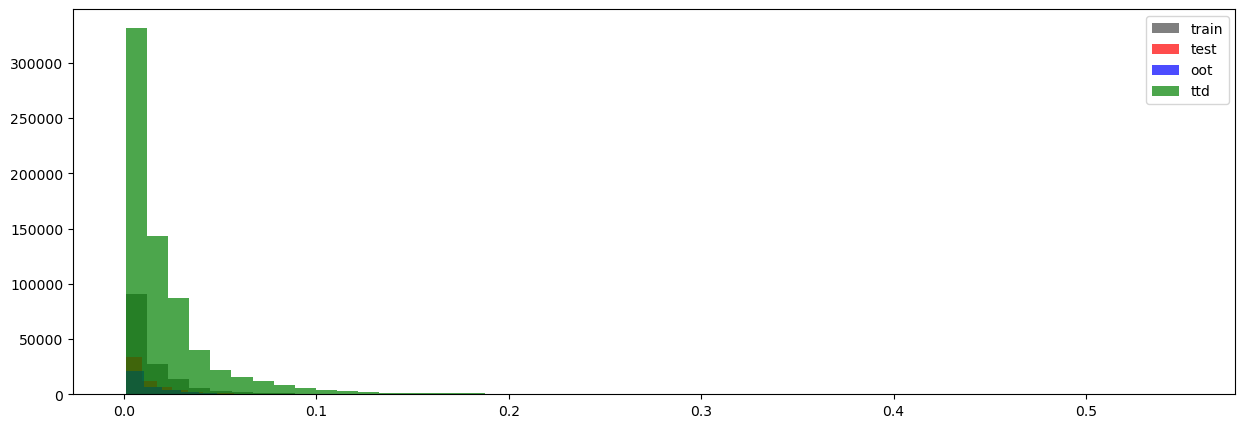

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [122]:
Train['p1'].value_counts(dropna= False).head()

p1
0.022125    16
0.038920    15
0.017099    14
0.044098    14
0.019147    10
Name: count, dtype: int64

In [89]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
0       141943
1         4543
2          337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
0       60829
1        1941
2         157
[-1]       11
Name: count, dtype: int64


In [103]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [106]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,0,1606.0,0.029652,0.030110,54162,691.0,0.029889,0.030257,23119,Yes
1,assetownership,1,621.0,0.006700,0.006994,92693,268.0,0.006730,0.007008,39819,Yes


inquiryauto12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryauto12month,0,1496.0,0.011491,0.011888,130194,647.0,0.011612,0.011898,55716,Yes
1,inquiryauto12month,1,731.0,0.043875,0.043896,16661,312.0,0.043201,0.043708,7222,Yes


inquiryshortterm12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryshortterm12month,0,2005.0,0.013959,0.014413,143630,882.0,0.014330,0.014471,61551,Yes
1,inquiryshortterm12month,1,222.0,0.068837,0.064774,3225,77.0,0.055516,0.063345,1387,Yes


sourcenonderogcount12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.023777,73094,726.0,0.023263,0.023867,31209,Yes
1,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.007337,73761,233.0,0.007343,0.007366,31729,Yes


assetpropevercount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.030605,50788,663.0,0.030656,0.030744,21627,Yes
1,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.008492,51963,204.0,0.009101,0.008565,22414,Yes
2,assetpropevercount,"[2.0, 3.0)",155.0,0.006657,0.006804,23283,57.0,0.005765,0.006833,9887,Yes
3,assetpropevercount,"[3.0, inf)",101.0,0.004851,0.006006,20821,35.0,0.003885,0.006005,9010,Yes


inquirytelcom12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquirytelcom12month,0,2085.0,0.014427,0.014841,144522,903.0,0.014573,0.014921,61963,Yes
1,inquirytelcom12month,1,142.0,0.060866,0.057525,2333,56.0,0.057436,0.055361,975,Yes


sourcenonderogcount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,sourcenonderogcount,"[-inf, 2.0)",688.0,0.038354,0.037519,17938,285.0,0.037023,0.037636,7698,Yes
1,sourcenonderogcount,"[2.0, 3.0)",910.0,0.020303,0.020224,44820,387.0,0.020376,0.020107,18993,Yes
2,sourcenonderogcount,"[3.0, 4.0)",447.0,0.010643,0.010852,41999,186.0,0.010221,0.011128,18197,Yes
3,sourcenonderogcount,"[4.0, 5.0)",131.0,0.005257,0.006308,24917,78.0,0.007257,0.006328,10748,Yes
4,sourcenonderogcount,"[5.0, inf)",51.0,0.002968,0.005044,17181,23.0,0.003150,0.004988,7302,Yes


addrlastmovetaxratiodiff


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrlastmovetaxratiodiff,[-1],1285.0,0.011758,0.012091,109291,521.0,0.011148,0.012057,46734,NaN
1,addrlastmovetaxratiodiff,"[-inf, 0.166)",933.0,0.025907,0.026303,36013,435.0,0.027999,0.026447,15536,Yes
2,addrlastmovetaxratiodiff,"[0.166, inf)",9.0,0.005803,0.006699,1551,3.0,0.004491,0.006261,668,Yes


inquirynonshortterm12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquirynonshortterm12month,0,1156.0,0.010679,0.011003,108246,495.0,0.010692,0.011058,46295,Yes
1,inquirynonshortterm12month,1,1071.0,0.027740,0.028180,38609,464.0,0.027880,0.028036,16643,Yes


addrcurrenttaxmarketvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrenttaxmarketvalue,"[-inf, 9000.0)",1859.0,0.023741,0.023863,78302,803.0,0.024035,0.023962,33410,Yes
3,addrcurrenttaxmarketvalue,"[9000.0, 137900.0)",148.0,0.008577,0.007888,17255,55.0,0.007348,0.008079,7485,Yes
1,addrcurrenttaxmarketvalue,"[137900.0, 294500.0)",146.0,0.004674,0.005824,31236,71.0,0.005285,0.005801,13435,Yes
2,addrcurrenttaxmarketvalue,"[294500.0, inf)",74.0,0.003689,0.004614,20062,30.0,0.003485,0.004597,8608,Yes


derogtimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,derogtimenewest,[-1],1769.0,0.013490,0.014005,131135,777.0,0.013879,0.013957,55984,NaN
1,derogtimenewest,"[-inf, 12.0)",74.0,0.044686,0.044680,1656,27.0,0.036096,0.045033,748,No
2,derogtimenewest,"[12.0, 22.0)",59.0,0.033485,0.029906,1762,35.0,0.045812,0.032247,764,No
3,derogtimenewest,"[22.0, 45.0)",135.0,0.031337,0.029920,4308,53.0,0.028789,0.028912,1841,No
4,derogtimenewest,"[45.0, 54.0)",54.0,0.031597,0.026392,1709,13.0,0.016189,0.025533,803,No
5,derogtimenewest,"[54.0, 76.0)",104.0,0.024988,0.023922,4162,37.0,0.019807,0.024385,1868,No
6,derogtimenewest,"[76.0, inf)",32.0,0.015073,0.019899,2123,17.0,0.018280,0.021069,930,No


addrcurrentcountyratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentcountyratio,"[-inf, 0.55)",1105.0,0.023242,0.023234,47544,482.0,0.023580,0.023301,20441,No
1,addrcurrentcountyratio,"[0.55, 0.89)",489.0,0.018098,0.017981,27020,166.0,0.014384,0.017834,11541,No
2,addrcurrentcountyratio,"[0.89, 1.05)",219.0,0.012414,0.012897,17642,113.0,0.015368,0.012951,7353,No
3,addrcurrentcountyratio,"[1.05, 1.37)",233.0,0.009470,0.010334,24604,108.0,0.010126,0.010379,10666,No
4,addrcurrentcountyratio,"[1.37, inf)",181.0,0.006024,0.006884,30045,90.0,0.006957,0.006997,12937,No


addrinputtaxvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtaxvalue,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
1,addrinputtaxvalue,"[-inf, 518.0)",1852.0,0.024089,0.024223,76881,800.0,0.024412,0.024354,32771.0,Yes
3,addrinputtaxvalue,"[518.0, 246800.0)",290.0,0.005761,0.006261,50342,123.0,0.005642,0.006291,21802.0,Yes
2,addrinputtaxvalue,"[246800.0, inf)",85.0,0.004330,0.005176,19631,36.0,0.004304,0.005177,8365.0,Yes


criminalfelonytimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,criminalfelonytimenewest,[-1],2200.0,0.015012,0.015434,146551,944.0,0.015039,0.015440,62769,NaN
1,criminalfelonytimenewest,"[-inf, 31.0)",10.0,0.185185,0.060096,54,2.0,0.068966,0.061619,29,No
2,criminalfelonytimenewest,"[31.0, 62.0)",12.0,0.106195,0.061922,113,8.0,0.091954,0.056866,87,No
3,criminalfelonytimenewest,"[62.0, 69.0)",2.0,0.057143,0.063496,35,2.0,0.111111,0.053603,18,No
4,criminalfelonytimenewest,"[69.0, 76.0)",2.0,0.052632,0.050065,38,2.0,0.086957,0.054433,23,No
5,criminalfelonytimenewest,"[76.0, inf)",1.0,0.015625,0.043705,64,1.0,0.083333,0.038431,12,No


criminalnonfelonycount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,criminalnonfelonycount,"[-inf, 0.0164)",2139.0,0.014747,0.015159,145046,917.0,0.014763,0.015150,62116,Yes
1,criminalnonfelonycount,"[0.0164, inf)",88.0,0.048646,0.044408,1809,42.0,0.051095,0.045655,822,Yes


addrinputcountyratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputcountyratio,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
1,addrinputcountyratio,"[-inf, 0.55)",1174.0,0.023216,0.023445,50569,526.0,0.024085,0.023500,21839.0,Yes
2,addrinputcountyratio,"[0.55, 0.85)",414.0,0.017987,0.017612,23016,140.0,0.014331,0.017448,9769.0,Yes
3,addrinputcountyratio,"[0.85, 1.01)",221.0,0.013945,0.013589,15848,86.0,0.012973,0.013436,6629.0,Yes
4,addrinputcountyratio,"[1.01, 1.32)",235.0,0.009072,0.010043,25904,114.0,0.010360,0.010190,11004.0,Yes
5,addrinputcountyratio,"[1.32, inf)",183.0,0.005806,0.006746,31517,93.0,0.006790,0.006840,13697.0,Yes


sourcevoterregistration


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,sourcevoterregistration,0,1841.0,0.018655,0.018896,98685,782.0,0.018571,0.018994,42109,Yes
1,sourcevoterregistration,1,386.0,0.008013,0.008601,48170,177.0,0.008498,0.008581,20829,Yes


evictiontimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,evictiontimenewest,[-1],2182.0,0.014913,0.015364,146315,938.0,0.014964,0.015389,62684,NaN
1,evictiontimenewest,"[-inf, 8.0)",7.0,0.152174,0.094009,46,3.0,0.142857,0.101148,21,No
4,evictiontimenewest,"[8.0, 17.0)",7.0,0.142857,0.078401,49,4.0,0.153846,0.075833,26,No
2,evictiontimenewest,"[17.0, 64.0)",25.0,0.083056,0.053732,301,9.0,0.069231,0.053303,130,No
3,evictiontimenewest,"[64.0, inf)",6.0,0.041667,0.047426,144,5.0,0.064935,0.037821,77,No


addrinputavmvalue12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputavmvalue12month,[-1],979.0,0.020969,0.021537,46689,444.0,0.022069,0.021765,20119,NaN
1,addrinputavmvalue12month,"[-inf, 84269.0)",264.0,0.024506,0.023304,10773,115.0,0.024935,0.023381,4612,No
7,addrinputavmvalue12month,"[84269.0, 130000.0)",153.0,0.012800,0.013869,11953,85.0,0.016365,0.013751,5194,No
2,addrinputavmvalue12month,"[130000.0, 201863.0)",295.0,0.012450,0.012736,23694,112.0,0.011119,0.012618,10073,No
3,addrinputavmvalue12month,"[201863.0, 256476.0)",186.0,0.012257,0.012121,15175,79.0,0.012222,0.012066,6464,No
4,addrinputavmvalue12month,"[256476.0, 313290.0)",137.0,0.011772,0.011149,11638,43.0,0.008912,0.011029,4825,No
5,addrinputavmvalue12month,"[313290.0, 433378.0)",144.0,0.009685,0.009579,14869,58.0,0.009002,0.009507,6443,No
6,addrinputavmvalue12month,"[433378.0, inf)",69.0,0.005719,0.008192,12064,23.0,0.004416,0.008034,5208,No


addrprevioustimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrprevioustimeoldest,[-1],258.0,0.027989,0.026973,9218,107.0,0.026804,0.026595,3992,NaN
1,addrprevioustimeoldest,"[-inf, 22.0)",373.0,0.032345,0.031379,11532,193.0,0.039388,0.031057,4900,Yes
4,addrprevioustimeoldest,"[22.0, 57.0)",540.0,0.022948,0.023241,23531,223.0,0.021762,0.023615,10247,Yes
6,addrprevioustimeoldest,"[57.0, 89.0)",303.0,0.016563,0.016162,18294,121.0,0.015268,0.016025,7925,Yes
7,addrprevioustimeoldest,"[89.0, 136.0)",269.0,0.013041,0.013302,20628,97.0,0.011233,0.013592,8635,Yes
2,addrprevioustimeoldest,"[136.0, 190.0)",190.0,0.009015,0.010485,21077,93.0,0.010407,0.010398,8936,Yes
3,addrprevioustimeoldest,"[190.0, 247.0)",148.0,0.008805,0.009461,16808,58.0,0.008129,0.009575,7135,Yes
5,addrprevioustimeoldest,"[247.0, inf)",146.0,0.005666,0.006662,25767,67.0,0.005999,0.006503,11168,Yes


addrinputtimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtimenewest,[-1],447.0,0.030971,0.030914,14433,193.0,0.030796,0.030473,6267,NaN
1,addrinputtimenewest,"[-inf, 2.581)",1694.0,0.013370,0.013645,126699,722.0,0.013298,0.013701,54293,Yes
2,addrinputtimenewest,"[2.581, inf)",86.0,0.015027,0.018202,5723,44.0,0.018503,0.018391,2378,Yes


educationinstitutionrating


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,educationinstitutionrating,0,2125.0,0.016227,0.016431,130954,913.0,0.016275,0.016464,56099,No
1,educationinstitutionrating,1,1.0,0.003425,0.006937,292,0.0,0.000000,0.005727,115,No
2,educationinstitutionrating,2,12.0,0.006608,0.006443,1816,4.0,0.004969,0.006781,805,No
3,educationinstitutionrating,3,20.0,0.004032,0.006311,4960,7.0,0.003239,0.006175,2161,No
4,educationinstitutionrating,4,23.0,0.005185,0.008080,4436,7.0,0.003763,0.007534,1860,No
5,educationinstitutionrating,5,24.0,0.008466,0.009956,2835,13.0,0.010673,0.010532,1218,No
6,educationinstitutionrating,6,22.0,0.014085,0.011678,1562,15.0,0.022059,0.012671,680,No


educationinstitutionprivate


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,educationinstitutionprivate,[-1],2071.0,0.016311,0.016537,126970,897.0,0.016498,0.016574,54369,NaN
1,educationinstitutionprivate,"[-inf, 0.0885)",138.0,0.007613,0.009133,18126,57.0,0.007305,0.009154,7803,No
2,educationinstitutionprivate,"[0.0885, inf)",18.0,0.010233,0.007851,1759,5.0,0.006527,0.007843,766,No


addrcurrentavmvalue60month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentavmvalue60month,[-1],1054.0,0.018427,0.019005,57199,438.0,0.017970,0.018992,24374,NaN
1,addrcurrentavmvalue60month,"[-inf, 69000.0)",205.0,0.024457,0.022761,8382,79.0,0.021944,0.023000,3600,Yes
6,addrcurrentavmvalue60month,"[69000.0, 157202.0)",401.0,0.014413,0.014425,27823,203.0,0.016952,0.014404,11975,Yes
2,addrcurrentavmvalue60month,"[157202.0, 190129.0)",152.0,0.013756,0.013553,11050,70.0,0.015051,0.014022,4651,Yes
3,addrcurrentavmvalue60month,"[190129.0, 246900.0)",179.0,0.013013,0.012256,13755,64.0,0.010907,0.012131,5868,Yes
4,addrcurrentavmvalue60month,"[246900.0, 364000.0)",153.0,0.009481,0.010852,16137,73.0,0.010389,0.011040,7027,Yes
5,addrcurrentavmvalue60month,"[364000.0, inf)",83.0,0.006635,0.008508,12509,32.0,0.005879,0.008520,5443,Yes


addrinputlengthofres


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputlengthofres,[-1],447.0,0.030941,0.030920,14447,193.0,0.030757,0.030457,6275,NaN
1,addrinputlengthofres,"[-inf, 9.0)",356.0,0.025234,0.025689,14108,178.0,0.029573,0.026330,6019,Yes
7,addrinputlengthofres,"[9.0, 31.0)",454.0,0.018222,0.018390,24915,196.0,0.018547,0.018410,10568,Yes
5,addrinputlengthofres,"[31.0, 48.0)",208.0,0.015821,0.015866,13147,80.0,0.014099,0.016123,5674,Yes
6,addrinputlengthofres,"[48.0, 113.0)",352.0,0.012567,0.012865,28010,148.0,0.012345,0.012900,11989,Yes
2,addrinputlengthofres,"[113.0, 166.0)",168.0,0.010950,0.010726,15342,72.0,0.010976,0.010352,6560,Yes
3,addrinputlengthofres,"[166.0, 244.0)",129.0,0.007118,0.008095,18123,54.0,0.007029,0.008222,7683,Yes
4,addrinputlengthofres,"[244.0, inf)",113.0,0.006022,0.007013,18763,38.0,0.004651,0.006998,8170,Yes


addrchangecount03month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrchangecount03month,"[-inf, 0.0404)",2044.0,0.014493,0.014963,141034,876.0,0.014510,0.014946,60372,Yes
1,addrchangecount03month,"[0.0404, inf)",183.0,0.031438,0.028993,5821,83.0,0.032346,0.029708,2566,Yes


bankruptcytimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,bankruptcytimenewest,[-1],2128.0,0.014992,0.015323,141943,928.0,0.015256,0.015363,60829,NaN
1,bankruptcytimenewest,"[-inf, 22.0)",23.0,0.040210,0.034513,572,7.0,0.030435,0.037447,230,No
2,bankruptcytimenewest,"[22.0, 40.0)",27.0,0.028541,0.025855,946,5.0,0.012788,0.024113,391,No
3,bankruptcytimenewest,"[40.0, 49.0)",12.0,0.021858,0.022172,549,6.0,0.022472,0.021600,267,No
4,bankruptcytimenewest,"[49.0, 58.0)",11.0,0.017713,0.018998,621,2.0,0.007576,0.016840,264,No
5,bankruptcytimenewest,"[58.0, 68.0)",9.0,0.013333,0.018026,675,4.0,0.013746,0.016604,291,No
6,bankruptcytimenewest,"[68.0, inf)",17.0,0.010975,0.015343,1549,7.0,0.010511,0.016416,666,No


lienjudgmenttimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,lienjudgmenttimenewest,[-1],1963.0,0.014278,0.014708,137482,860.0,0.014621,0.014686,58818,NaN
1,lienjudgmenttimenewest,"[-inf, 12.0)",49.0,0.037178,0.040027,1318,17.0,0.028814,0.038224,590,No
2,lienjudgmenttimenewest,"[12.0, 75.0)",196.0,0.028080,0.025763,6980,70.0,0.022853,0.026456,3063,No
3,lienjudgmenttimenewest,"[75.0, inf)",19.0,0.017674,0.022722,1075,12.0,0.025696,0.023976,467,No


addrlastmoveecontrajectory


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrlastmoveecontrajectory,0,173.0,0.027609,0.028065,6266,70.0,0.026227,0.027092,2669,No
1,addrlastmoveecontrajectory,1,755.0,0.010280,0.010491,73447,294.0,0.009319,0.010490,31550,No
5,addrlastmoveecontrajectory,2,104.0,0.035040,0.038205,2968,53.0,0.042063,0.036699,1260,No
6,addrlastmoveecontrajectory,3,154.0,0.030061,0.032698,5123,69.0,0.031724,0.034471,2175,No
7,addrlastmoveecontrajectory,4,196.0,0.021397,0.022553,9160,109.0,0.027000,0.023213,4037,No
8,addrlastmoveecontrajectory,5,11.0,0.033133,0.031096,332,6.0,0.039735,0.030892,151,No
9,addrlastmoveecontrajectory,6,9.0,0.016484,0.023344,546,6.0,0.025105,0.024720,239,No
10,addrlastmoveecontrajectory,7,12.0,0.045455,0.034015,264,3.0,0.030000,0.029746,100,No
11,addrlastmoveecontrajectory,8,189.0,0.024703,0.024403,7651,92.0,0.028066,0.023692,3278,No
12,addrlastmoveecontrajectory,9,148.0,0.015957,0.017460,9275,68.0,0.017672,0.017750,3848,No


educationevidence


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,educationevidence,0,2026.0,0.016649,0.016872,121690,877.0,0.016857,0.016928,52025,Yes
1,educationevidence,1,201.0,0.007987,0.008981,25165,82.0,0.007514,0.008970,10913,Yes


assetpropcurrenttaxtotal


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropcurrenttaxtotal,[-1],1622.0,0.028825,0.029384,56271,702.0,0.029266,0.029565,23987,NaN
1,assetpropcurrenttaxtotal,"[-inf, 5700.0)",100.0,0.011682,0.008648,8560,29.0,0.008035,0.008636,3609,No
4,assetpropcurrenttaxtotal,"[5700.0, 15977.0)",68.0,0.007582,0.008075,8969,36.0,0.009397,0.007924,3831,No
2,assetpropcurrenttaxtotal,"[15977.0, 324300.0)",370.0,0.006771,0.006927,54648,160.0,0.006771,0.006957,23630,No
3,assetpropcurrenttaxtotal,"[324300.0, inf)",67.0,0.003640,0.005467,18407,32.0,0.004060,0.005514,7881,No


assetpropsaletimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropsaletimenewest,[-1],2012.0,0.017065,0.017289,117902,874.0,0.017312,0.017306,50485,NaN
1,assetpropsaletimenewest,"[-inf, 52.0)",60.0,0.006139,0.008341,9773,23.0,0.005431,0.008337,4235,No
3,assetpropsaletimenewest,"[52.0, 101.0)",41.0,0.007770,0.008927,5277,19.0,0.008017,0.009333,2370,No
2,assetpropsaletimenewest,"[101.0, inf)",114.0,0.008200,0.008058,13903,43.0,0.007353,0.008112,5848,No


criminalnonfelonytimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,criminalnonfelonytimenewest,[-1],2139.0,0.014747,0.015159,145043,917.0,0.014763,0.015150,62116,NaN
1,criminalnonfelonytimenewest,"[-inf, 36.0)",36.0,0.068702,0.053523,524,16.0,0.068376,0.055340,234,No
2,criminalnonfelonytimenewest,"[36.0, 47.0)",13.0,0.050388,0.046304,258,8.0,0.070796,0.041015,113,No
3,criminalnonfelonytimenewest,"[47.0, 76.0)",34.0,0.043702,0.040882,778,13.0,0.036011,0.043373,361,No
4,criminalnonfelonytimenewest,"[76.0, inf)",5.0,0.019841,0.034289,252,5.0,0.043860,0.037599,114,No


businessassociationtimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,businessassociationtimeoldest,[-1],2153.0,0.015904,0.016124,135376,929.0,0.016003,0.016156,58053,NaN
1,businessassociationtimeoldest,"[-inf, 15.0)",13.0,0.009601,0.010975,1354,5.0,0.008576,0.011071,583,No
3,businessassociationtimeoldest,"[15.0, 77.0)",40.0,0.007967,0.008998,5021,14.0,0.006721,0.009093,2083,No
5,businessassociationtimeoldest,"[77.0, 100.0)",11.0,0.007448,0.007678,1477,5.0,0.007622,0.008002,656,No
2,businessassociationtimeoldest,"[100.0, 152.0)",5.0,0.003644,0.007385,1372,3.0,0.004910,0.007018,611,No
4,businessassociationtimeoldest,"[152.0, inf)",5.0,0.002217,0.006541,2255,3.0,0.003151,0.006002,952,No


inquirycollections12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquirycollections12month,0,2214.0,0.015118,0.015490,146447,950.0,0.015136,0.015514,62765,Yes
1,inquirycollections12month,1,13.0,0.031863,0.025996,408,9.0,0.052023,0.027699,173,Yes


inquirybanking12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquirybanking12month,0,1652.0,0.013528,0.013914,122121,714.0,0.013643,0.013981,52334,Yes
1,inquirybanking12month,1,575.0,0.023247,0.023444,24734,245.0,0.023104,0.023282,10604,Yes


addrchangecount24month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrchangecount24month,"[-inf, 1.0)",1297.0,0.012167,0.012559,106598,527.0,0.011534,0.012527,45691,Yes
1,addrchangecount24month,"[1.0, inf)",930.0,0.023102,0.023359,40257,432.0,0.025048,0.023551,17247,Yes


addrinputsubjectcount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputsubjectcount,[-1],500.0,0.029911,0.030044,16716,223.0,0.031102,0.030353,7170,NaN
1,addrinputsubjectcount,"[-inf, 1.0)",345.0,0.015958,0.016836,21619,162.0,0.017622,0.017055,9193,Yes
2,addrinputsubjectcount,"[1.0, 2.0)",392.0,0.015883,0.015412,24680,156.0,0.014905,0.015409,10466,Yes
3,addrinputsubjectcount,"[2.0, inf)",990.0,0.011808,0.012315,83840,418.0,0.011576,0.012265,36109,Yes


addrcurrentavmvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentavmvalue,[-1],844.0,0.022901,0.023129,36854,365.0,0.023125,0.023321,15784,NaN
1,addrcurrentavmvalue,"[-inf, 90271.0)",252.0,0.023340,0.023065,10797,101.0,0.021609,0.022545,4674,Yes
6,addrcurrentavmvalue,"[90271.0, 143000.0)",202.0,0.015346,0.014814,13163,105.0,0.018760,0.014826,5597,Yes
2,addrcurrentavmvalue,"[143000.0, 238752.0)",393.0,0.012777,0.013312,30759,166.0,0.012581,0.013234,13194,Yes
3,addrcurrentavmvalue,"[238752.0, 296257.0)",187.0,0.011688,0.011676,15999,75.0,0.011073,0.011615,6773,Yes
4,addrcurrentavmvalue,"[296257.0, 385000.0)",182.0,0.010687,0.010790,17030,66.0,0.009144,0.011014,7218,Yes
5,addrcurrentavmvalue,"[385000.0, inf)",167.0,0.007505,0.009106,22253,81.0,0.008352,0.009211,9698,Yes


derogcount12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,derogcount12month,"[-inf, 0.0141)",2150.0,0.014825,0.015174,145029,926.0,0.014909,0.015165,62112,Yes
1,derogcount12month,"[0.0141, inf)",77.0,0.042169,0.042968,1826,33.0,0.039952,0.044324,826,Yes


addrinputlastsaleprice


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputlastsaleprice,[-1],1896.0,0.021814,0.022134,86917,827.0,0.022325,0.022274,37043,NaN
1,addrinputlastsaleprice,"[-inf, 68000.0)",65.0,0.007624,0.007275,8526,21.0,0.005679,0.007306,3698,No
5,addrinputlastsaleprice,"[68000.0, 120570.0)",66.0,0.007378,0.006728,8946,22.0,0.005796,0.006714,3796,No
2,addrinputlastsaleprice,"[120570.0, 208000.0)",86.0,0.005290,0.005968,16258,47.0,0.006498,0.005910,7233,No
3,addrinputlastsaleprice,"[208000.0, 349001.0)",73.0,0.004712,0.005590,15494,32.0,0.004857,0.005614,6589,No
4,addrinputlastsaleprice,"[349001.0, inf)",41.0,0.003827,0.004609,10714,10.0,0.002184,0.004630,4579,No


assetpersonal


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpersonal,0,2175.0,0.016274,0.016462,133649,932.0,0.016262,0.016479,57311,Yes
1,assetpersonal,1,52.0,0.003938,0.005977,13206,27.0,0.004798,0.006066,5627,Yes


bankruptcydismissed24month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,bankruptcydismissed24month,"[-inf, 0.000184)",2225.0,0.015154,0.015515,146828,958.0,0.015226,0.015543,62920,Yes
1,bankruptcydismissed24month,"[0.000184, inf)",2.0,0.074074,0.038414,27,1.0,0.055556,0.033760,18,Yes


addrpreviouslengthofres


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrpreviouslengthofres,[-1],258.0,0.027989,0.026973,9218,107.0,0.026804,0.026595,3992,NaN
1,addrpreviouslengthofres,"[-inf, 23.0)",737.0,0.020830,0.020684,35381,335.0,0.021930,0.020431,15276,Yes
3,addrpreviouslengthofres,"[23.0, 46.0)",421.0,0.018870,0.019476,22311,164.0,0.017182,0.019901,9545,Yes
4,addrpreviouslengthofres,"[46.0, 64.0)",190.0,0.013831,0.014802,13737,91.0,0.015690,0.015005,5800,Yes
5,addrpreviouslengthofres,"[64.0, 87.0)",176.0,0.012547,0.012889,14027,65.0,0.010769,0.012977,6036,Yes
6,addrpreviouslengthofres,"[87.0, 126.0)",168.0,0.009974,0.010994,16844,73.0,0.010439,0.011046,6993,Yes
2,addrpreviouslengthofres,"[126.0, inf)",277.0,0.007839,0.008342,35337,124.0,0.008107,0.008351,15296,Yes


bankruptcystatus


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
3,bankruptcystatus,[-1],2.0,0.062500,0.036129,32,0.0,0.000000,0.026141,11,NaN
0,bankruptcystatus,0,2128.0,0.014992,0.015323,141943,928.0,0.015256,0.015363,60829,No
1,bankruptcystatus,1,84.0,0.018490,0.020496,4543,27.0,0.013910,0.020347,1941,No
2,bankruptcystatus,2,13.0,0.038576,0.029185,337,4.0,0.025478,0.026997,157,No


addrchangecount06month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrchangecount06month,"[-inf, 0.0865)",1890.0,0.014032,0.014424,134696,796.0,0.013807,0.014363,57650,Yes
1,addrchangecount06month,"[0.0865, inf)",337.0,0.027716,0.027654,12159,163.0,0.030825,0.028471,5288,Yes


lienjudgmenttaxcount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,lienjudgmenttaxcount,"[-inf, 0.0643)",2081.0,0.014746,0.015146,141119,904.0,0.014971,0.015143,60384,Yes
1,lienjudgmenttaxcount,"[0.0643, inf)",146.0,0.025453,0.024693,5736,55.0,0.021535,0.025117,2554,Yes


addrinputtimelastsale


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtimelastsale,[-1],1947.0,0.019907,0.020304,97803,845.0,0.020190,0.020339,41852,NaN
1,addrinputtimelastsale,"[-inf, 9.0)",55.0,0.011179,0.008144,4920,19.0,0.009291,0.008277,2045,Yes
3,addrinputtimelastsale,"[9.0, 162.0)",189.0,0.005514,0.005843,34278,77.0,0.005163,0.005884,14915,Yes
2,addrinputtimelastsale,"[162.0, inf)",36.0,0.003653,0.005370,9854,18.0,0.004363,0.005488,4126,Yes


assetpropnewestsaleprice


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropnewestsaleprice,[-1],2047.0,0.016827,0.017032,121649,884.0,0.016972,0.017045,52087,NaN
1,assetpropnewestsaleprice,"[-inf, 108000.0)",57.0,0.010839,0.009211,5259,21.0,0.009346,0.009080,2247,No
2,assetpropnewestsaleprice,"[108000.0, 155000.0)",39.0,0.008186,0.008441,4764,12.0,0.005731,0.008192,2094,No
3,assetpropnewestsaleprice,"[155000.0, 384900.0)",67.0,0.005570,0.008018,12029,37.0,0.007238,0.008451,5112,No
4,assetpropnewestsaleprice,"[384900.0, inf)",17.0,0.005390,0.007000,3154,5.0,0.003577,0.007123,1398,No


addrinputdeedmailing


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
2,addrinputdeedmailing,[-1],648.0,0.027311,0.027543,23727,261.0,0.025626,0.027836,10185,NaN
0,addrinputdeedmailing,0,1132.0,0.011171,0.011486,101337,482.0,0.011087,0.011455,43474,Yes
1,addrinputdeedmailing,1,447.0,0.020513,0.021185,21791,216.0,0.023278,0.021236,9279,Yes


addrcurrenttimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrenttimeoldest,[-1],20.0,0.031546,0.027841,634,17.0,0.053628,0.028572,317,NaN
1,addrcurrenttimeoldest,"[-inf, 17.0)",605.0,0.024887,0.024951,24310,266.0,0.025491,0.025364,10435,Yes
3,addrcurrenttimeoldest,"[17.0, 36.0)",413.0,0.019365,0.019958,21327,192.0,0.021036,0.019766,9127,Yes
5,addrcurrenttimeoldest,"[36.0, 55.0)",252.0,0.016453,0.017431,15316,98.0,0.015089,0.017496,6495,Yes
6,addrcurrenttimeoldest,"[55.0, 99.0)",349.0,0.015572,0.015220,22412,146.0,0.015078,0.015335,9683,Yes
7,addrcurrenttimeoldest,"[99.0, 165.0)",284.0,0.012847,0.012540,22106,112.0,0.011948,0.012157,9374,Yes
2,addrcurrenttimeoldest,"[165.0, 242.0)",169.0,0.008430,0.009189,20048,73.0,0.008596,0.009261,8492,Yes
4,addrcurrenttimeoldest,"[242.0, inf)",135.0,0.006521,0.007716,20702,55.0,0.006101,0.007731,9015,Yes


bankruptcychapter


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
3,bankruptcychapter,[-1],0.0,0.000000,0.021166,3,NaN,NaN,NaN,NaN,NaN
0,bankruptcychapter,0,2128.0,0.014992,0.015323,141943,928.0,0.015256,0.015363,60829.0,No
1,bankruptcychapter,1,82.0,0.021978,0.021587,3731,24.0,0.015094,0.021149,1590.0,No
2,bankruptcychapter,2,17.0,0.014431,0.019949,1178,7.0,0.013487,0.020025,519.0,No


assetpropnewestmortgagetype


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
3,assetpropnewestmortgagetype,[-1],1802.0,0.024644,0.024976,73120,777.0,0.024930,0.025107,31167,NaN
0,assetpropnewestmortgagetype,0,395.0,0.005606,0.006145,70461,172.0,0.005679,0.006177,30289,No
1,assetpropnewestmortgagetype,1,10.0,0.008058,0.006390,1241,4.0,0.007634,0.006208,524,No
2,assetpropnewestmortgagetype,2,20.0,0.009838,0.005891,2033,6.0,0.006263,0.005938,958,No


addrinputtaxmarketvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtaxmarketvalue,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
1,addrinputtaxmarketvalue,"[-inf, 4900.0)",1857.0,0.023887,0.024028,77742,803.0,0.024212,0.024145,33166.0,Yes
4,addrinputtaxmarketvalue,"[4900.0, 131500.0)",136.0,0.008489,0.007992,16020,43.0,0.006270,0.008109,6858.0,Yes
2,addrinputtaxmarketvalue,"[131500.0, 299200.0)",164.0,0.004940,0.005784,33201,88.0,0.006137,0.005801,14340.0,Yes
3,addrinputtaxmarketvalue,"[299200.0, inf)",70.0,0.003519,0.004578,19891,25.0,0.002916,0.004545,8574.0,Yes


lienjudgmentcourtcount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,lienjudgmentcourtcount,"[-inf, 0.0185)",2158.0,0.014911,0.015323,144725,933.0,0.015048,0.015324,62000,Yes
1,lienjudgmentcourtcount,"[0.0185, inf)",69.0,0.032394,0.028888,2130,26.0,0.027719,0.030339,938,Yes


addrcurrentlengthofres


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentlengthofres,[-1],20.0,0.031546,0.027841,634,17.0,0.053628,0.028572,317,NaN
1,addrcurrentlengthofres,"[-inf, 9.0)",427.0,0.025943,0.026479,16459,198.0,0.028117,0.026948,7042,Yes
6,addrcurrentlengthofres,"[9.0, 20.0)",342.0,0.022052,0.021651,15509,148.0,0.022179,0.022050,6673,Yes
3,addrcurrentlengthofres,"[20.0, 35.0)",315.0,0.019240,0.019659,16372,139.0,0.019900,0.019089,6985,Yes
5,addrcurrentlengthofres,"[35.0, 98.0)",586.0,0.015703,0.015763,37318,239.0,0.014919,0.015920,16020,Yes
7,addrcurrentlengthofres,"[98.0, 166.0)",262.0,0.011815,0.012169,22175,110.0,0.011776,0.011714,9341,Yes
2,addrcurrentlengthofres,"[166.0, 242.0)",144.0,0.007675,0.008760,18762,64.0,0.008010,0.008883,7990,Yes
4,addrcurrentlengthofres,"[242.0, inf)",131.0,0.006675,0.007416,19626,44.0,0.005134,0.007447,8570,Yes


addrinputavmvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputavmvalue,[-1],923.0,0.022958,0.023371,40203,407.0,0.023420,0.023582,17378,NaN
1,addrinputavmvalue,"[-inf, 97283.0)",269.0,0.023341,0.022530,11525,115.0,0.023028,0.022218,4994,Yes
7,addrinputavmvalue,"[97283.0, 140226.0)",152.0,0.014501,0.014412,10482,89.0,0.019937,0.014434,4464,Yes
2,addrinputavmvalue,"[140226.0, 220644.0)",310.0,0.012369,0.012738,25063,127.0,0.011925,0.012645,10650,Yes
3,addrinputavmvalue,"[220644.0, 280500.0)",201.0,0.011833,0.011917,16986,72.0,0.009971,0.011811,7221,Yes
4,addrinputavmvalue,"[280500.0, 363171.0)",183.0,0.010568,0.010635,17317,69.0,0.009475,0.010683,7282,Yes
5,addrinputavmvalue,"[363171.0, 466923.0)",102.0,0.008109,0.009325,12579,42.0,0.007756,0.009189,5415,Yes
6,addrinputavmvalue,"[466923.0, inf)",87.0,0.006850,0.008318,12700,38.0,0.006867,0.008285,5534,Yes


addrcurrentblockratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentblockratio,"[-inf, 0.11)",850.0,0.022776,0.023083,37320,367.0,0.022991,0.023297,15963,Yes
1,addrcurrentblockratio,"[0.11, 0.71)",320.0,0.021489,0.020787,14891,122.0,0.018979,0.020671,6428,Yes
2,addrcurrentblockratio,"[0.71, 0.88)",240.0,0.014376,0.015450,16694,114.0,0.016134,0.015544,7066,Yes
3,addrcurrentblockratio,"[0.88, 1.02)",275.0,0.013014,0.013795,21131,130.0,0.013978,0.013753,9300,Yes
4,addrcurrentblockratio,"[1.02, 1.41)",379.0,0.010579,0.010978,35826,157.0,0.010325,0.010798,15206,Yes
5,addrcurrentblockratio,"[1.41, inf)",163.0,0.007764,0.007878,20993,69.0,0.007688,0.008006,8975,Yes


proflictypecategory


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
6,proflictypecategory,[-1],2134.0,0.015735,0.016160,135620,915.0,0.015759,0.016227,58063,NaN
0,proflictypecategory,0,19.0,0.012726,0.008501,1493,5.0,0.008197,0.007534,610,No
1,proflictypecategory,1,24.0,0.012612,0.010891,1903,13.0,0.015187,0.010170,856,No
2,proflictypecategory,2,22.0,0.007085,0.008750,3105,13.0,0.009977,0.008655,1303,No
3,proflictypecategory,3,27.0,0.008815,0.006335,3063,11.0,0.008088,0.006002,1360,No
4,proflictypecategory,4,0.0,0.000000,0.004677,997,1.0,0.002227,0.005289,449,No
5,proflictypecategory,5,1.0,0.001484,0.004281,674,1.0,0.003367,0.004234,297,No


lienjudgmentsmallclaimscount


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,lienjudgmentsmallclaimscount,"[-inf, 0.0169)",2157.0,0.014891,0.015242,144848,937.0,0.015096,0.015262,62071,Yes
1,lienjudgmentsmallclaimscount,"[0.0169, inf)",70.0,0.034878,0.035527,2007,22.0,0.025375,0.036045,867,Yes


addrcurrentdeedmailing


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
2,addrcurrentdeedmailing,[-1],619.0,0.027340,0.027536,22641,261.0,0.026665,0.027735,9788,NaN
0,addrcurrentdeedmailing,0,1115.0,0.011047,0.011501,100934,459.0,0.010652,0.011396,43089,Yes
1,addrcurrentdeedmailing,1,493.0,0.021177,0.021252,23280,239.0,0.023755,0.021472,10061,Yes


educationprogramattended


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,educationprogramattended,0,2091.0,0.016316,0.016525,128159,904.0,0.016462,0.016562,54916,Yes
1,educationprogramattended,1,40.0,0.010000,0.010686,4000,19.0,0.010901,0.011344,1743,Yes
2,educationprogramattended,2,96.0,0.006538,0.008067,14683,36.0,0.005739,0.007844,6273,Yes
3,educationprogramattended,3,0.0,0.000000,0.006511,13,0.0,0.000000,0.006445,6,Yes


assetpropsaletimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropsaletimeoldest,[-1],2115.0,0.015578,0.016055,135768,917.0,0.015771,0.016085,58146,NaN
1,assetpropsaletimeoldest,"[-inf, 42.0)",32.0,0.013218,0.009335,2421,5.0,0.004840,0.009351,1033,No
5,assetpropsaletimeoldest,"[42.0, 130.0)",32.0,0.010224,0.009956,3130,15.0,0.010885,0.010123,1378,No
2,assetpropsaletimeoldest,"[130.0, 167.0)",17.0,0.010204,0.009222,1666,3.0,0.004043,0.008823,742,No
3,assetpropsaletimeoldest,"[167.0, 237.0)",23.0,0.008643,0.008074,2661,15.0,0.013429,0.008017,1117,No
4,assetpropsaletimeoldest,"[237.0, inf)",8.0,0.006617,0.007209,1209,4.0,0.007663,0.007928,522,No


addrinputtractratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtractratio,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
1,addrinputtractratio,"[-inf, 0.33)",977.0,0.022670,0.023183,43097,435.0,0.023319,0.023358,18654.0,Yes
2,addrinputtractratio,"[0.33, 0.77)",296.0,0.019377,0.019013,15276,123.0,0.018842,0.019021,6528.0,Yes
3,addrinputtractratio,"[0.77, 0.91)",220.0,0.012837,0.013829,17138,102.0,0.013988,0.013927,7292.0,Yes
4,addrinputtractratio,"[0.91, 1.03)",234.0,0.012594,0.013059,18581,102.0,0.012911,0.012723,7900.0,Yes
5,addrinputtractratio,"[1.03, 1.16)",190.0,0.011034,0.011368,17220,76.0,0.010432,0.011352,7285.0,Yes
6,addrinputtractratio,"[1.16, 1.39)",156.0,0.009598,0.009974,16253,63.0,0.009058,0.009695,6955.0,Yes
7,addrinputtractratio,"[1.39, inf)",154.0,0.007984,0.007881,19289,58.0,0.006968,0.007987,8324.0,Yes


sourcenonderogcount06month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,sourcenonderogcount06month,"[-inf, 2.0)",1793.0,0.021940,0.022118,81723,760.0,0.021714,0.022170,35000,Yes
1,sourcenonderogcount06month,"[2.0, inf)",434.0,0.006663,0.007239,65132,199.0,0.007123,0.007252,27938,Yes


criminalnonfelonycount12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,criminalnonfelonycount12month,"[-inf, 0.000926)",2218.0,0.015116,0.015482,146734,955.0,0.015186,0.015503,62888,Yes
1,criminalnonfelonycount12month,"[0.000926, inf)",9.0,0.074380,0.061333,121,4.0,0.080000,0.071654,50,Yes


subjectrecordtimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,subjectrecordtimeoldest,[-1],13.0,0.045139,0.031022,288,3.0,0.020548,0.029332,146,NaN
1,subjectrecordtimeoldest,"[-inf, 64.0)",461.0,0.035563,0.036162,12963,220.0,0.039604,0.035977,5555,Yes
7,subjectrecordtimeoldest,"[64.0, 122.0)",305.0,0.021744,0.022819,14027,137.0,0.023339,0.022763,5870,Yes
2,subjectrecordtimeoldest,"[122.0, 177.0)",275.0,0.018702,0.020133,14704,103.0,0.016729,0.020350,6157,Yes
3,subjectrecordtimeoldest,"[177.0, 253.0)",380.0,0.016136,0.015643,23550,162.0,0.016078,0.016045,10076,Yes
4,subjectrecordtimeoldest,"[253.0, 351.0)",324.0,0.010806,0.011274,29982,148.0,0.011524,0.011526,12843,Yes
5,subjectrecordtimeoldest,"[351.0, 425.0)",340.0,0.010024,0.009732,33920,138.0,0.009545,0.009711,14458,Yes
6,subjectrecordtimeoldest,"[425.0, inf)",129.0,0.007405,0.008541,17421,48.0,0.006128,0.008351,7833,Yes


addrchangecount60month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrchangecount60month,"[-inf, 1.0)",755.0,0.010280,0.010491,73447,294.0,0.009319,0.010490,31550,Yes
1,addrchangecount60month,"[1.0, 2.0)",754.0,0.017697,0.018244,42607,343.0,0.018812,0.018115,18233,Yes
2,addrchangecount60month,"[2.0, inf)",718.0,0.023311,0.023741,30801,322.0,0.024477,0.024120,13155,Yes


assetproppurchasetimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetproppurchasetimeoldest,[-1],1732.0,0.022579,0.023032,76708,757.0,0.023075,0.023035,32806,NaN
1,assetproppurchasetimeoldest,"[-inf, 29.0)",106.0,0.009058,0.008080,11703,50.0,0.010093,0.007998,4954,Yes
4,assetproppurchasetimeoldest,"[29.0, 162.0)",227.0,0.007468,0.007346,30397,86.0,0.006503,0.007369,13225,Yes
2,assetproppurchasetimeoldest,"[162.0, 239.0)",113.0,0.006337,0.006970,17832,48.0,0.006317,0.007357,7599,Yes
3,assetproppurchasetimeoldest,"[239.0, inf)",49.0,0.004797,0.006870,10215,18.0,0.004134,0.006866,4354,Yes


addrcurrenttimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrenttimenewest,[-1],20.0,0.032520,0.027509,615,16.0,0.051613,0.028571,310,NaN
1,addrcurrenttimenewest,"[-inf, 4.755)",2015.0,0.014713,0.015107,136958,856.0,0.014549,0.015185,58837,Yes
2,addrcurrenttimenewest,"[4.755, inf)",192.0,0.020685,0.020806,9282,87.0,0.022949,0.020124,3791,Yes


lienjudgmentdollartotal


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,lienjudgmentdollartotal,"[-inf, 683.805)",2023.0,0.014546,0.014907,139075,879.0,0.014763,0.014899,59539,Yes
1,lienjudgmentdollartotal,"[683.805, inf)",204.0,0.026221,0.026473,7780,80.0,0.023536,0.026917,3399,Yes


addrinputtimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputtimeoldest,[-1],447.0,0.030941,0.030920,14447,193.0,0.030757,0.030457,6275,NaN
1,addrinputtimeoldest,"[-inf, 10.0)",331.0,0.025038,0.025876,13220,169.0,0.029922,0.026598,5648,No
2,addrinputtimeoldest,"[10.0, 24.0)",328.0,0.019173,0.018774,17107,144.0,0.019890,0.018924,7240,No
5,addrinputtimeoldest,"[24.0, 49.0)",329.0,0.015767,0.016532,20867,136.0,0.015204,0.016627,8945,No
7,addrinputtimeoldest,"[49.0, 76.0)",192.0,0.012991,0.013839,14779,75.0,0.011677,0.013920,6423,No
8,addrinputtimeoldest,"[76.0, 115.0)",180.0,0.013101,0.012112,13739,74.0,0.012763,0.011948,5798,No
3,addrinputtimeoldest,"[115.0, 163.0)",159.0,0.011367,0.011004,13988,65.0,0.010890,0.010707,5969,No
4,addrinputtimeoldest,"[163.0, 245.0)",144.0,0.007353,0.008307,19584,63.0,0.007581,0.008394,8310,No
6,addrinputtimeoldest,"[245.0, inf)",117.0,0.006118,0.007144,19124,40.0,0.004802,0.007098,8330,No


addrcurrentavmvalue12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentavmvalue12month,[-1],899.0,0.020820,0.021243,43179,392.0,0.021285,0.021435,18417,NaN
1,addrcurrentavmvalue12month,"[-inf, 76843.0)",234.0,0.023944,0.023357,9773,106.0,0.025359,0.023312,4180,Yes
5,addrcurrentavmvalue12month,"[76843.0, 213499.0)",579.0,0.013655,0.013867,42403,251.0,0.013790,0.013800,18201,Yes
2,addrcurrentavmvalue12month,"[213499.0, 257874.0)",156.0,0.012471,0.012390,12509,66.0,0.012300,0.012132,5366,Yes
3,addrcurrentavmvalue12month,"[257874.0, 334458.0)",176.0,0.011600,0.011277,15173,66.0,0.010356,0.011578,6373,Yes
4,addrcurrentavmvalue12month,"[334458.0, inf)",183.0,0.007683,0.009216,23818,78.0,0.007499,0.009256,10401,Yes


sourcecredheadertimeoldest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,sourcecredheadertimeoldest,[-1],13.0,0.027719,0.026381,469,3.0,0.014019,0.027272,214,NaN
1,sourcecredheadertimeoldest,"[-inf, 61.0)",447.0,0.035507,0.036197,12589,216.0,0.040359,0.035960,5352,Yes
7,sourcecredheadertimeoldest,"[61.0, 114.0)",288.0,0.021493,0.022758,13400,125.0,0.022151,0.022854,5643,Yes
2,sourcecredheadertimeoldest,"[114.0, 176.0)",307.0,0.018663,0.019943,16450,122.0,0.017805,0.020054,6852,Yes
3,sourcecredheadertimeoldest,"[176.0, 253.0)",389.0,0.016335,0.015584,23814,164.0,0.016011,0.016025,10243,Yes
4,sourcecredheadertimeoldest,"[253.0, 353.0)",330.0,0.010796,0.011211,30568,147.0,0.011150,0.011414,13184,Yes
5,sourcecredheadertimeoldest,"[353.0, 421.0)",302.0,0.009956,0.009704,30334,126.0,0.009830,0.009738,12818,Yes
6,sourcecredheadertimeoldest,"[421.0, inf)",151.0,0.007852,0.008831,19231,56.0,0.006487,0.008623,8632,Yes


addrcurrenttractratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrenttractratio,"[-inf, 0.11)",855.0,0.022816,0.023037,37474,369.0,0.023004,0.023243,16041,No
1,addrcurrenttractratio,"[0.11, 0.72)",306.0,0.020348,0.020152,15038,128.0,0.019635,0.020278,6519,No
2,addrcurrenttractratio,"[0.72, 0.91)",284.0,0.013661,0.014600,20789,120.0,0.013421,0.014579,8941,No
3,addrcurrenttractratio,"[0.91, 1.05)",294.0,0.013005,0.013462,22606,140.0,0.014470,0.013331,9675,No
4,addrcurrenttractratio,"[1.05, 1.47)",357.0,0.010219,0.010807,34935,147.0,0.009888,0.010630,14866,No
5,addrcurrenttractratio,"[1.47, inf)",131.0,0.008181,0.007955,16013,55.0,0.007976,0.008145,6896,No


shorttermloanrequest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,shorttermloanrequest,0,2216.0,0.015137,0.015517,146401,955.0,0.015218,0.015551,62756,Yes
1,shorttermloanrequest,1,11.0,0.024229,0.016179,454,4.0,0.021978,0.014327,182,Yes


addrprevioustimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrprevioustimenewest,[-1],255.0,0.027915,0.027020,9135,106.0,0.026788,0.026664,3957,NaN
1,addrprevioustimenewest,"[-inf, 15.0)",1231.0,0.017783,0.017767,69225,546.0,0.018376,0.017955,29713,Yes
2,addrprevioustimenewest,"[15.0, 43.0)",268.0,0.014944,0.016136,17934,124.0,0.016056,0.015742,7723,Yes
4,addrprevioustimenewest,"[43.0, 94.0)",207.0,0.011940,0.012394,17336,78.0,0.010457,0.012612,7459,Yes
5,addrprevioustimenewest,"[94.0, 159.0)",160.0,0.010127,0.010388,15800,60.0,0.009092,0.010175,6599,Yes
3,addrprevioustimenewest,"[159.0, inf)",106.0,0.006083,0.007689,17425,45.0,0.006010,0.007582,7487,Yes


addrcurrentsubjectowned


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
2,addrcurrentsubjectowned,[-1],619.0,0.027340,0.027536,22641,261.0,0.026665,0.027735,9788,NaN
0,addrcurrentsubjectowned,0,1217.0,0.022339,0.022702,54479,537.0,0.023238,0.022744,23109,Yes
1,addrcurrentsubjectowned,1,391.0,0.005607,0.006007,69735,161.0,0.005359,0.006041,30041,Yes


businesstitleleadership


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
3,businesstitleleadership,[-1],2091.0,0.016090,0.016326,129958,900.0,0.016138,0.016349,55769,NaN
0,businesstitleleadership,0,33.0,0.009502,0.008719,3473,16.0,0.011027,0.008577,1451,Yes
1,businesstitleleadership,1,31.0,0.008340,0.009227,3717,14.0,0.008963,0.009239,1562,Yes
2,businesstitleleadership,2,72.0,0.007417,0.009556,9707,29.0,0.006978,0.009603,4156,Yes


addrcurrentavmratio60monthprior


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentavmratio60monthprior,[-1],1054.0,0.018427,0.019005,57199,438.0,0.017970,0.018992,24374,NaN
1,addrcurrentavmratio60monthprior,"[-inf, 1.37)",655.0,0.011941,0.012462,54854,317.0,0.013332,0.012619,23778,No
2,addrcurrentavmratio60monthprior,"[1.37, 1.47)",126.0,0.013157,0.012669,9577,49.0,0.012135,0.013033,4038,No
3,addrcurrentavmratio60monthprior,"[1.47, 1.66)",137.0,0.012973,0.013912,10560,53.0,0.011844,0.013578,4475,No
4,addrcurrentavmratio60monthprior,"[1.66, inf)",255.0,0.017388,0.016378,14665,102.0,0.016260,0.016292,6273,No


addrinputsubjectowned


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
2,addrinputsubjectowned,[-1],648.0,0.027311,0.027543,23727,261.0,0.025626,0.027836,10185,NaN
0,addrinputsubjectowned,0,1192.0,0.022610,0.022855,52720,537.0,0.023958,0.022901,22414,Yes
1,addrinputsubjectowned,1,387.0,0.005497,0.005975,70408,161.0,0.005307,0.005990,30339,Yes


addrinputavmvalue60month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputavmvalue60month,[-1],1140.0,0.018797,0.019329,60647,500.0,0.019174,0.019450,26077,NaN
1,addrinputavmvalue60month,"[-inf, 67133.0)",175.0,0.023421,0.022754,7472,68.0,0.020955,0.022589,3245,No
7,addrinputavmvalue60month,"[67133.0, 116065.0)",180.0,0.014143,0.014739,12727,107.0,0.019771,0.015441,5412,No
2,addrinputavmvalue60month,"[116065.0, 154329.0)",185.0,0.013933,0.013555,13278,76.0,0.013329,0.013017,5702,No
3,addrinputavmvalue60month,"[154329.0, 182000.0)",122.0,0.013719,0.013131,8893,57.0,0.015135,0.013020,3766,No
4,addrinputavmvalue60month,"[182000.0, 244673.0)",200.0,0.013138,0.012060,15223,61.0,0.009505,0.011909,6418,No
5,addrinputavmvalue60month,"[244673.0, 363163.0)",150.0,0.009259,0.010400,16201,62.0,0.008956,0.010369,6923,No
6,addrinputavmvalue60month,"[363163.0, inf)",75.0,0.006042,0.008090,12414,28.0,0.005190,0.007975,5395,No


addrinputavmratio60monthprior


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputavmratio60monthprior,[-1],1140.0,0.018797,0.019329,60647,500.0,0.019174,0.019450,26077,NaN
1,addrinputavmratio60monthprior,"[-inf, 1.52)",769.0,0.011782,0.012153,65270,336.0,0.012037,0.012124,27915,No
2,addrinputavmratio60monthprior,"[1.52, 1.69)",116.0,0.013266,0.013850,8744,39.0,0.010439,0.013338,3736,No
3,addrinputavmratio60monthprior,"[1.69, inf)",202.0,0.016566,0.015793,12194,84.0,0.016123,0.015949,5210,No


addrinputphoneservice


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
2,addrinputphoneservice,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
0,addrinputphoneservice,0,2002.0,0.016326,0.016611,122628,871.0,0.016592,0.016680,52496.0,Yes
1,addrinputphoneservice,1,225.0,0.009288,0.009995,24226,88.0,0.008428,0.009856,10442.0,Yes


addrcurrentavmratio12monthprior


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentavmratio12monthprior,[-1],899.0,0.020820,0.021243,43179,392.0,0.021285,0.021435,18417,NaN
1,addrcurrentavmratio12monthprior,"[-inf, 1.33)",1134.0,0.012470,0.012787,90939,479.0,0.012245,0.012769,39119,Yes
2,addrcurrentavmratio12monthprior,"[1.33, inf)",194.0,0.015231,0.015626,12737,88.0,0.016290,0.015598,5402,Yes


assetproppurchasetimenewest


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetproppurchasetimenewest,[-1],1734.0,0.022485,0.022949,77119,758.0,0.022961,0.022937,33013,NaN
1,assetproppurchasetimenewest,"[-inf, 117.0)",287.0,0.006377,0.006949,45003,126.0,0.006505,0.006986,19370,Yes
2,assetproppurchasetimenewest,"[117.0, inf)",206.0,0.008329,0.007947,24733,75.0,0.007106,0.008151,10555,Yes


addrcurrentlastsalesprice


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrentlastsalesprice,[-1],1899.0,0.021798,0.022067,87118,824.0,0.022210,0.022192,37100,NaN
1,addrcurrentlastsalesprice,"[-inf, 83000.0)",84.0,0.007639,0.007294,10996,32.0,0.006734,0.007386,4752,No
5,addrcurrentlastsalesprice,"[83000.0, 121000.0)",45.0,0.006762,0.006691,6655,20.0,0.007128,0.006771,2806,No
2,addrcurrentlastsalesprice,"[121000.0, 205145.0)",92.0,0.005730,0.006052,16057,42.0,0.005808,0.006039,7231,No
3,addrcurrentlastsalesprice,"[205145.0, 349900.0)",71.0,0.004553,0.005592,15594,27.0,0.004081,0.005610,6616,No
4,addrcurrentlastsalesprice,"[349900.0, inf)",36.0,0.003450,0.004560,10435,14.0,0.003158,0.004595,4433,No


addrinputblockratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrinputblockratio,[-1],0.0,0.000000,0.010699,1,NaN,NaN,NaN,NaN,NaN
1,addrinputblockratio,"[-inf, 0.11)",928.0,0.022827,0.023332,40654,413.0,0.023485,0.023572,17586.0,Yes
2,addrinputblockratio,"[0.11, 0.71)",299.0,0.020771,0.020662,14395,118.0,0.019181,0.020280,6152.0,Yes
3,addrinputblockratio,"[0.71, 1.01)",477.0,0.013559,0.014141,35179,221.0,0.014640,0.014098,15096.0,Yes
4,addrinputblockratio,"[1.01, 1.19)",247.0,0.010966,0.011158,22525,95.0,0.009966,0.011155,9532.0,Yes
5,addrinputblockratio,"[1.19, 1.48)",153.0,0.009024,0.009280,16955,55.0,0.007705,0.009127,7138.0,Yes
6,addrinputblockratio,"[1.48, inf)",123.0,0.007174,0.007407,17146,57.0,0.007667,0.007393,7434.0,Yes


assetpropsalepurchaseratio


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetpropsalepurchaseratio,[-1],16.0,0.011603,0.009322,1379,4.0,0.006557,0.008755,610,NaN
1,assetpropsalepurchaseratio,"[-inf, 0.145)",2170.0,0.015693,0.015954,138279,939.0,0.015844,0.015983,59264,Yes
2,assetpropsalepurchaseratio,"[0.145, inf)",41.0,0.005697,0.008347,7197,16.0,0.005222,0.008479,3064,Yes


addrchangecount12month


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrchangecount12month,"[-inf, 1.0)",1662.0,0.013340,0.013683,124589,683.0,0.012819,0.013643,53282,Yes
1,addrchangecount12month,"[1.0, inf)",565.0,0.025375,0.025796,22266,276.0,0.028583,0.026058,9656,Yes


addrcurrenttaxvalue


,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,addrcurrenttaxvalue,"[-inf, 510.0)",1848.0,0.023951,0.024109,77156,799.0,0.024278,0.024212,32910,Yes
2,addrcurrenttaxvalue,"[510.0, 234900.0)",289.0,0.005890,0.006326,49063,116.0,0.005473,0.006366,21196,Yes
1,addrcurrenttaxvalue,"[234900.0, inf)",90.0,0.004361,0.005260,20636,44.0,0.004982,0.005299,8832,Yes


In [107]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,0,1606.0,0.029652,0.030110,54162,691.0,0.029889,0.030257,23119.0,Yes
1,assetownership,1,621.0,0.006700,0.006994,92693,268.0,0.006730,0.007008,39819.0,Yes
2,inquiryauto12month,0,1496.0,0.011491,0.011888,130194,647.0,0.011612,0.011898,55716.0,Yes
3,inquiryauto12month,1,731.0,0.043875,0.043896,16661,312.0,0.043201,0.043708,7222.0,Yes
4,inquiryshortterm12month,0,2005.0,0.013959,0.014413,143630,882.0,0.014330,0.014471,61551.0,Yes
5,inquiryshortterm12month,1,222.0,0.068837,0.064774,3225,77.0,0.055516,0.063345,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.023777,73094,726.0,0.023263,0.023867,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.007337,73761,233.0,0.007343,0.007366,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.030605,50788,663.0,0.030656,0.030744,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.008492,51963,204.0,0.009101,0.008565,22414.0,Yes


In [94]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019618,0.382107,0.038026,6009,5668.0,341.0,5.67,20.0,19.23,59.62,40.39
1,0.009771,0.019615,0.014038,6008,5878.0,130.0,2.16,40.0,39.18,82.34,43.16
2,0.005825,0.009770,0.007516,6008,5941.0,67.0,1.12,60.0,59.34,94.06,34.72
3,0.003749,0.005824,0.004734,6008,5983.0,25.0,0.42,80.0,79.64,98.43,18.79
4,0.001091,0.003749,0.002812,6008,5999.0,9.0,0.15,100.0,100.00,100.00,0.00


{'Gini': 54.82, 'KS': 43.16}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030112,0.354000,0.056990,3954,3717.0,237.0,5.99,20.0,19.19,58.96,39.77
1,0.018749,0.030109,0.023964,3954,3870.0,84.0,2.12,40.0,39.18,79.85,40.67
2,0.009506,0.018749,0.013907,3953,3894.0,59.0,1.49,60.0,59.28,94.53,35.25
3,0.005107,0.009505,0.006997,3954,3935.0,19.0,0.48,80.0,79.60,99.25,19.65
4,0.001194,0.005105,0.003591,3953,3950.0,3.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 54.14, 'KS': 40.67}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026419,0.264725,0.041760,288,286.0,2.0,0.69,20.03,19.93,66.67,46.74
1,0.018078,0.026409,0.021957,288,288.0,0.0,0.00,40.06,40.00,66.67,26.67
2,0.011604,0.018063,0.014679,287,287.0,0.0,0.00,60.01,60.00,66.67,6.67
3,0.006828,0.011603,0.009202,288,287.0,1.0,0.35,80.04,80.00,100.00,20.00
4,0.001500,0.006800,0.004529,287,287.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 40.050000000000004, 'KS': 46.74}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030069,0.415794,0.061522,3836,3667.0,169.0,4.41,20.0,19.39,63.06,43.67
1,0.016198,0.030065,0.022241,3835,3770.0,65.0,1.69,40.0,39.33,87.31,47.98
2,0.008554,0.016197,0.012027,3836,3820.0,16.0,0.42,60.0,59.53,93.28,33.75
3,0.004647,0.008554,0.006404,3835,3820.0,15.0,0.39,80.0,79.73,98.88,19.15
4,0.001186,0.004646,0.003235,3835,3832.0,3.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.82000000000001, 'KS': 47.98}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.029037,0.550220,0.061817,2561,2355.0,206.0,8.04,20.00,18.86,64.38,45.52
1,0.015594,0.029028,0.021793,2561,2496.0,65.0,2.54,40.00,38.86,84.69,45.83
2,0.008006,0.015579,0.011350,2561,2529.0,32.0,1.25,60.00,59.12,94.69,35.57
3,0.004633,0.008006,0.006157,2561,2550.0,11.0,0.43,80.01,79.54,98.12,18.58
4,0.001261,0.004631,0.003277,2560,2554.0,6.0,0.23,100.00,100.00,100.00,0.00


{'Gini': 58.209999999999994, 'KS': 45.83}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.011410,0.250839,0.025459,5574,5467.0,107.0,1.92,20.0,19.74,64.07,44.33
1,0.006186,0.011409,0.008341,5573,5546.0,27.0,0.48,40.0,39.76,80.24,40.48
2,0.003969,0.006186,0.004983,5574,5551.0,23.0,0.41,60.0,59.80,94.01,34.21
3,0.002594,0.003968,0.003239,5573,5567.0,6.0,0.11,80.0,79.90,97.60,17.70
4,0.000971,0.002594,0.001997,5573,5569.0,4.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 54.690000000000005, 'KS': 44.33}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024736,0.460634,0.044201,3619,3462.0,157.0,4.34,20.0,19.46,52.86,33.40
1,0.014211,0.024735,0.019174,3618,3541.0,77.0,2.13,40.0,39.36,78.79,39.43
2,0.008109,0.014208,0.010735,3618,3581.0,37.0,1.02,60.0,59.48,91.25,31.77
3,0.005060,0.008109,0.006485,3618,3602.0,16.0,0.44,80.0,79.72,96.63,16.91
4,0.001099,0.005058,0.003685,3618,3608.0,10.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 48.6, 'KS': 39.43}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.017209,0.313145,0.036296,1341,1287.0,54.0,4.03,20.01,19.48,57.45,37.97
1,0.008714,0.017186,0.012310,1340,1316.0,24.0,1.79,40.00,39.39,82.98,43.59
2,0.005365,0.008713,0.006850,1341,1331.0,10.0,0.75,60.01,59.53,93.62,34.09
3,0.003415,0.005365,0.004338,1340,1335.0,5.0,0.37,80.01,79.74,98.94,19.20
4,0.001096,0.003415,0.002530,1340,1339.0,1.0,0.07,100.00,100.00,100.00,0.00


{'Gini': 53.94, 'KS': 43.59}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.015630,0.189695,0.030489,1666,1637.0,29.0,1.74,20.00,19.81,46.03,26.22
1,0.008320,0.015623,0.011470,1666,1655.0,11.0,0.66,40.01,39.83,63.49,23.66
2,0.004806,0.008320,0.006315,1665,1653.0,12.0,0.72,60.00,59.83,82.54,22.71
3,0.003051,0.004805,0.003839,1666,1656.0,10.0,0.60,80.01,79.87,98.41,18.54
4,0.001122,0.003049,0.002328,1665,1664.0,1.0,0.06,100.00,100.00,100.00,0.00


{'Gini': 36.449999999999996, 'KS': 26.22}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018919,0.196231,0.035098,409,394.0,15.0,3.67,20.01,19.59,45.45,25.86
1,0.010317,0.018868,0.014074,409,400.0,9.0,2.20,40.02,39.48,72.73,33.25
2,0.005829,0.010312,0.007768,409,402.0,7.0,1.71,60.03,59.47,93.94,34.47
3,0.003458,0.005817,0.004435,409,408.0,1.0,0.24,80.04,79.76,96.97,17.21
4,0.001107,0.003451,0.002556,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 44.330000000000005, 'KS': 34.47}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023781,0.158349,0.045790,120,114.0,6.0,5.00,20.17,19.42,75.0,55.58
1,0.013351,0.023609,0.018265,118,117.0,1.0,0.85,40.00,39.35,87.5,48.15
2,0.007398,0.013315,0.010074,120,119.0,1.0,0.83,60.17,59.63,100.0,40.37
3,0.004138,0.007376,0.005640,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.001246,0.004103,0.002887,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 65.72, 'KS': 55.58}


### Basic Checks

In [108]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [110]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [117]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [118]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [121]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [119]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.015665
 std           0.021146
 min           0.000971
 25%           0.004317
 50%           0.008315
 75%           0.019248
 max           0.550220
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.015665
 std           0.021146
 min           0.000971
 25%           0.004317
 50%           0.008315
 75%           0.019248
 max           0.550220
 Name: p1, dtype: float64)

In [116]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

#### Columns to remove

In [155]:
cols_to_remove= '''derogtimenewest
addrcurrentcountyratio
criminalfelonytimenewest
evictiontimenewest
addrinputavmvalue12month
educationinstitutionprivate
bankruptcytimenewest
lienjudgmenttimenewest
assetpropcurrenttaxtotal
assetpropsaletimenewest
criminalnonfelonytimenewest
businessassociationtimeoldest
addrinputlastsaleprice
assetpropnewestsaleprice
assetpropsaletimeoldest
addrinputtimeoldest
addrcurrenttractratio
addrcurrentavmratio60monthprior
addrinputavmvalue60month
addrinputavmratio60monthprior
addrcurrentlastsalesprice'''.splitlines()
len(cols_to_remove)

21

In [157]:
col_list_new= [col for col in col_list if col not in cols_to_remove]
len(col_list_new), len(col_list)

(70, 91)

In [158]:
xgbm_ln_auto_v2_hpt_best_2 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id="xgbm_ln_auto_v2_hpt_best_2",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [160]:
xgbm_ln_auto_v2_hpt_best_2.train(y=bad_col,x =col_list_new,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_2


Model Summary: 
    number_of_trees
--  -----------------
    1300

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.020025498394545004
RMSE: 0.14151147796042907
LogLoss: 0.08976523176402405
Mean Per-Class Error: 0.3934544003412202
AUC: 0.7982606259598992
AUCPR: 0.10266163182087455
Gini: 0.5965212519197984

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08136486098834295
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      231392  8544  0.0356   (8544.0/239936.0)
1      3933    1302  0.7513   (3933.0/5235.0)
Total  235325  9846  0.0509   (12477.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0813649    0.172659  151
max f2                       0.0437361    0.244875  223
max f0point5                 0.137584     0.163107  91
max accuracy                 0.448346     0.978728  1
max precision                0.490844     1         0
max recall                   0.00199372   1         396
max specificity              0.490844     1         0
max absolute_mcc             0.0437361    0.159582  223
max min_per_class_accuracy   0.0232442    0.719461  289
max mean_per_class_accuracy  0.0219289    0.722786  295
max tns                      0.490844     239937    0
max fns                      0.490844     5220.89   0
max fps                      0.00142872   239937    399
max tps                      0.00199372   5235.24   396
max tnr                      0.490844     1         0
max fnr                      0.490844     0.99726   0
max fpr                      0.00142872   1         399
max tpr                      0.00199372   1         396

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.91 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0113558                   0.147453           8.69262    8.69262            0.197952         0.230215    0.197952                    0.230215            0.0987114       0.0987114                  769.262   769.262            0.0893913
2        0.0233317                   0.108176           5.29876    6.95059            0.120666         0.142634    0.158282                    0.185261            0.0634573       0.162169                   429.876   595.059            0.142072
3        0.0349753                   0.0916379          5.40818    6.4371             0.123157         0.116288    0.146589                    0.162299            0.0629711       0.22514                    440.818   543.71             0.194596
4        0.0464197                   0.0816292          4.10022    5.86096            0.093372         0.10263     0.133469                    0.147588            0.0469244       0.272064                   310.022   486.096            0.230903
5        0.0576703                   0.0739983          3.02548    5.30781            0.0688976        0.0936755   0.120872                    0.137071            0.0340384       0.306103                   202.548   430.781            0.254222
6        0.113508                    0.0483899          2.62562    3.98837            0.0597918        0.0729607   0.0908248                   0.105533            0.146608        0.452711                   162.562   298.837            0.347108
7        0.168465                    0.0364345          2.026

In [161]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [162]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [163]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030222,0.490844,0.056062,49036.259268,45892.519768,3143.739500,6.41,20.0,19.13,60.05,40.92
1,0.016522,0.030221,0.022531,49033.685409,47880.257764,1153.427646,2.35,40.0,39.08,82.08,43.00
2,0.008437,0.016522,0.011897,49034.747211,48435.616899,599.130312,1.22,60.0,59.27,93.53,34.26
3,0.004634,0.008437,0.006296,49033.902691,48770.424405,263.478286,0.54,80.0,79.60,98.56,18.96
4,0.001040,0.004634,0.003214,49034.060073,48958.593762,75.466311,0.15,100.0,100.00,100.00,0.00


{'Gini': 54.86, 'KS': 43.0}


In [164]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030426,0.405685,0.056232,21026.359020,19735.466480,1290.892540,6.14,20.0,19.18,58.17,38.99
1,0.016565,0.030424,0.022618,21027.135490,20531.023267,496.112223,2.36,40.0,39.13,80.52,41.39
2,0.008422,0.016564,0.011902,21025.315190,20763.166935,262.148255,1.25,60.0,59.30,92.34,33.04
3,0.004597,0.008422,0.006261,21025.802796,20910.624318,115.178478,0.55,80.0,79.62,97.53,17.91
4,0.001178,0.004597,0.003195,21026.019830,20971.110746,54.909084,0.26,100.0,100.00,100.00,0.00


{'Gini': 52.53, 'KS': 41.39}


#### Non-weighted

In [165]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023058,0.490844,0.044953,29372,28015.0,1357.0,4.62,20.0,19.37,60.93,41.56
1,0.011639,0.023058,0.016727,29370,28887.0,483.0,1.64,40.0,39.34,82.62,43.28
2,0.006522,0.011639,0.008704,29372,29133.0,239.0,0.81,60.0,59.49,93.35,33.86
3,0.003978,0.006522,0.005165,29371,29259.0,112.0,0.38,80.0,79.72,98.38,18.66
4,0.001040,0.003978,0.002894,29370,29334.0,36.0,0.12,100.0,100.00,100.00,0.00


{'Gini': 54.949999999999996, 'KS': 43.28}


In [166]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023115,0.405685,0.045079,12588,12021.0,567.0,4.50,20.0,19.40,59.12,39.72
1,0.011600,0.023114,0.016743,12588,12364.0,224.0,1.78,40.0,39.34,82.48,43.14
2,0.006468,0.011599,0.008678,12587,12494.0,93.0,0.74,60.0,59.50,92.18,32.68
3,0.003932,0.006468,0.005121,12588,12539.0,49.0,0.39,80.0,79.73,97.29,17.56
4,0.001178,0.003931,0.002878,12587,12561.0,26.0,0.21,100.0,100.00,100.00,0.00


{'Gini': 53.239999999999995, 'KS': 43.14}


In [167]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023114,0.462992,0.045233,7425,7116.0,309.0,4.16,20.0,19.46,56.70,37.24
1,0.011624,0.023114,0.016738,7424,7293.0,131.0,1.76,40.0,39.39,80.73,41.34
2,0.006544,0.011624,0.008749,7424,7365.0,59.0,0.79,60.0,59.53,91.56,32.03
3,0.003981,0.006543,0.005166,7424,7390.0,34.0,0.46,80.0,79.74,97.80,18.06
4,0.001157,0.003980,0.002904,7424,7412.0,12.0,0.16,100.0,100.00,100.00,0.00


{'Gini': 51.470000000000006, 'KS': 41.34}


In [168]:
var_imp_bst1 = xgbm_ln_auto_v2_hpt_best_2._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst1['Var_unique'] = var_imp_bst1['variable'].str.split('.', expand=True)[0]
var_imp_list_bst1 = list(var_imp_bst1['Var_unique'].unique())

print(var_imp_list_bst1, len(var_imp_list_bst1))

['inquiryauto12month', 'assetownership', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'inquirynonshortterm12month', 'addrlastmovetaxratiodiff', 'addrinputcountyratio', 'sourcevoterregistration', 'derogcount12month', 'inquirybanking12month', 'addrcurrenttaxmarketvalue', 'addrcurrentavmvalue60month', 'addrinputtaxvalue', 'educationevidence', 'addrprevioustimeoldest', 'addrinputtimenewest', 'addrcurrenttaxvalue', 'addrchangecount24month', 'addrcurrentdeedmailing', 'educationprogramattended', 'addrinputsubjectcount', 'addrinputlengthofres', 'addrpreviouslengthofres', 'addrchangecount12month', 'addrinputavmvalue', 'addrchangecount60month', 'lienjudgmentdollartotal', 'addrcurrentblockratio', 'addrchangecount06month', 'educationinstitutionrating', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addrchangecount03month', 'bankruptcystatus', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue', 'addrcurrentle

In [169]:
var_imp_bst1

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.0,4068.910889,1.000000,0.126057,inquiryauto12month
1,assetownership.0,3647.068604,0.896326,0.112988,assetownership
2,inquiryshortterm12month.0,2584.017578,0.635064,0.080054,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",1842.038818,0.452711,0.057067,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",1731.638184,0.425578,0.053647,assetpropevercount
5,inquiryauto12month.1,1248.029053,0.306723,0.038665,inquiryauto12month
6,inquirytelcom12month.0,1086.725952,0.267080,0.033667,inquirytelcom12month
7,"sourcenonderogcount.[-inf, 2.0)",769.338013,0.189077,0.023835,sourcenonderogcount
8,inquirynonshortterm12month.0,728.730408,0.179097,0.022576,inquirynonshortterm12month
9,assetownership.1,696.833984,0.171258,0.021588,assetownership


In [170]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [171]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_2, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.028045,12587,12043.0,544.0,4.32,20.0,19.43,56.73,37.30
1,692.0,719.0,705.952812,12588,12380.0,208.0,1.65,40.0,39.41,78.42,39.01
2,719.0,741.0,729.435688,12587,12480.0,107.0,0.85,60.0,59.54,89.57,30.03
3,741.0,770.0,754.010883,12588,12528.0,60.0,0.48,80.0,79.75,95.83,16.08
4,770.0,827.0,789.922625,12588,12548.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 48.97, 'KS': 39.01}


In [173]:
# xgbm_ln_auto_v2_hpt_best_2.download_mojo('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/')

In [174]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_2, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022254,0.028897,0.00104,0.005766,0.012776,0.027011,0.575232


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60391, 'approved_control': 340674}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50163, 'approved_control': 252543}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27989, 'approved_control': 252543}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22174, 'approved_control': 252543}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149907, 'approved_control': 228306}
{'AIR ttd age_cuts': [1.4292], 'AIR ttd Race': [0.6613], 'AIR ttd Raceblack': [0.7021], 'AIR ttd Racehispanic': [0.616], 'AIR ttd Gender': [0.9433]}


In [175]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4292,0.6613,0.7021,0.616,0.9433


In [177]:
# Train[col_tuple_pass + ['p1']].to_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Train_Auto_LN_V2_Scored_Data_270324.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Test_Auto_LN_V2_Scored_Data_270324.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Oot_Auto_LN_V2_Scored_Data_270324.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/TTD_Auto_LN_V2_Scored_Data_270324.csv', index= False)